# Fake news prediction using Deep Learning

1. *Deployed Application Link:* https://fake-news-detection-using-deep-learning-xfbxnzfhqwkpq5alx7ppwg.streamlit.app/
2. *Github Code Link:* https://github.com/sohail3031/Fake-News-Detection-Using-Deep-Learning

*Steps to Run Deployed Application*
1. Upload all the model files
2. Upload the tokenizer files

## 1. Importing Libraries

In [393]:
import warnings

warnings.filterwarnings("ignore")

import re
import string
import nltk
import pickle

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Input, Add, MaxPooling1D, Bidirectional, Attention, Input, MultiHeadAttention
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import BatchNormalization
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2, l1
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib.patches import Wedge
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

## 2. Downloading necessary packages

In [2]:
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)

True

## 3. Loading Datasets

In [3]:
fake_news_data = pd.read_csv("dataset/Fake.csv") # loading fake news dataset
true_news_data = pd.read_csv("dataset/True.csv") # loading true news dataset

## 4. Data Preprocessing

### 4.1 Fake News Dataset

In [4]:
fake_news_data.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [5]:
fake_news_data.tail()

title  \
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
23476  21st Century Wire says As 21WIRE reported earl...  Middle-east   
23477  21st Century Wire says It s a familiar theme. ...  Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
23479  21st Century Wire says Al Jazeera America will...  Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                   date  
23476  January 16, 2016  
23477  January 16, 2016  
23478  January 15, 2016  
23479  January 14, 2016  
23480  January 12, 2016

In [6]:
fake_news_data.sample(5)

title  \
20365  BOOM! TED CRUZ Will Conduct Hearing TODAY: Foc...   
22301  EP #7: Patrick Henningsen LIVE with guest Shaw...   
21804  (VIDEO) BALTIMORE BBQ & BREW OWNER GUARDS REST...   
4845    Newt Gingrich Attempted To Stiff Small Busine...   
2950    Donald Trump’s New Campaign Slogan Is LITERAL...   

                                                    text    subject  \
20365  Ted Cruz has no interest in playing  Mr Nice G...  left-news   
22301   Join Patrick every Wednesday at Independent T...    US_News   
21804  Midtown BBQ & Brew owner Tony Harrison was on ...  left-news   
4845   Newt Gingrich, former House Speaker and now Tr...       News   
2950   Seriously, he really picked this as his 2020 s...       News   

                    date  
20365       Jun 27, 2016  
22301  December 29, 2016  
21804       Apr 29, 2015  
4845     August 30, 2016  
2950    January 19, 2017

In [7]:
fake_news_rows, fake_news_columns = (fake_news_data.shape)

print(f"The fake news dataset has {fake_news_rows} rows and {fake_news_columns} columns")

The fake news dataset has 23481 rows and 4 columns


In [8]:
print("The \"Fake\" news dataset is having the following columns: \n")

for i, j in enumerate(fake_news_data.columns):
    print(f"\t{i + 1}: {j}")

The "Fake" news dataset is having the following columns: 

	1: title
	2: text
	3: subject
	4: date


In [9]:
print("The \"Fake\" news dataset is having the following column names and data types: \n")

fake_news_data.dtypes

The "Fake" news dataset is having the following column names and data types: 



title      object
text       object
subject    object
date       object
dtype: object

In [10]:
fake_news_data.describe()

title   text subject  \
count                                               23481  23481   23481   
unique                                              17903  17455       6   
top     MEDIA IGNORES Time That Bill Clinton FIRED His...           News   
freq                                                    6    626    9050   

                date  
count          23481  
unique          1681  
top     May 10, 2017  
freq              46

In [11]:
fake_news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


**Let's check if the are any missing or null values present in the "Fake" news dataset.**

In [12]:
fake_news_data.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

**There are no null values in the "Fake" news dataset.**

**Let's check if there are any duplicate values present in the "Fake" news dataset.**

In [13]:
fake_news_data.duplicated().sum()

3

**There are "3" duplicate entries present in the "Fake" news dataset. let's remove them.**

In [14]:
fake_news_data = fake_news_data.drop_duplicates()

**Now, there should be no duplicate values present in the dataset. Let's verify it again.**

In [15]:
fake_news_data.duplicated().sum()

0

**There are no duplicate values present in the dataset.**

In [16]:
print("The \"Fake\" dataset has the below subjects:\n")

fake_news_data["subject"].value_counts()

The "Fake" dataset has the below subjects:



subject
News               9050
politics           6838
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

**We are going to merge the datasets later, so its better to add a column that differenciate two datasets.**

In [17]:
fake_news_data["label"] = 0 # the value "0" represents the fake news

**Let's verify whether the "label" column has been added or not**

In [18]:
fake_news_data.sample(5)

title  \
13487  HYSTERICAL VIDEO: Clinton Ad Destroyed With Co...   
17840  HOLLYWOOD HYPOCRITES MATT DAMON and RUSSELL CR...   
13191  ABC NEWS: Hillary Swore Under Oath Not To Acce...   
11630  WATCH THE FIREWORKS! NAACP President FREAKS Wh...   
10693  MSNBC’S LAWRENCE O’DONNELL: This Could Be the ...   

                                                    text    subject  \
13487  Don t you wish every political ad could be ret...   politics   
17840  The hypocrisy of the Hollywood elites who woul...  left-news   
13191  The video below is a great snapshot of what wa...   politics   
11630  Watch NAACP s Cornell William Brooks, who was ...   politics   
10693  MSNBC s Lawrence O Donnell was really reaching...   politics   

               date  label  
13487  Jul 18, 2016      0  
17840   Oct 9, 2017      0  
13191  Aug 23, 2016      0  
11630  Feb 18, 2017      0  
10693   Jun 5, 2017      0

**It's added successfully. Now, we can differiciante between "Fake" news and "True" news.**

### 4.2 True News Dataset

In [19]:
true_news_data.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [20]:
true_news_data.tail()

title  \
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
21412  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
21413  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
21414  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
21415  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
21416  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                   date  
21412  August 22, 2017   
21413  August 22, 2017   
21414  August 22, 2017   
21415  August 22, 2017   
21416  August 22, 2017

In [21]:
true_news_data.sample(5)

title  \
2757   U.S. judge narrows travel ban in defeat for Trump   
12984  Saudi air strikes on Yemen intensify, resident...   
16368  Further isolation of Venezuela may be needed: ...   
20149  U.N. chief, Security Council call on Myanmar t...   
8700   Melania Trump's speech has an echo of Michelle...   

                                                    text       subject  \
2757   (Reuters) - President Donald Trump’s temporary...  politicsNews   
12984  ADEN/DUBAI (Reuters) - A Saudi-led coalition s...     worldnews   
16368  TORONTO (Reuters) - A regional Latin American ...     worldnews   
20149  UNITED NATIONS (Reuters) - U.N. Secretary-Gene...     worldnews   
8700   CLEVELAND (Reuters) - Melania Trump’s speech a...  politicsNews   

                      date  
2757        July 14, 2017   
12984    December 6, 2017   
16368    October 26, 2017   
20149  September 13, 2017   
8700        July 19, 2016

In [22]:
true_news_rows, true_news_columns = (true_news_data.shape)

print(f"The \"True\" news dataset has {true_news_rows} rows and {true_news_columns} columns")

The "True" news dataset has 21417 rows and 4 columns


In [23]:
print("The \"True\" news dataset is having the following columns: \n")

for i, j in enumerate(true_news_data.columns):
    print(f"\t{i + 1}: {j}")

The "True" news dataset is having the following columns: 

	1: title
	2: text
	3: subject
	4: date


In [24]:
print("The \"True\" news dataset is having the following column names and data types: \n")

true_news_data.dtypes

The "True" news dataset is having the following column names and data types: 



title      object
text       object
subject    object
date       object
dtype: object

In [25]:
true_news_data.describe()

title  \
count                                               21417   
unique                                              20826   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   14   

                                                     text       subject  \
count                                               21417         21417   
unique                                              21192             2   
top     (Reuters) - Highlights for U.S. President Dona...  politicsNews   
freq                                                    8         11272   

                      date  
count                21417  
unique                 716  
top     December 20, 2017   
freq                   182

In [26]:
true_news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


**Let's check if the are any missing or null values present in the "True" news dataset.**

In [27]:
true_news_data.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

**There are no null values in the "True" news dataset.**

**Let's check if there are any duplicate values present in the "True" news dataset.**

In [28]:
true_news_data.duplicated().sum()

206

**There are "206" duplicate entries present in the "True" news dataset. let's remove them.**

In [29]:
true_news_data = true_news_data.drop_duplicates()

**Now, there should be no duplicate values present in the dataset. Let's verify it again.**

In [30]:
true_news_data.duplicated().sum()

0

**There are no duplicate values present in the dataset.**

In [31]:
print("The \"True\" dataset has the below subjects:\n")

true_news_data["subject"].value_counts()

The "True" dataset has the below subjects:



subject
politicsNews    11220
worldnews        9991
Name: count, dtype: int64

**We are going to merge the datasets later, so its better to add a column that differenciate two datasets.**

In [32]:
true_news_data["label"] = 1 # the value "1" represents the true news

**Let's verify whether the "label" column has been added or not**

In [33]:
true_news_data.sample(5)

title  \
15063  A house divided: How Saudi Crown Prince purged...   
17580  Teenager to stand trial in March over London b...   
8807   Populism is a 'dangerous' trend in EU, U.S.: E...   
7713   Must see TV: why gutting NAFTA unlikely to cre...   
19569  Germany sees no sign of cyber attack before Se...   

                                                    text       subject  \
15063  BEIRUT/RIYADH (Reuters) - The first hint that ...     worldnews   
17580  LONDON (Reuters) - A teenager who moved to Bri...     worldnews   
8807   BEIJING (Reuters) - European Trade Commissione...  politicsNews   
7713   CUIDAD JUAREZ, MEXICO (Reuters) - Both U.S. pr...  politicsNews   
19569  BERLIN (Reuters) - German government officials...     worldnews   

                      date  label  
15063   November 10, 2017       1  
17580    October 13, 2017       1  
8807        July 11, 2016       1  
7713     October 25, 2016       1  
19569  September 19, 2017       1

**It's added successfully. Now, we can differiciante between "Fake" news and "True" news.**

### 4.3 Combining both datasets

In [34]:
news_data = pd.concat([fake_news_data, true_news_data], ignore_index=True)

In [35]:
news_data.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0

In [36]:
news_data.tail()

title  \
44684  'Fully committed' NATO backs new U.S. approach...   
44685  LexisNexis withdrew two products from Chinese ...   
44686  Minsk cultural hub becomes haven from authorities   
44687  Vatican upbeat on possibility of Pope Francis ...   
44688  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
44684  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44685  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44686  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44687  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44688  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                   date  label  
44684  August 22, 2017       1  
44685  August 22, 2017       1  
44686  August 22, 2017       1  
44687  August 22, 2017       1  
44688  August 22, 2017       1

In [37]:
news_data.sample(5)

title  \
36490  Fighting and air strikes in Yemen's Sanaa trap...   
2564    SNL’s Creepy Kellyanne Conway Sketch Is The B...   
34384  Obama pledges more than $450 million aid to he...   
22786  Henningsen on CrossTalk Debating ‘Trump & His ...   
26927  Trump budget chief under fire over attack on C...   

                                                    text       subject  \
36490  GENEVA (Reuters) - Fighting and air strikes ha...     worldnews   
2564   Saturday Night Live handled Trump spokesidiot ...          News   
34384  WASHINGTON (Reuters) - President Barack Obama ...  politicsNews   
22786  Has President Trump handed over US foreign pol...   Middle-east   
26927  WASHINGTON (Reuters) - The White House’s budge...  politicsNews   

                     date  label  
36490   December 4, 2017       1  
2564    February 12, 2017      0  
34384   February 4, 2016       1  
22786  September 15, 2017      0  
26927       June 1, 2017       1

### 4.4 Shuffling the combined dataset

**The main reason behind shuffling the dataset is to prevent our model from overfitting and hide the patterns from the dataset.**

In [38]:
np.random.seed(42)

In [39]:
shuffled_data = shuffle(news_data, random_state=42)

In [40]:
# Assuming your dataset has a 'timestamp' column
shuffled_data.sort_values(by='date', ascending=True, inplace=True)

In [41]:
shuffled_data.head()

title  \
9084  JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...   
9076  TWO HIGH SCHOOL JROTC Members Tell INCREDIBLE ...   
9081  SC STATE REP Who is a Former Cop Proposes Smar...   
9082  HUH? RAPPER JAY-Z Compares Trayvon Martin to M...   
9075  POLITICS FIRST: LEFTIST PARENTS Of Former Comb...   

                                                   text   subject       date  \
9084  We ve been covering the curious case of DOJ of...  politics  14-Feb-18   
9076  ABC News  When two Marjory Stoneman Douglas Hi...  politics  15-Feb-18   
9081  WHO BETTER THAN A FORMER POLICE OFFICER TO UND...  politics  15-Feb-18   
9082  Rapper Jay-Z attended the Peace Walk & Peace T...  politics  15-Feb-18   
9075  The heartbreaking story of two parents who put...  politics  15-Feb-18   

      label  
9084      0  
9076      0  
9081      0  
9082      0  
9075      0

In [42]:
shuffled_data.tail()

title  \
15837  https://fedup.wpengine.com/wp-content/uploads/...   
17430  https://fedup.wpengine.com/wp-content/uploads/...   
21866  https://fedup.wpengine.com/wp-content/uploads/...   
17429  https://fedup.wpengine.com/wp-content/uploads/...   
15836  https://fedup.wpengine.com/wp-content/uploads/...   

                                                    text          subject  \
15837  https://fedup.wpengine.com/wp-content/uploads/...         politics   
17430  https://fedup.wpengine.com/wp-content/uploads/...  Government News   
21866  https://fedup.wpengine.com/wp-content/uploads/...        left-news   
17429  https://fedup.wpengine.com/wp-content/uploads/...  Government News   
15836  https://fedup.wpengine.com/wp-content/uploads/...         politics   

                                                    date  label  
15837  https://fedup.wpengine.com/wp-content/uploads/...      0  
17430  https://fedup.wpengine.com/wp-content/uploads/...      0  
21866  https://fedup.wpengine.com/wp-content/uploads/...      0  
17429  https://fedup.wpengine.com/wp-content/uploads/...      0  
15836  https://fedup.wpengine.com/wp-content/uploads/...      0

In [43]:
shuffled_data.sample(5)

title  \
22848  STAR WARS 2.0: Washington’s Battle to Fund Spa...   
24821  EPA chief to sign rule on Clean Power Plan exi...   
4167    WATCH: Jake Tapper FLATTENS Trump Supporter F...   
1269    Kellyanne Conway’s Husband Just Publicly Bash...   
35721  British PM May says lawmakers to vote on final...   

                                                    text       subject  \
22848  21st Century Wire says In 1983, US President R...   Middle-east   
24821  WASHINGTON/NEW YORK (Reuters) - The head of th...  politicsNews   
4167   Using a pimp for pedophiles as a witness is so...          News   
1269   So the Conway marriage just took a turn   and ...          News   
35721  LONDON (Reuters) - British Prime Minister Ther...     worldnews   

                     date  label  
22848       July 14, 2017      0  
24821    October 9, 2017       1  
4167     October 16, 2016      0  
1269         June 5, 2017      0  
35721  December 13, 2017       1

In [44]:
shuffled_rows, shuffled_columns = (shuffled_data.shape)

print(f"The Final news dataset has {shuffled_rows} rows and {shuffled_columns} columns")

The Final news dataset has 44689 rows and 5 columns


In [45]:
print("The \"Total\" news dataset is having the following columns: \n")

for i, j in enumerate(shuffled_data.columns):
    print(f"\t{i + 1}: {j}")

The "Total" news dataset is having the following columns: 

	1: title
	2: text
	3: subject
	4: date
	5: label


In [46]:
print("The \"Final\" news dataset is having the following column names and data types: \n")

shuffled_data.dtypes

The "Final" news dataset is having the following column names and data types: 



title      object
text       object
subject    object
date       object
label       int64
dtype: object

In [47]:
shuffled_data.describe()

label
count  44689.000000
mean       0.474636
std        0.499362
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [48]:
shuffled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 9084 to 15836
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


**Let's check if the are any missing or null values present in the "Final" news dataset.**

In [49]:
shuffled_data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

**There are no null values in the "FInal" news dataset.**

**Let's check if there are any duplicate values present in the "Final" news dataset.**

In [50]:
shuffled_data.duplicated().sum()

0

**There are no duplicate values present in the dataset.**

In [51]:
print("The \"Total\" dataset has the below subjects:\n")

shuffled_data["subject"].value_counts()

The "Total" dataset has the below subjects:



subject
politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

## 5. Data Cleaning

In [52]:
def remove_reuters(text):
    cleaned_text = re.sub(r'\(Reuters\) -', '', text)

    return cleaned_text

shuffled_data["text"] = shuffled_data["text"].apply(remove_reuters)

In [53]:
shuffled_data.sample(5)

title  \
38904  Only one in seven Catalan see dispute with Mad...   
17518  LOL! SARAH SANDERS MOCKS CNN’s April Ryan…Send...   
34098  Exclusive: Latino coalition releases policy ag...   
43784  Rohingya refugees in Pakistan fear for relativ...   
39608  Myanmar gives green light to resume food aid t...   

                                                    text       subject  \
38904  MADRID  Just one in seven people from Cataloni...     worldnews   
17518  One month ago, CNN political analyst and Ameri...     left-news   
34098   A coalition of some of the largest U.S. Latin...  politicsNews   
43784  KARACHI  For an estimated 300,000 Rohingya Mus...     worldnews   
39608  GENEVA  Myanmar authorities have agreed to all...     worldnews   

                      date  label  
38904    November 6, 2017       1  
17518         Dec 14, 2017      0  
34098   February 25, 2016       1  
43784  September 10, 2017       1  
39608    October 27, 2017       1

In [54]:
def remove_title(text):
    if text.startswith("https://"):
        return None  # You can choose to return an empty string "" if you prefer
    else:
        return text

# Apply the function to the 'title' column
shuffled_data["title"] = shuffled_data["title"].apply(remove_title)

# If you want to remove the rows with None or empty titles after this, you can filter them out
shuffled_data = shuffled_data.dropna(subset=["title"])


In [55]:
shuffled_data.shape

(44680, 5)

In [56]:
shuffled_data.tail()

title  \
43840  Australia to allow more Pacific Islands worker...   
43794  Exclusive: Flying into the eye of Hurricane Ir...   
43813  Brazil top prosecutor requests billionaire Bat...   
43817  Germany's Greens all but rule out three-way 'J...   
43826  France's Le Pen seeks to bill herself as Macro...   

                                                    text    subject  \
43840  SYDNEY  Australia will extend its Pacific Isla...  worldnews   
43794  THE EYE OF HURRICANE IRMA  The sky darkened, l...  worldnews   
43813  BRASILIA/SAO PAULO  Brazil s top prosecutor as...  worldnews   
43817  BERLIN  Germany s Greens on Saturday all but r...  worldnews   
43826  BRACHAY, France  French far-right leader Marin...  worldnews   

                     date  label  
43840  September 9, 2017       1  
43794  September 9, 2017       1  
43813  September 9, 2017       1  
43817  September 9, 2017       1  
43826  September 9, 2017       1

In [57]:
def remove_text(text):
    if text.startswith("https://"):
        return None  # You can choose to return an empty string "" if you prefer
    else:
        return text

# Apply the function to the 'title' column
shuffled_data["text"] = shuffled_data["text"].apply(remove_title)

# If you want to remove the rows with None or empty titles after this, you can filter them out
shuffled_data = shuffled_data.dropna(subset=["text"])


In [58]:
shuffled_data.shape

(44595, 5)

In [59]:
shuffled_data.tail()

title  \
43840  Australia to allow more Pacific Islands worker...   
43794  Exclusive: Flying into the eye of Hurricane Ir...   
43813  Brazil top prosecutor requests billionaire Bat...   
43817  Germany's Greens all but rule out three-way 'J...   
43826  France's Le Pen seeks to bill herself as Macro...   

                                                    text    subject  \
43840  SYDNEY  Australia will extend its Pacific Isla...  worldnews   
43794  THE EYE OF HURRICANE IRMA  The sky darkened, l...  worldnews   
43813  BRASILIA/SAO PAULO  Brazil s top prosecutor as...  worldnews   
43817  BERLIN  Germany s Greens on Saturday all but r...  worldnews   
43826  BRACHAY, France  French far-right leader Marin...  worldnews   

                     date  label  
43840  September 9, 2017       1  
43794  September 9, 2017       1  
43813  September 9, 2017       1  
43817  September 9, 2017       1  
43826  September 9, 2017       1

### 5.1 Getting Year from Date Column

In [60]:
def get_year_from_date_column(date):
    try:
        return int(pd.to_datetime(date, errors="coerce").year)
    except ValueError:
        return None

In [61]:
shuffled_data["year"] = shuffled_data["date"].apply(get_year_from_date_column)

In [62]:
shuffled_data.head()

title  \
9084  JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...   
9076  TWO HIGH SCHOOL JROTC Members Tell INCREDIBLE ...   
9081  SC STATE REP Who is a Former Cop Proposes Smar...   
9082  HUH? RAPPER JAY-Z Compares Trayvon Martin to M...   
9075  POLITICS FIRST: LEFTIST PARENTS Of Former Comb...   

                                                   text   subject       date  \
9084  We ve been covering the curious case of DOJ of...  politics  14-Feb-18   
9076  ABC News  When two Marjory Stoneman Douglas Hi...  politics  15-Feb-18   
9081  WHO BETTER THAN A FORMER POLICE OFFICER TO UND...  politics  15-Feb-18   
9082  Rapper Jay-Z attended the Peace Walk & Peace T...  politics  15-Feb-18   
9075  The heartbreaking story of two parents who put...  politics  15-Feb-18   

      label    year  
9084      0  2018.0  
9076      0  2018.0  
9081      0  2018.0  
9082      0  2018.0  
9075      0  2018.0

### 5.2 Getting Month from Date Column

In [63]:
def get_month_from_date_column(date):
    try:
        return pd.to_datetime(date).strftime("%B")
    except ValueError:
        return None

In [64]:
shuffled_data["month"] = shuffled_data["date"].apply(get_month_from_date_column)

In [65]:
shuffled_data.dropna(subset=["month"], inplace=True)

In [66]:
shuffled_data.head()

title  \
9084  JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...   
9076  TWO HIGH SCHOOL JROTC Members Tell INCREDIBLE ...   
9081  SC STATE REP Who is a Former Cop Proposes Smar...   
9082  HUH? RAPPER JAY-Z Compares Trayvon Martin to M...   
9075  POLITICS FIRST: LEFTIST PARENTS Of Former Comb...   

                                                   text   subject       date  \
9084  We ve been covering the curious case of DOJ of...  politics  14-Feb-18   
9076  ABC News  When two Marjory Stoneman Douglas Hi...  politics  15-Feb-18   
9081  WHO BETTER THAN A FORMER POLICE OFFICER TO UND...  politics  15-Feb-18   
9082  Rapper Jay-Z attended the Peace Walk & Peace T...  politics  15-Feb-18   
9075  The heartbreaking story of two parents who put...  politics  15-Feb-18   

      label    year     month  
9084      0  2018.0  February  
9076      0  2018.0  February  
9081      0  2018.0  February  
9082      0  2018.0  February  
9075      0  2018.0  February

### 5.3 Data Cleaning Functions

In [67]:
# function to remove punctuations from text
def remove_punctuations(text):
    translator = str.maketrans("", "", string.punctuation)  # creating translator for mapping punctuations to "None"

    return text.translate(translator)

In [68]:
# function to remove stop words from text
def remove_stop_words(text):
    stop_words = set(stopwords.words("english")) # returns a list of stop words
    words = text.split() # split the words
    cleaned_text = " ".join([word for word in words if word not in stop_words]).strip()

    return cleaned_text.strip()

In [69]:
# function to convert the text into tokens
def text_tokenizer(text):
    text = re.sub(r"@\w+|#", "", text) # removes "@" and "#" from the text
    text = re.sub(r"[^\w\s]", "", text) # removes punctuations
    text_tokens = word_tokenize(text) # tokenizing the text
    stop_words = set(stopwords.words("english")) # removing stopwords
    
    return " ".join([word for word in text_tokens if word not in stop_words])

In [70]:
stemmer = PorterStemmer() # used to stemming the text 
count_vectorizer = CountVectorizer(stop_words="english") # used to plot word cloud

In [71]:
# function for stemming the text
def stemming_text(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

### 5.4 Cleaning "Title" Column

In [72]:
shuffled_data["title"] = shuffled_data["title"].str.lower()

In [73]:
shuffled_data["title"] = shuffled_data["title"].apply(remove_punctuations)

In [74]:
shuffled_data["title"] = shuffled_data["title"].apply(remove_stop_words)

In [75]:
shuffled_data["title"] = shuffled_data["title"].apply(text_tokenizer)

In [76]:
shuffled_data["title"] = shuffled_data["title"].apply(stemming_text)

In [77]:
shuffled_data["title_length"] = shuffled_data["title"].apply(lambda x: len(x.split()))

In [78]:
shuffled_data.head()

title  \
9084  crook doj offici didnt reveal wife paid fusion...   
9076  two high school jrotc member tell incred stori...   
9081  sc state rep former cop propos smart gun law c...   
9082  huh rapper jayz compar trayvon martin mlk gand...   
9075  polit first leftist parent former combat marin...   

                                                   text   subject       date  \
9084  We ve been covering the curious case of DOJ of...  politics  14-Feb-18   
9076  ABC News  When two Marjory Stoneman Douglas Hi...  politics  15-Feb-18   
9081  WHO BETTER THAN A FORMER POLICE OFFICER TO UND...  politics  15-Feb-18   
9082  Rapper Jay-Z attended the Peace Walk & Peace T...  politics  15-Feb-18   
9075  The heartbreaking story of two parents who put...  politics  15-Feb-18   

      label    year     month  title_length  
9084      0  2018.0  February            13  
9076      0  2018.0  February            18  
9081      0  2018.0  February            14  
9082      0  2018.0  February            14  
9075      0  2018.0  February            15

### 5.5 Cleaning "Text" Column

In [79]:
shuffled_data["text"] = shuffled_data["text"].str.lower()

In [80]:
shuffled_data["text"] = shuffled_data["text"].apply(remove_punctuations)

In [81]:
shuffled_data["text"] = shuffled_data["text"].apply(remove_stop_words)

In [82]:
shuffled_data["text"] = shuffled_data["text"].apply(text_tokenizer)

In [83]:
shuffled_data["text"] = shuffled_data["text"].apply(stemming_text)

In [84]:
shuffled_data["text_length"] = shuffled_data["text"].apply(lambda x: len(x.split()))

In [85]:
shuffled_data.head()

title  \
9084  crook doj offici didnt reveal wife paid fusion...   
9076  two high school jrotc member tell incred stori...   
9081  sc state rep former cop propos smart gun law c...   
9082  huh rapper jayz compar trayvon martin mlk gand...   
9075  polit first leftist parent former combat marin...   

                                                   text   subject       date  \
9084  cover curiou case doj offici bruce ohr wife ne...  politics  14-Feb-18   
9076  abc news two marjori stoneman dougla high scho...  politics  15-Feb-18   
9081  better former polic offic understand gun equal...  politics  15-Feb-18   
9082  rapper jayz attend peac walk peac talk miami g...  politics  15-Feb-18   
9075  heartbreak stori two parent put leftist ideolo...  politics  15-Feb-18   

      label    year     month  title_length  text_length  
9084      0  2018.0  February            13          369  
9076      0  2018.0  February            18          172  
9081      0  2018.0  February            14          135  
9082      0  2018.0  February            14          169  
9075      0  2018.0  February            15          166

### 5.6 Combining "Title" & "Text" column

In [86]:
shuffled_data["combined_text"] = shuffled_data["title"] + " " + shuffled_data["text"]

In [87]:
shuffled_data.head()

title  \
9084  crook doj offici didnt reveal wife paid fusion...   
9076  two high school jrotc member tell incred stori...   
9081  sc state rep former cop propos smart gun law c...   
9082  huh rapper jayz compar trayvon martin mlk gand...   
9075  polit first leftist parent former combat marin...   

                                                   text   subject       date  \
9084  cover curiou case doj offici bruce ohr wife ne...  politics  14-Feb-18   
9076  abc news two marjori stoneman dougla high scho...  politics  15-Feb-18   
9081  better former polic offic understand gun equal...  politics  15-Feb-18   
9082  rapper jayz attend peac walk peac talk miami g...  politics  15-Feb-18   
9075  heartbreak stori two parent put leftist ideolo...  politics  15-Feb-18   

      label    year     month  title_length  text_length  \
9084      0  2018.0  February            13          369   
9076      0  2018.0  February            18          172   
9081      0  2018.0  February            14          135   
9082      0  2018.0  February            14          169   
9075      0  2018.0  February            15          166   

                                          combined_text  
9084  crook doj offici didnt reveal wife paid fusion...  
9076  two high school jrotc member tell incred stori...  
9081  sc state rep former cop propos smart gun law c...  
9082  huh rapper jayz compar trayvon martin mlk gand...  
9075  polit first leftist parent former combat marin...

### 5.7 Cleaning The Combined Column

In [88]:
shuffled_data["combined_text"] = shuffled_data["combined_text"].str.lower()

In [89]:
shuffled_data["combined_text"] = shuffled_data["combined_text"].apply(remove_punctuations)

In [90]:
shuffled_data["combined_text"] = shuffled_data["combined_text"].apply(remove_stop_words)

In [91]:
shuffled_data["combined_text"] = shuffled_data["combined_text"].apply(text_tokenizer)

In [92]:
shuffled_data["combined_text"] = shuffled_data["combined_text"].apply(stemming_text)

In [93]:
shuffled_data["combined_text_length"] = shuffled_data["combined_text"].apply(lambda x: len(x.split()))

In [94]:
shuffled_data.head()

title  \
9084  crook doj offici didnt reveal wife paid fusion...   
9076  two high school jrotc member tell incred stori...   
9081  sc state rep former cop propos smart gun law c...   
9082  huh rapper jayz compar trayvon martin mlk gand...   
9075  polit first leftist parent former combat marin...   

                                                   text   subject       date  \
9084  cover curiou case doj offici bruce ohr wife ne...  politics  14-Feb-18   
9076  abc news two marjori stoneman dougla high scho...  politics  15-Feb-18   
9081  better former polic offic understand gun equal...  politics  15-Feb-18   
9082  rapper jayz attend peac walk peac talk miami g...  politics  15-Feb-18   
9075  heartbreak stori two parent put leftist ideolo...  politics  15-Feb-18   

      label    year     month  title_length  text_length  \
9084      0  2018.0  February            13          369   
9076      0  2018.0  February            18          172   
9081      0  2018.0  February            14          135   
9082      0  2018.0  February            14          169   
9075      0  2018.0  February            15          166   

                                          combined_text  combined_text_length  
9084  crook doj offici didnt reveal wife paid fusion...                   381  
9076  two high school jrotc member tell incr stori l...                   190  
9081  sc state rep former cop propo smart gun law ca...                   148  
9082  huh rapper jayz compar trayvon martin mlk gand...                   183  
9075  polit first leftist parent former combat marin...                   181

## 6. Data Visualization

In [95]:
sb.set(rc={"figure.figsize": (15, 5)}) # sets the size for the visualizations

In [281]:
# patterns for the bars
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

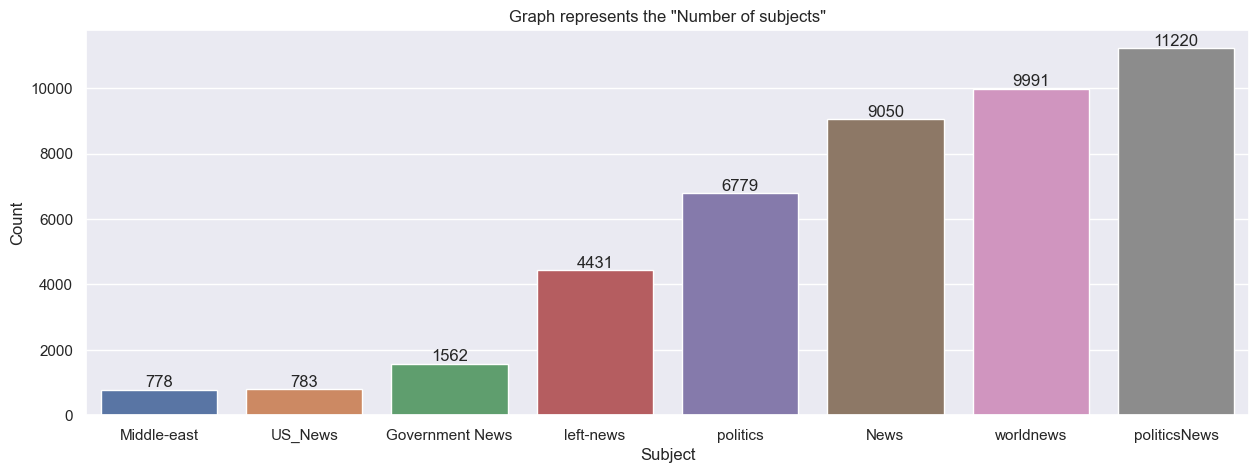

In [282]:
# graph represents the "Count of Individual Subjects"
subject_count = sb.countplot(x="subject", data=shuffled_data)

for i in subject_count.containers:
    subject_count.bar_label(i)

plt.title("Graph represents the \"Number of subjects\"")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.show()

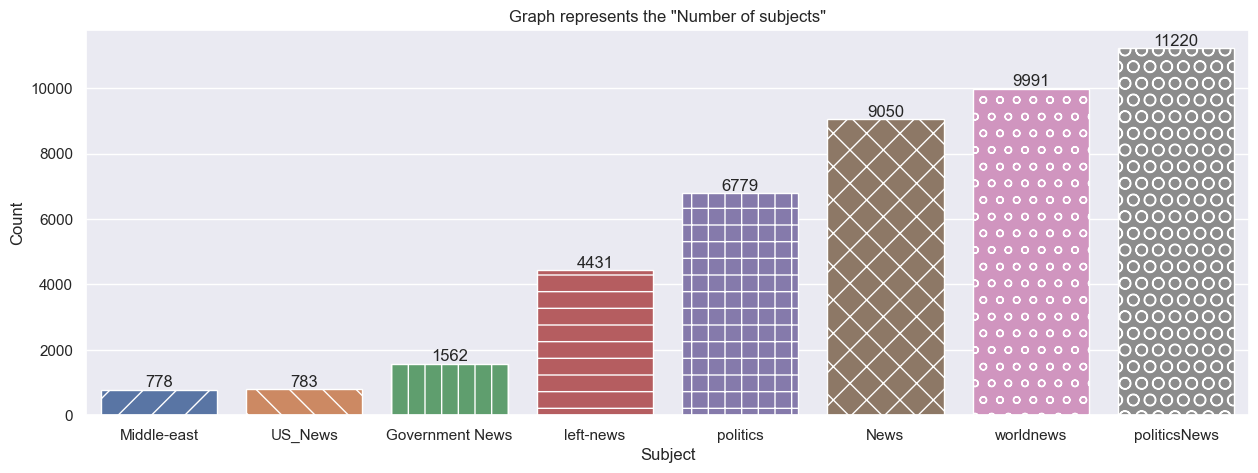

In [285]:
# graph represents the "Count of Individual Subjects"
subject_count = sb.countplot(x="subject", data=shuffled_data)

# applying patterns to each bar
for bar, hatch in zip(subject_count.patches, hatches * (len(subject_count.patches) // len(hatches) + 1)):
    bar.set_hatch(hatch)

# adding bar labels
for container in subject_count.containers:
    subject_count.bar_label(container)

plt.title("Graph represents the \"Number of subjects\"")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.show()

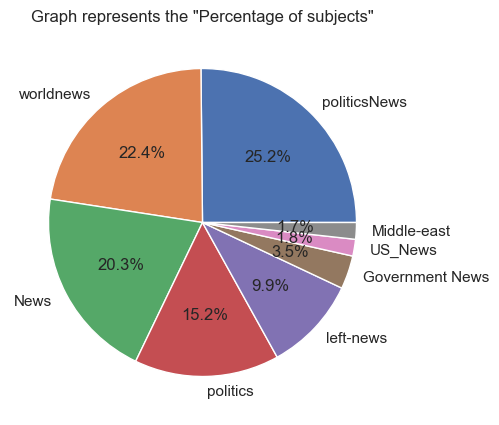

In [286]:
# graph represents the "Percentage of Individual Subjects"
shuffled_data["subject"].value_counts().plot.pie(autopct="%1.1f%%")

plt.title("Graph represents the \"Percentage of subjects\"")
plt.ylabel(None)
plt.show()

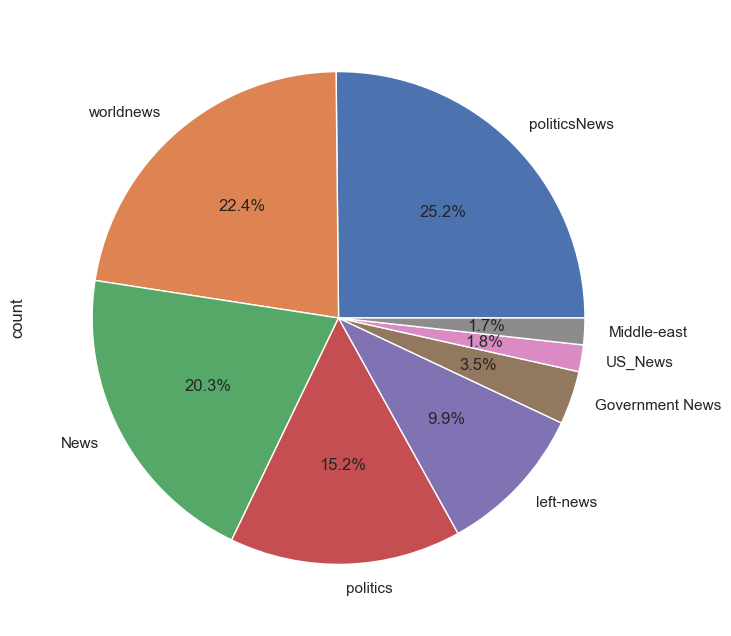

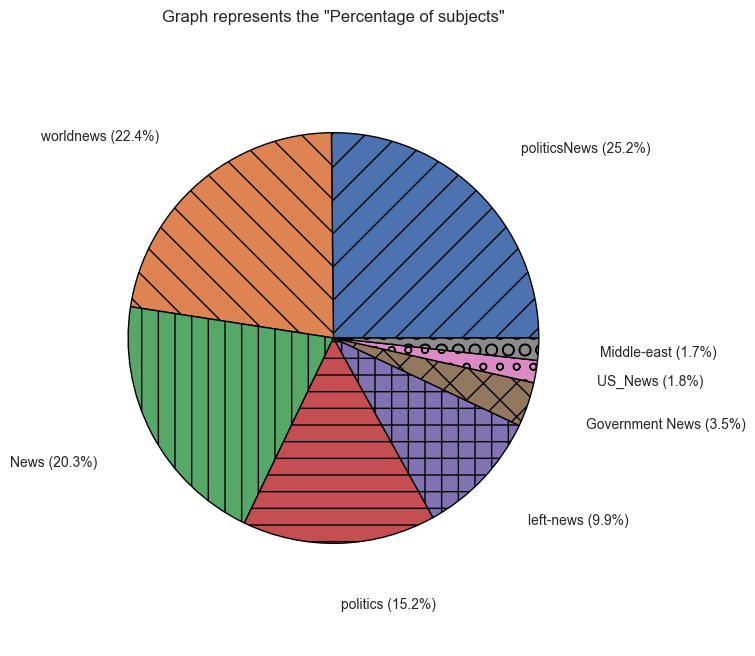

In [381]:
# graph represents the "Percentage of Individual Subjects"
# getting the value counts and percentages
value_counts = shuffled_data["subject"].value_counts()
percentages = value_counts / value_counts.sum() * 100
labels = value_counts.index

# defining colors for each wedge (you can customize the colors)
pie_chart = shuffled_data["subject"].value_counts().plot.pie(autopct="%1.1f%%", figsize=(8, 8))
colors = pie_chart.patches  # extracting the colors from the pie chart

# extracting the color values
colors = [patch.get_facecolor() for patch in colors]

# creating pie chart with patterns
fig, ax = plt.subplots(figsize=(8, 8))
start_angle = 0  # start angle for the first wedge

for i, (label, percentage) in enumerate(zip(labels, percentages)):
    # calculating the wedge's extent
    extent = percentage / 100 * 360
    
    # drawing the wedge with both color and pattern
    wedge = Wedge(
        center=(0, 0), 
        r=1, 
        theta1=start_angle, 
        theta2=start_angle + extent, 
        facecolor=colors[i],  # applying colors
        edgecolor='black', 
        linewidth=1
    )
    wedge.set_hatch(hatches[i % len(hatches)])  # applying the patterns
    ax.add_patch(wedge)
    
    # adding label
    mid_angle = start_angle + extent / 2
    x = 1.3 * np.cos(np.radians(mid_angle))
    y = 1.3 * np.sin(np.radians(mid_angle))
    alignment = 'left' if x > 0 else 'right'  # adjusting alignment based on x-coordinate
    ax.text(x, y, f"{label} ({percentage:.1f}%)", ha=alignment, va='center', fontsize=10)
    
    # updating the start angle for the next wedge
    start_angle += extent

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
plt.title("Graph represents the \"Percentage of subjects\"")
plt.axis('off')
plt.show()

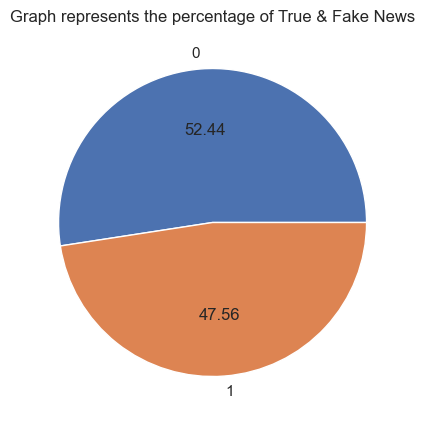

In [291]:
# graph represents the "Percentage of True & Fake News"
shuffled_data["label"].value_counts().plot.pie(autopct="%.2f")

plt.title("Graph represents the percentage of True & Fake News")
plt.ylabel(None)
plt.show()

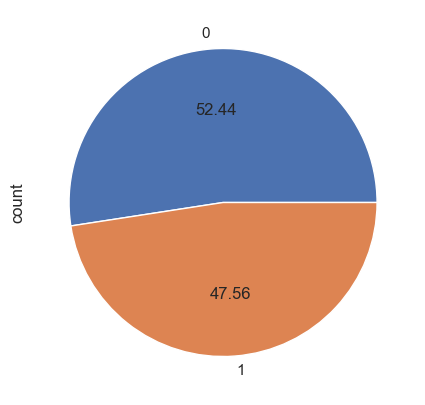

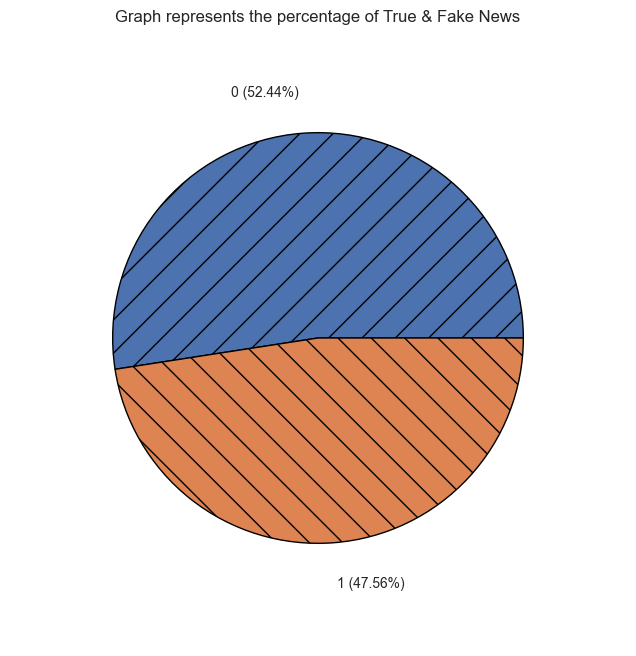

In [382]:
# graph represents the "Percentage of True & Fake News"
# getting the value counts and percentages
value_counts = shuffled_data["label"].value_counts()
percentages = value_counts / value_counts.sum() * 100
labels = value_counts.index

pie_chart = shuffled_data["label"].value_counts().plot.pie(autopct="%.2f")
colors = pie_chart.patches

# defining patterns for each wedge
colors = [patch.get_facecolor() for patch in colors]

# creating the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
start_angle = 0  # start angle for the first wedge

for i, (label, percentage) in enumerate(zip(labels, percentages)):
    # calculating the wedge's extent
    extent = percentage / 100 * 360
    
    # drawing the wedge with color and pattern
    wedge = Wedge(
        center=(0, 0), 
        r=1, 
        theta1=start_angle, 
        theta2=start_angle + extent, 
        facecolor=colors[i % len(colors)],  # applying color
        edgecolor='black', 
        linewidth=1
    )
    wedge.set_hatch(hatches[i % len(hatches)])  # applying pattern
    ax.add_patch(wedge)
    
    # adding label
    mid_angle = start_angle + extent / 2
    x = 1.2 * np.cos(np.radians(mid_angle))
    y = 1.2 * np.sin(np.radians(mid_angle))
    alignment = 'left' if x > 0 else 'right'
    
    ax.text(x, y, f"{label} ({percentage:.2f}%)", ha=alignment, va='center', fontsize=10)
    
    # updating the start angle for the next wedge
    start_angle += extent

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
plt.title("Graph represents the percentage of True & Fake News")
plt.axis('off')
plt.show()

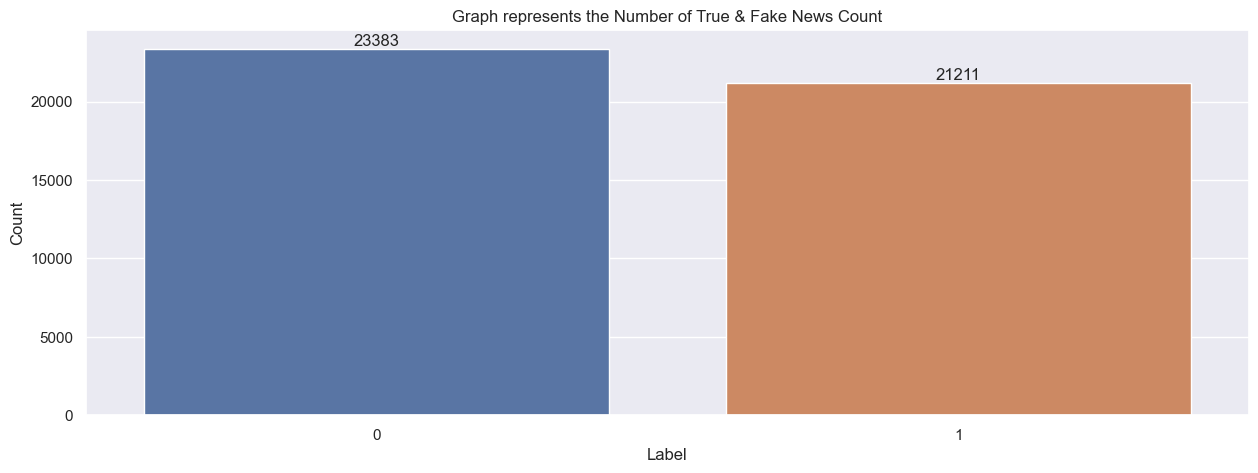

In [301]:
# graph represents the "Count of True & Fake News"
label_count = sb.countplot(x="label", data=shuffled_data)

for i in label_count.containers:
    label_count.bar_label(i)
    
plt.title("Graph represents the Number of True & Fake News Count")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

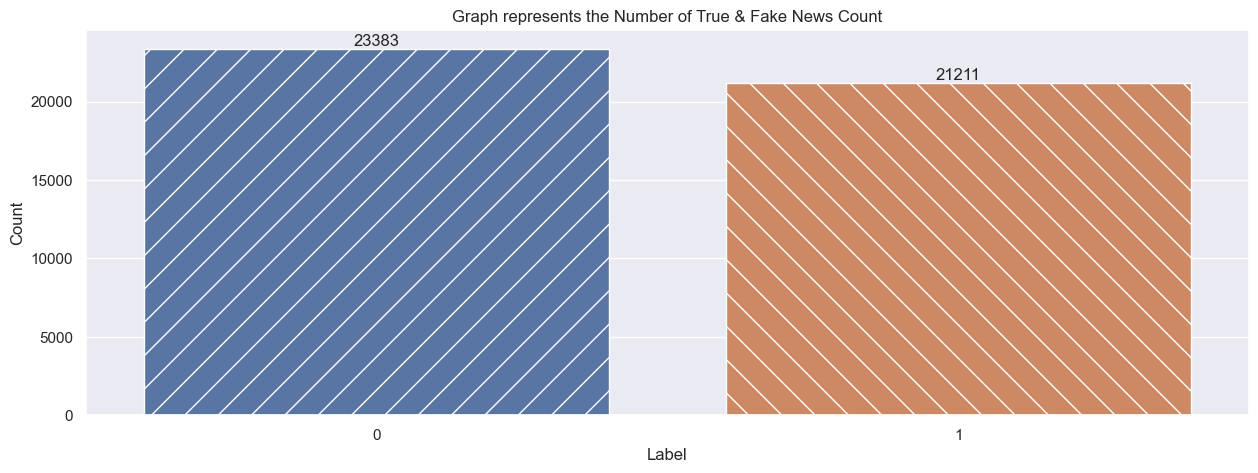

In [302]:
# graph represents the "Count of True & Fake News"
label_count = sb.countplot(x="label", data=shuffled_data)

# applying patterns to each bar
for bar, hatch in zip(label_count.patches, hatches):
    bar.set_hatch(hatch)

# adding bar labels
for container in label_count.containers:
    label_count.bar_label(container)

plt.title("Graph represents the Number of True & Fake News Count")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

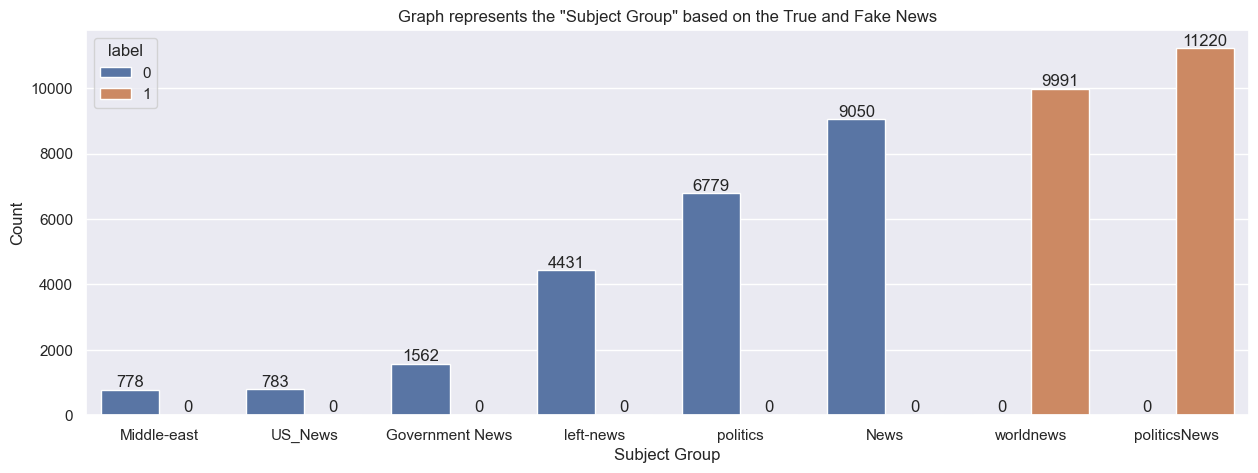

In [303]:
# graph represents the "Subjects based on News Type"
subject_group_by_label = sb.countplot(data=shuffled_data, x="subject", hue="label")

for i in subject_group_by_label.containers:
    subject_group_by_label.bar_label(i)

plt.title("Graph represents the \"Subject Group\" based on the True and Fake News")
plt.xlabel("Subject Group")
plt.ylabel("Count")
plt.show()

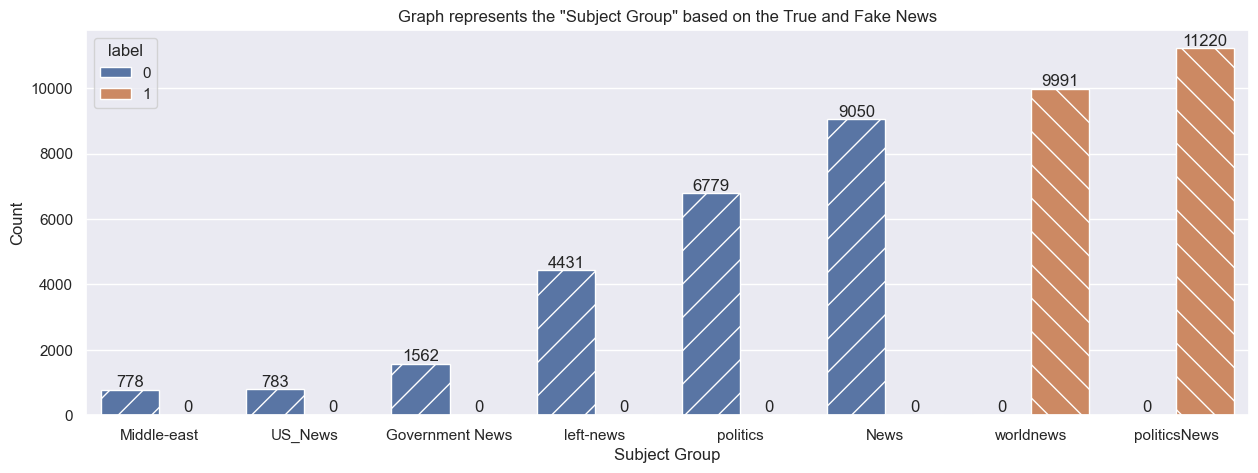

In [304]:
# graph represents the "Subjects based on News Type"
subject_group_by_label = sb.countplot(data=shuffled_data, x="subject", hue="label")

for bars, hatch in zip(subject_group_by_label.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch)

for container in subject_group_by_label.containers:
    subject_group_by_label.bar_label(container)

plt.title("Graph represents the \"Subject Group\" based on the True and Fake News")
plt.xlabel("Subject Group")
plt.ylabel("Count")
plt.show()

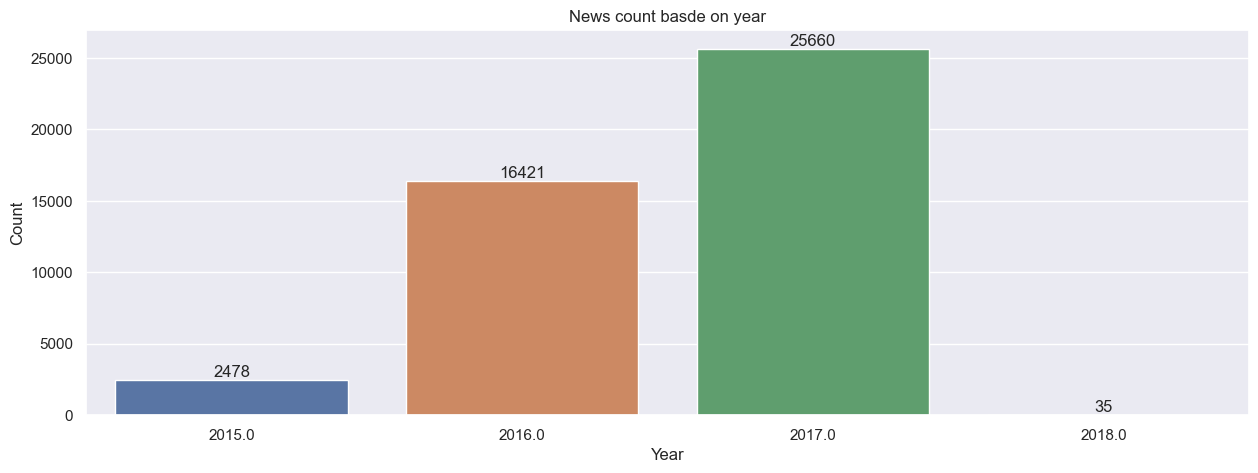

In [305]:
# graph represents the "News Count based on Year"
year_count = sb.countplot(x="year", data=shuffled_data)

for i in year_count.containers:
    year_count.bar_label(i)
    
plt.title("News count basde on year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

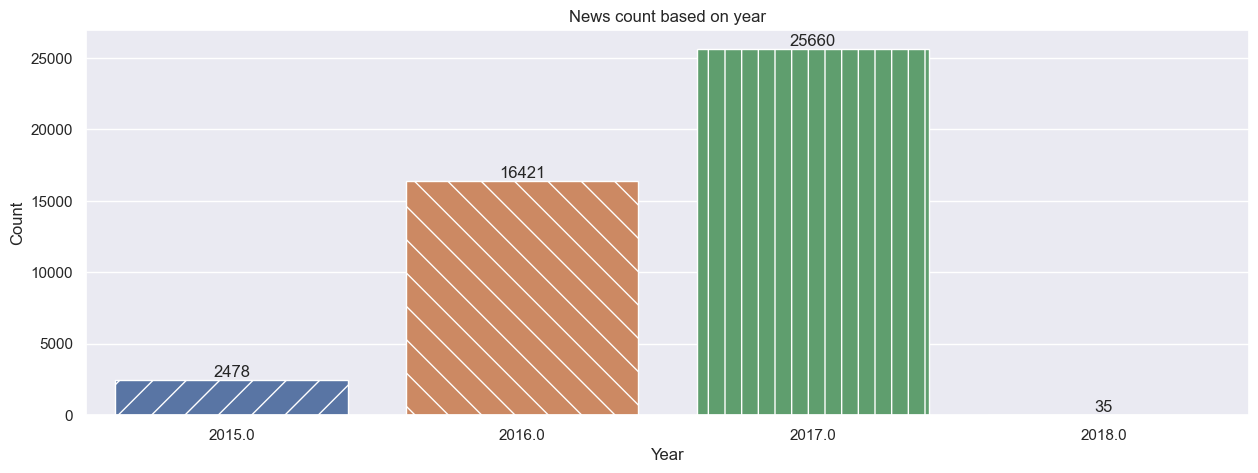

In [306]:
# graph represents the "News Count based on Year"
year_count = sb.countplot(x="year", data=shuffled_data)

for bar, hatch in zip(year_count.patches, hatches):
    bar.set_hatch(hatch)

for container in year_count.containers:
    year_count.bar_label(container)

plt.title("News count based on year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

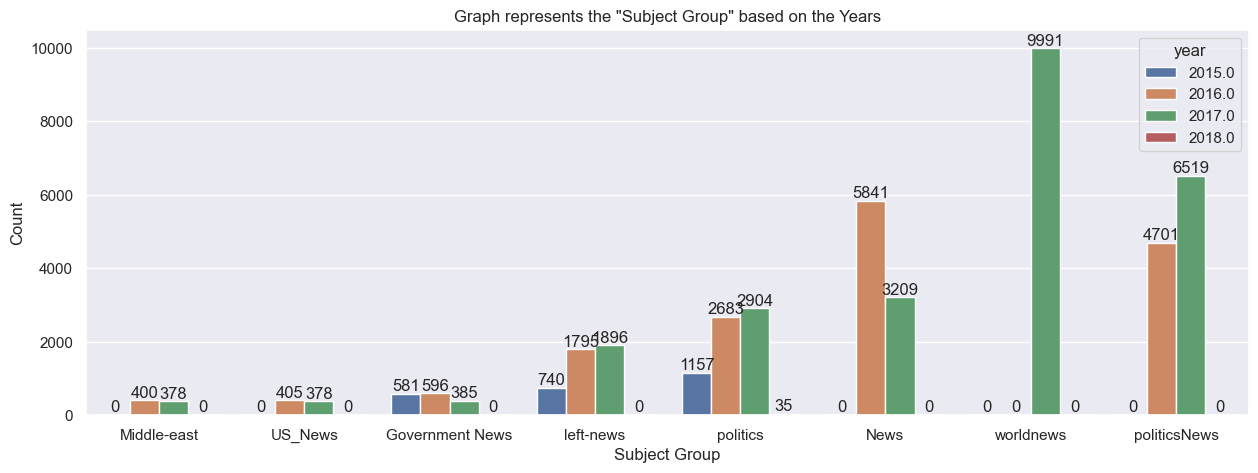

In [307]:
# graph represents the "Subject grouped based on Year"
subject_group_by_year = sb.countplot(data=shuffled_data, x="subject", hue="year")

for i in subject_group_by_year.containers:
    subject_group_by_year.bar_label(i)

plt.title("Graph represents the \"Subject Group\" based on the Years")
plt.xlabel("Subject Group")
plt.ylabel("Count")
plt.show()

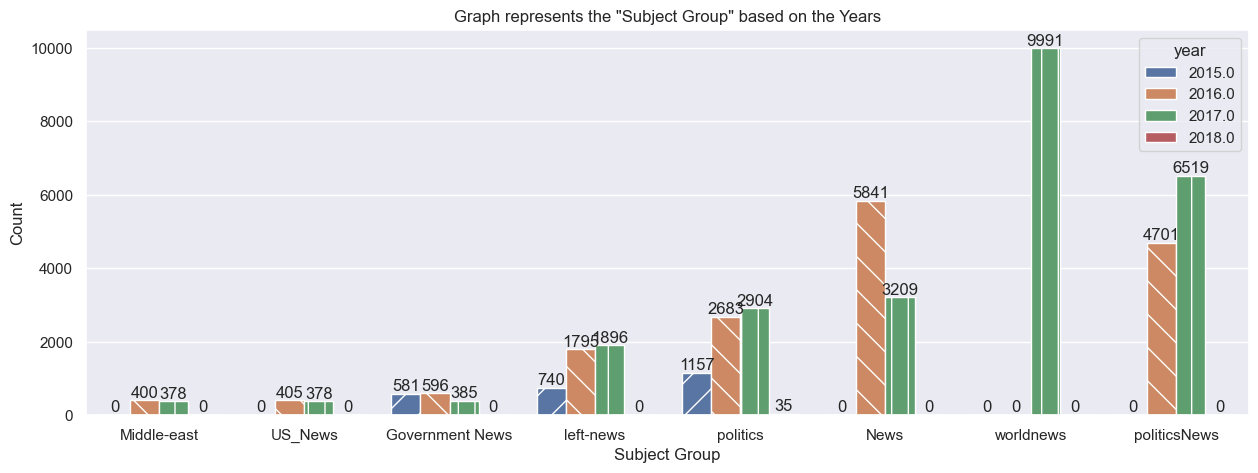

In [308]:
# graph represents the "Subject grouped based on Year"
subject_group_by_year = sb.countplot(data=shuffled_data, x="subject", hue="year")

for bars, hatch in zip(subject_group_by_year.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch)

for container in subject_group_by_year.containers:
    subject_group_by_year.bar_label(container)

plt.title("Graph represents the \"Subject Group\" based on the Years")
plt.xlabel("Subject Group")
plt.ylabel("Count")
plt.show()

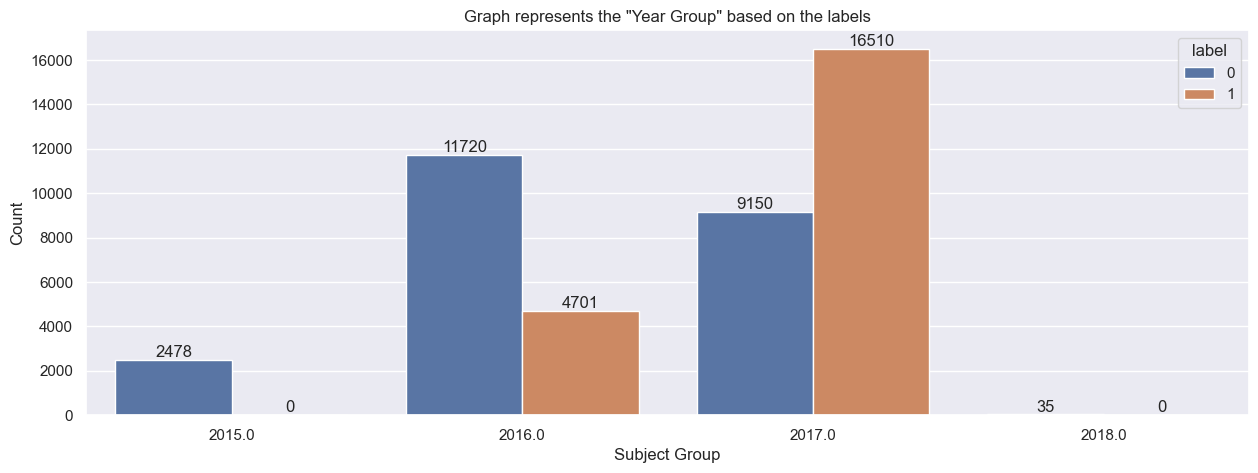

In [309]:
# graph represents the "Year grouped based on True & Fake News"
year_group_by_label = sb.countplot(data=shuffled_data, x="year", hue="label")

for i in year_group_by_label.containers:
    year_group_by_label.bar_label(i)

plt.title("Graph represents the \"Year Group\" based on the labels")
plt.xlabel("Subject Group")
plt.ylabel("Count")
plt.show()

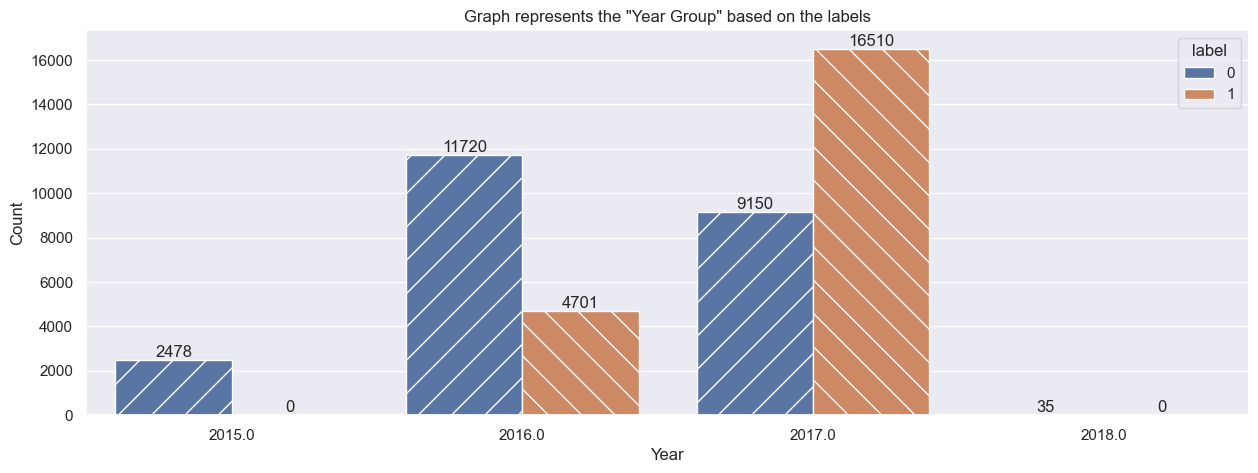

In [310]:
# graph represents the "Year grouped based on True & Fake News"
year_group_by_label = sb.countplot(data=shuffled_data, x="year", hue="label")

for bars, hatch in zip(year_group_by_label.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch)

for container in year_group_by_label.containers:
    year_group_by_label.bar_label(container)

plt.title("Graph represents the \"Year Group\" based on the labels")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

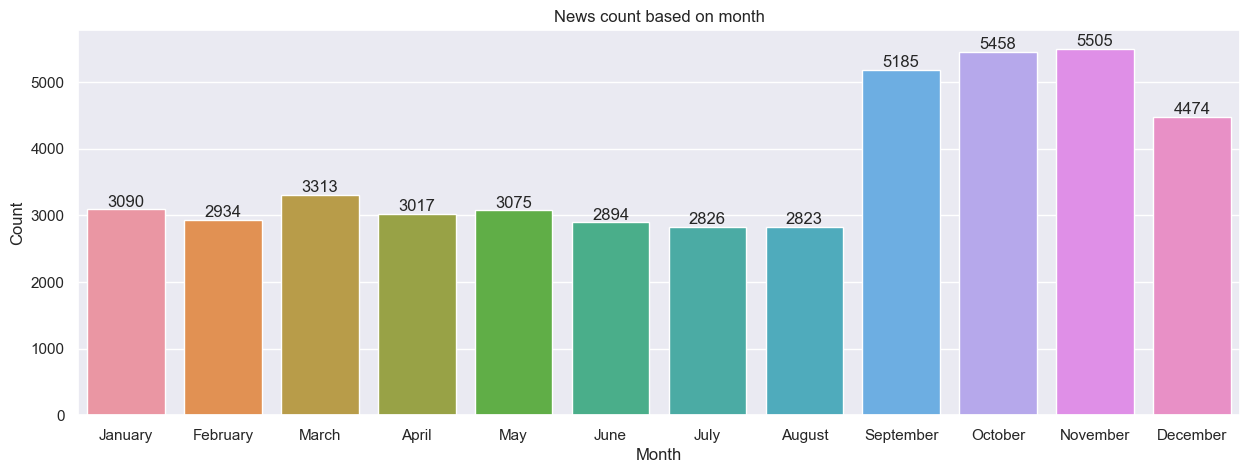

In [313]:
# graph represents the "News Count based on Months"
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

month_count = sb.countplot(x="month", data=shuffled_data, order=month_order)

for i in month_count.containers:
    month_count.bar_label(i)

plt.title("News count based on month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

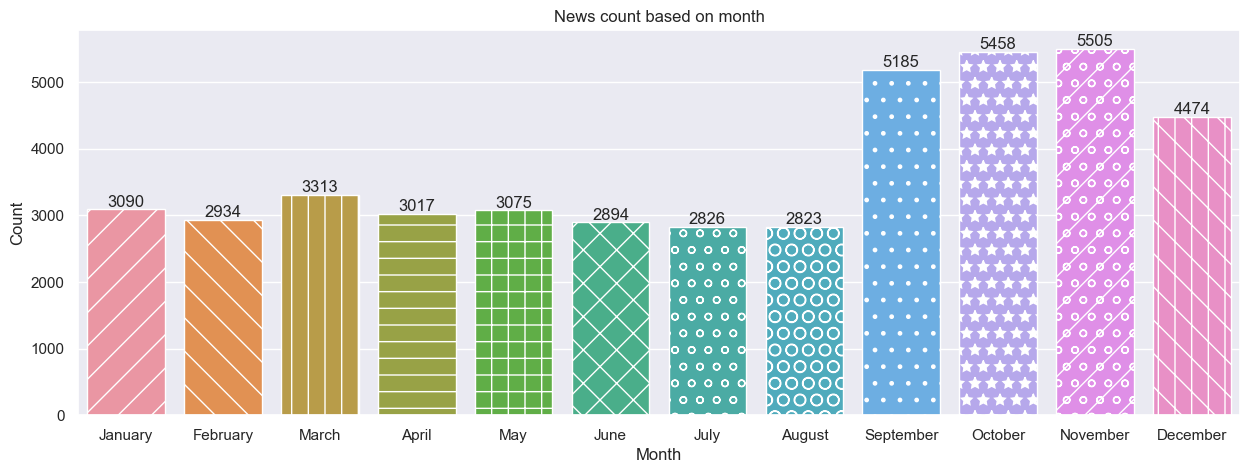

In [314]:
# graph represents the "News Count based on Months"
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

month_count = sb.countplot(x="month", data=shuffled_data, order=month_order)

for bar, hatch in zip(month_count.patches, hatches):
    bar.set_hatch(hatch)

for container in month_count.containers:
    month_count.bar_label(container)

plt.title("News count based on month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

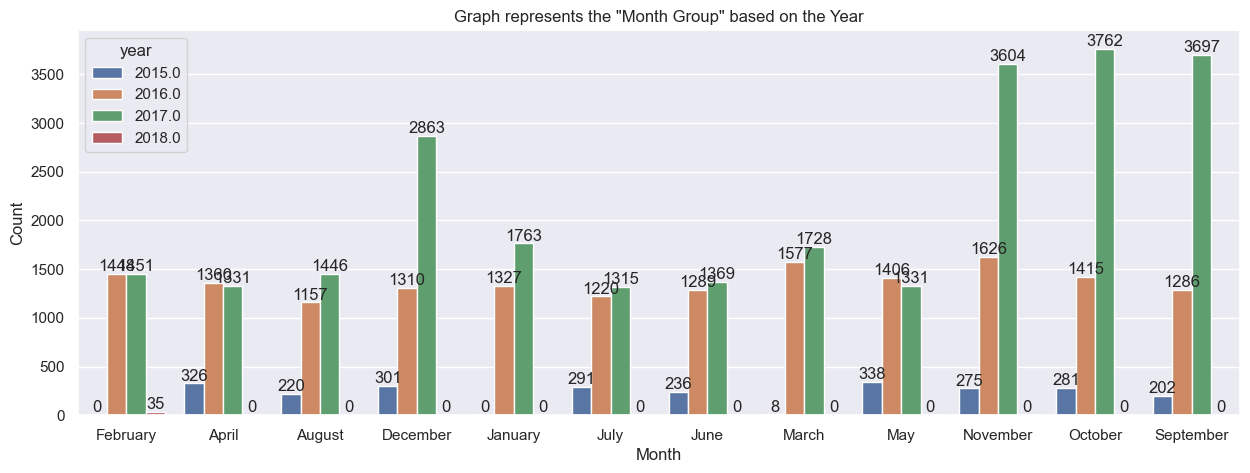

In [315]:
# graph represents the "News based on Month grouped based on Year"
month_group_by_year = sb.countplot(data=shuffled_data, x="month", hue="year")

for i in month_group_by_year.containers:
    month_group_by_year.bar_label(i)

plt.title("Graph represents the \"Month Group\" based on the Year")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

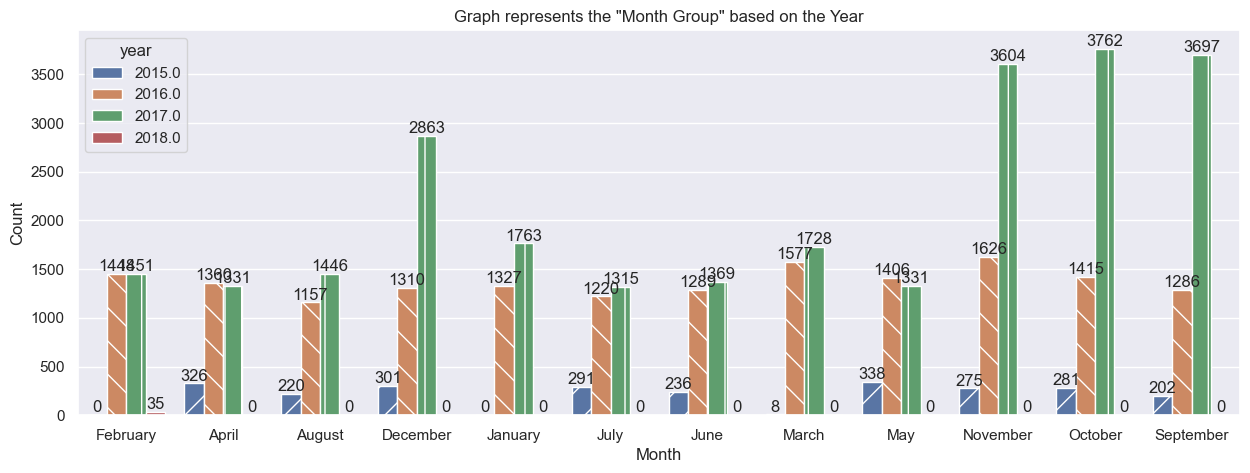

In [316]:
# graph represents the "News based on Month grouped based on Year"
month_group_by_year = sb.countplot(data=shuffled_data, x="month", hue="year")

for bars, hatch in zip(month_group_by_year.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch)

for container in month_group_by_year.containers:
    month_group_by_year.bar_label(container)

plt.title("Graph represents the \"Month Group\" based on the Year")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

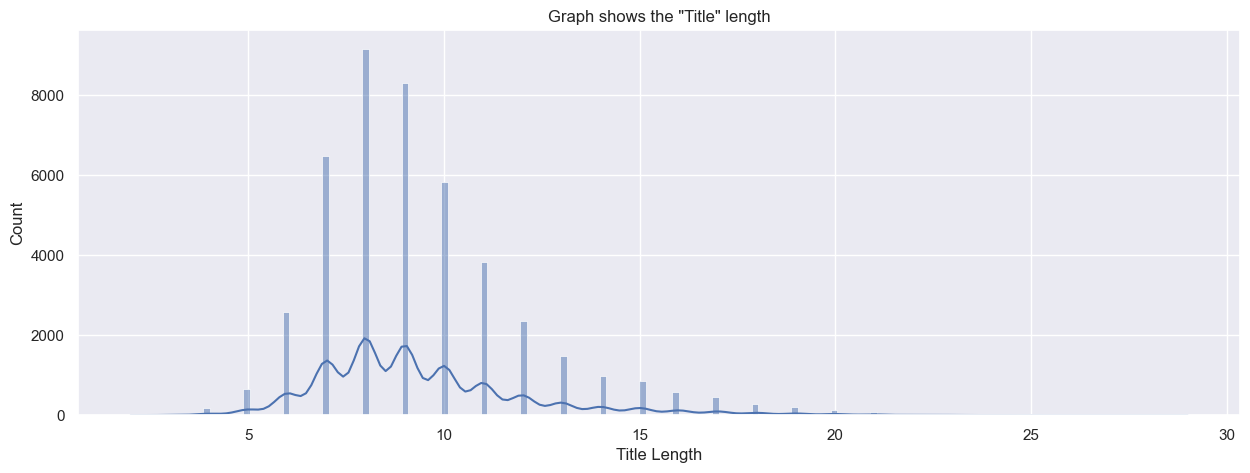

In [134]:
# graph represents the "Title Colmn Length"
sb.histplot(shuffled_data["title_length"], kde=True)

plt.title("Graph shows the \"Title\" length")
plt.xlabel("Title Length")
plt.ylabel("Count")
plt.show()

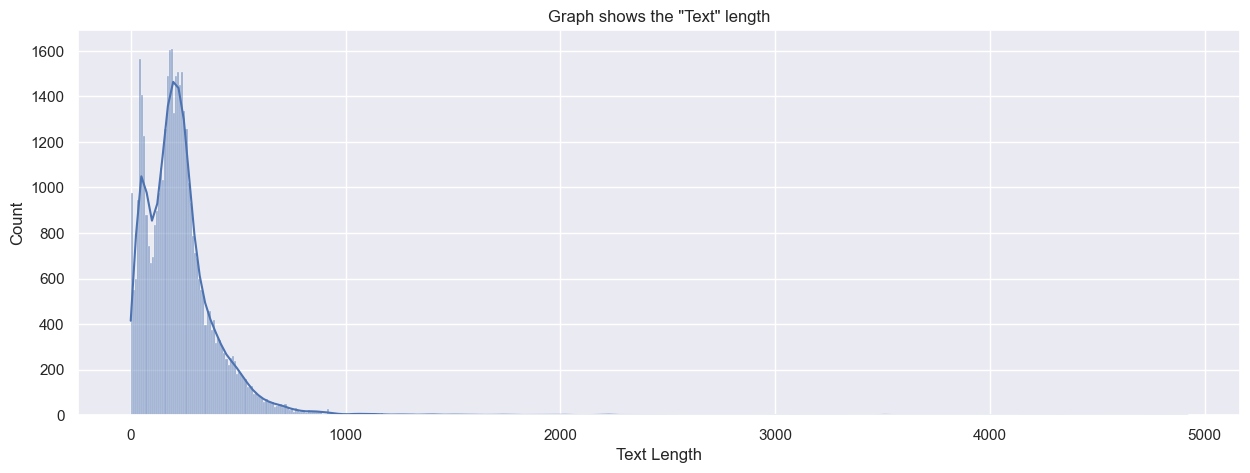

In [135]:
# graph represents the "Text Column Length"
sb.histplot(shuffled_data["text_length"], kde=True)

plt.title("Graph shows the \"Text\" length")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

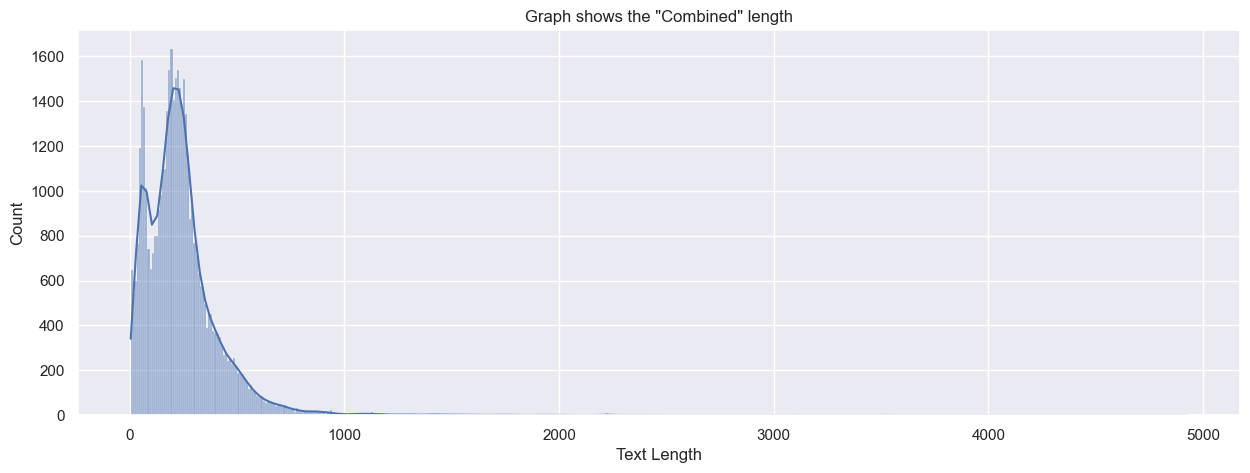

In [136]:
# graph represents the "Combined Column Length"
sb.histplot(shuffled_data["combined_text_length"], kde=True)

plt.title("Graph shows the \"Combined\" length")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

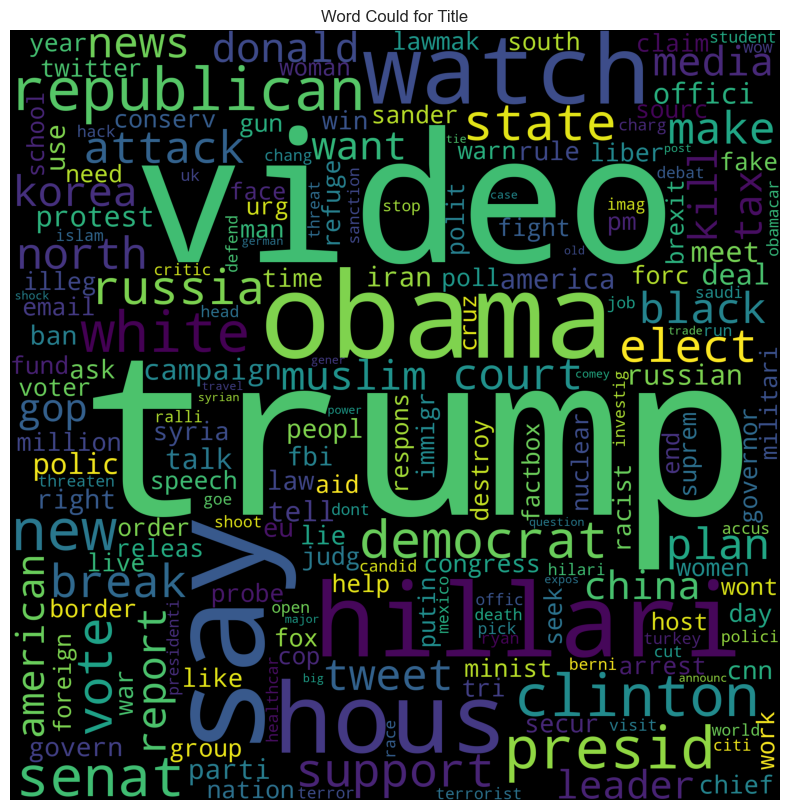

In [137]:
# graph represents the "Word Cloud of Title Column"
title_words = count_vectorizer.fit_transform(shuffled_data["title"])
sum_words_title = title_words.sum(axis=0)

words_frequency_title = [(word, sum_words_title[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_frequency_title = sorted(words_frequency_title, key=lambda x: x[1], reverse=True)

title_word_cloud = WordCloud(width=2000, height=2000).generate_from_frequencies(dict(words_frequency_title))

plt.figure(figsize=(10, 10))
plt.title("Word Could for Title")
plt.imshow(title_word_cloud)
plt.axis("off")
plt.show()

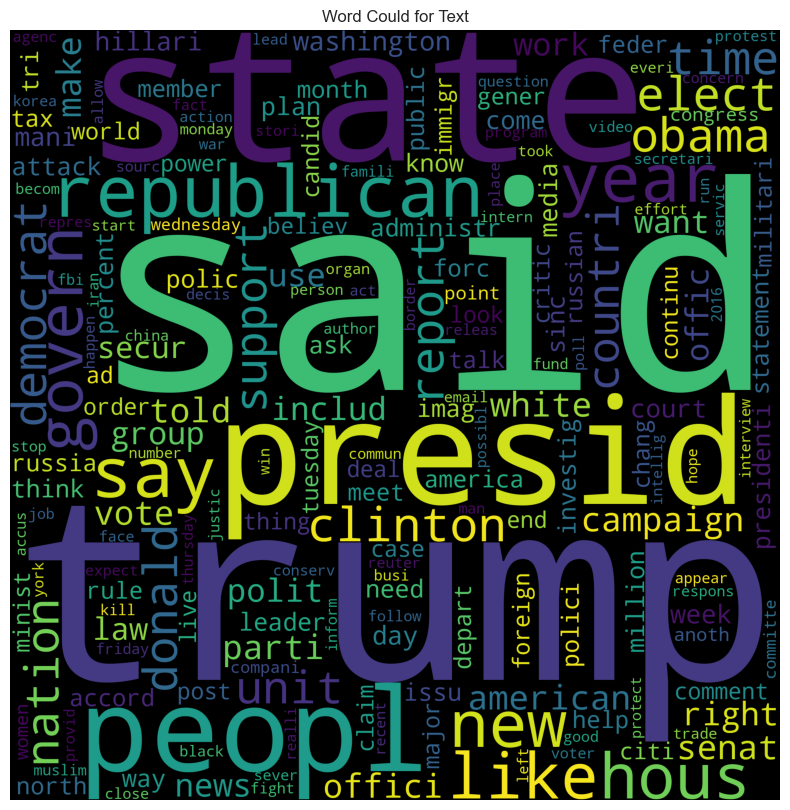

In [138]:
# graph represents the "Word Cloud of Text Column"
text_words = count_vectorizer.fit_transform(shuffled_data["text"])
sum_words_text = text_words.sum(axis=0)

words_frequency_text = [(word, sum_words_text[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_frequency_text = sorted(words_frequency_text, key=lambda x: x[1], reverse=True)

text_word_cloud = WordCloud(width=2000, height=2000).generate_from_frequencies(dict(words_frequency_text))

plt.figure(figsize=(10, 10))
plt.title("Word Could for Text")
plt.imshow(text_word_cloud)
plt.axis("off")
plt.show()

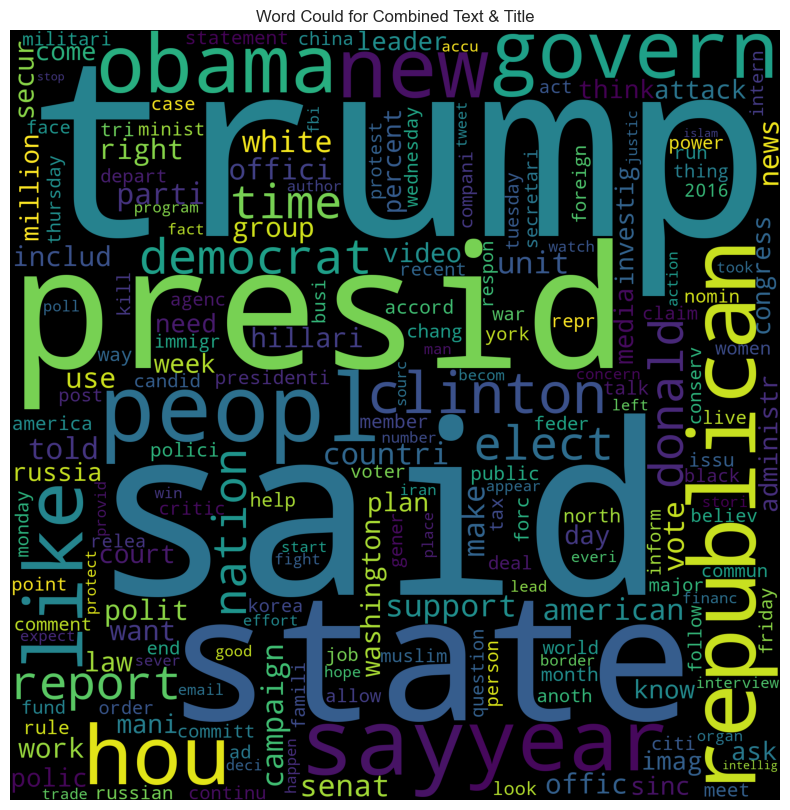

In [139]:
# graph represents the "Word Cloud of Combined Column"
text_words = count_vectorizer.fit_transform(shuffled_data["combined_text"])
sum_words_text = text_words.sum(axis=0)

words_frequency_text = [(word, sum_words_text[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_frequency_text = sorted(words_frequency_text, key=lambda x: x[1], reverse=True)

text_word_cloud = WordCloud(width=2000, height=2000).generate_from_frequencies(dict(words_frequency_text))

plt.figure(figsize=(10, 10))
plt.title("Word Could for Combined Text & Title")
plt.imshow(text_word_cloud)
plt.axis("off")
plt.show()

## 7. Spliting Data

**The data is splited into "Traning", "Validation", and "Testing" sets.**

1. **Traning:** 70% of the data is selected randomly for training.
2. **Validation:** 30% of "Traning" data is randomly used for validation.
3. **Testing:** 30% of the data is selected for testing.

In [140]:
# splitting the data
train_val = shuffled_data.sample(frac=0.7) # gets the 70% of the rows from the dataset randomly
test_data = shuffled_data.drop(train_val.index) # randomly selects 70% of the recods from the "train_val" for traning
train_data = train_val.sample(frac=0.7) # remaining 30% of the training data is used for validation
validation_data = train_val.drop(train_data.index) # remaining 30 % of data from the dataset is used for testing

In [141]:
# Check if there are duplicates between train, validation, and test data
train_val = set(train_data.index).intersection(set(validation_data.index))
if train_val:
    print(f"Overlap detected between train and validation sets: {train_val}")

test_val = set(test_data.index).intersection(set(validation_data.index))
if test_val:
    print(f"Overlap detected between test and validation sets: {test_val}")

test_train = set(test_data.index).intersection(set(train_data.index))
if test_train:
    print(f"Overlap detected between test and train sets: {test_train}")


In [142]:
# Splitting the data
train_val = shuffled_data.sample(frac=0.7, random_state=42)  # 70% of the data for train and validation
test_data = shuffled_data.drop(train_val.index)  # 30% for test data

# Split train_val into train_data and validation_data (without overlap)
train_data = train_val.sample(frac=0.7, random_state=42)  # 70% of train_val for training
validation_data = train_val.drop(train_data.index)  # remaining 30% for validation

# Check for overlap
overlap_train_val = set(train_data.index).intersection(validation_data.index)
if overlap_train_val:
    print(f"Overlap detected between train and validation sets: {overlap_train_val}")
else:
    print("No overlap between train and validation sets.")


No overlap between train and validation sets.


In [143]:
# reseting the index of the train, validation and test data
train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [144]:
from sklearn.model_selection import train_test_split

# First, split the data into train_val and test_data
train_val, test_data = train_test_split(shuffled_data, test_size=0.3, random_state=42, stratify=shuffled_data['label'])

# Now split the train_val into train_data and validation_data
train_data, validation_data = train_test_split(train_val, test_size=0.3, random_state=42, stratify=train_val['label'])

# Check for overlap
overlap_train_val = set(train_data.index).intersection(validation_data.index)
if overlap_train_val:
    print(f"Overlap detected between train and validation sets: {overlap_train_val}")
else:
    print("No overlap between train and validation sets.")


No overlap between train and validation sets.


In [145]:
print(f"The \"Training\" data has {train_data.shape[0]} rows and {train_data.shape[1]} columns")
print(f"The \"Validation\" data has {validation_data.shape[0]} rows and {validation_data.shape[1]} columns")
print(f"The \"Testing\" data has {test_data.shape[0]} rows and {test_data.shape[1]} columns")

The "Training" data has 21850 rows and 11 columns
The "Validation" data has 9365 rows and 11 columns
The "Testing" data has 13379 rows and 11 columns


In [146]:
# getting the length of combined text column
list_of_words = []

for i in shuffled_data.combined_text:
    for j in i:
        list_of_words.append(j)

total_words = len(list(set(list_of_words)))

In [147]:
print(total_words)

56


In [148]:
# tokenizer = Tokenizer(num_words=total_words) # creating tokens of words and creating sequences of tokenized words

# tokenizer.fit_on_texts(train_data["text"]) # fitting tokenizer on training data

In [149]:
# # converting texts to sequences
# train_sequences = tokenizer.texts_to_sequences(train_data["text"])
# validation_sequences = tokenizer.texts_to_sequences(validation_data["text"])
# test_sequences = tokenizer.texts_to_sequences(test_data["text"])

In [150]:
# # addting padding to sequences
# train_padding = pad_sequences(train_sequences, maxlen=20, padding="post", truncating="post")
# validation_padding = pad_sequences(validation_sequences, maxlen=20, padding="post", truncating="post")
# test_padding = pad_sequences(test_sequences, maxlen=20, padding="post", truncating="post")

In [151]:
all_text = " ".join(train_data["combined_text"]) # combining all text into a single string
all_words = all_text.split() # tokenize the text into individual words
word_counts = Counter(all_words) # counts the frequency of each word
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count']) # converting to DataFrame for easier analysis
word_freq_df = word_freq_df.sort_values(by='count', ascending=False) # sorting by frequency in descending order

word_freq_df['cumulative_coverage'] = word_freq_df['count'].cumsum() / word_freq_df['count'].sum() # calculating cumulative coverage

total_words_95 = word_freq_df[word_freq_df['cumulative_coverage'] <= 0.95].shape[0] # determine the number of words to cover 95% of the vocabulary

print(f"Number of words to cover 95% of the vocabulary: {total_words_95}")

Number of words to cover 95% of the vocabulary: 13339


## 8. Model Traning

### 8.1 Long Short-Term Memory (LSTM)

#### 8.1.1 Model Building

In [152]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data["combined_text"])
vocab_size = len(tokenizer.word_index) + 1  # +1 to account for the padding token
print(f"Vocabulary Size: {vocab_size}")


Vocabulary Size: 134661


In [323]:
tokenizer = Tokenizer(num_words=total_words_95) # creating tokens of words and creating sequences of tokenized words

tokenizer.fit_on_texts(train_data["combined_text"]) # fitting tokenizer on training data

# converting texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data["combined_text"])
validation_sequences = tokenizer.texts_to_sequences(validation_data["combined_text"])
test_sequences = tokenizer.texts_to_sequences(test_data["combined_text"])

# padding sequences to ensure uniform length 
max_sequence_length = 20
train_padding = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post') 
validation_padding = pad_sequences(validation_sequences, maxlen=max_sequence_length, padding='post') 
test_padding = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

vector_fatures = 50

# creating LSTM model
# 19174
lstm_model = Sequential()
lstm_model.add(Embedding(19174, vector_fatures, input_length=max_sequence_length))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation="sigmoid"))
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

lstm_model.summary()

lstm_y_train = np.asarray(train_data["label"]) 
lstm_y_validation = np.asarray(validation_data["label"])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(lstm_y_train), y=lstm_y_train)  # compute class weights 
class_weights_dict = dict(enumerate(class_weights)) 
early_stopping = EarlyStopping(monitor='val_loss', patience=20) # early stopping 
lstm_history = lstm_model.fit(train_padding, lstm_y_train, batch_size=64, validation_data=(validation_padding, lstm_y_validation), epochs=100, class_weight=class_weights_dict, callbacks=[early_stopping]) # fit the model and capture the history 

# traning evaluations
lstm_train_predictions = lstm_model.predict(validation_padding)
lstm_train_prediction_classes = (lstm_train_predictions > 0.5).astype("int32")
lstm_train_accuracy = accuracy_score(lstm_y_validation, lstm_train_prediction_classes)
lstm_train_precision = precision_score(lstm_y_validation, lstm_train_prediction_classes)
lstm_train_recall = recall_score(lstm_y_validation, lstm_train_prediction_classes)
lstm_train_f1 = f1_score(lstm_y_validation, lstm_train_prediction_classes)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 50)            958700    
                                                                 
 dropout_10 (Dropout)        (None, 20, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1019201 (3.89 MB)
Trainable params: 1019201 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
342/

#### 8.1.2 Model Accuracy

In [324]:
print("LSTM Traning Validation Matrics:")
print(f"Accuracy: {lstm_train_accuracy * 100}")
print(f"Precision: {lstm_train_precision * 100}")
print(f"Recall: {lstm_train_recall * 100}")
print(f"F1: {lstm_train_f1 * 100}")

LSTM Traning Validation Matrics:
Accuracy: 94.36198611852643
Precision: 93.87572641931158
Recall: 94.29726088908846
F1: 94.08602150537635


#### 8.1.3 Testing Model

In [325]:
# convert labels to numpy array
lstm_y_test = np.asarray(test_data["label"])

# make predictions on the test data
lstm_test_predictions = lstm_model.predict(test_padding)

# convert predictions to binary classes
lstm_test_prediction_classes = (lstm_test_predictions > 0.5).astype("int32")

# evaluate the model using various metrics
lstm_test_accuracy = accuracy_score(lstm_y_test, lstm_test_prediction_classes)
lstm_test_precision = precision_score(lstm_y_test, lstm_test_prediction_classes)
lstm_test_recall = recall_score(lstm_y_test, lstm_test_prediction_classes)
lstm_test_f1 = f1_score(lstm_y_test, lstm_test_prediction_classes)

419/419 [==============================] - 3s 6ms/step


#### 8.1.4 Test Model Accuracy

In [326]:
print(f"Test Accuracy: {lstm_test_accuracy * 100}")
print(f"Test Precision: {lstm_test_precision * 100}")
print(f"Test Recall: {lstm_test_recall * 100}")
print(f"Test F1 Score: {lstm_test_f1 * 100}")

Test Accuracy: 94.96972867927349
Test Precision: 94.59332393041842
Test Recall: 94.84600879949717
Test F1 Score: 94.71949784229109


#### 8.1.5 Testing Custom Data

In [327]:
# Test - 1 -> True News
custom_title = "NASA's Perseverance Rover Successfully Lands on Mars"
custom_text = "NASA's Perseverance rover has successfully landed on Mars, marking a significant milestone in space exploration. The rover will search for signs of ancient life and collect rock and soil samples for future return to Earth. This achievement showcases the incredible advancements in technology and human ingenuity."

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# make predictions on the custom input
custom_prediction = lstm_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")

1/1 [==============================] - 0s 37ms/step
Prediction: 1
Probability: 99.96553659439087


In [328]:
# Test - 2 -> Fake News
custom_title = "Aliens Invade Earth, Demand Human Resources"
custom_text = "Reports are flooding in from around the world of an alien invasion. Witnesses claim that extraterrestrial beings have landed and are demanding human resources to repair their spaceship. Authorities are urging citizens to stay indoors and avoid contact with these mysterious visitors. Experts are baffled by the sudden appearance of these otherworldly creatures."

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = lstm_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 33ms/step
Prediction: 1
Probability: 99.99404549598694


In [329]:
# Test - 3 -> True News
custom_title = """Michigan bill does not prohibit recounts based on allegations of election fraud"""
custom_text = """A bill signed by Michigan Gov. Gretchen Whitmer clarifies the rules around a recount but does not prohibit recounts based on election fraud allegations."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = lstm_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 37ms/step
Prediction: 1
Probability: 56.97764754295349


In [330]:
# Test - 4 -> False News
custom_title = """Thousands of fraudulent ballots for Clinton uncovered"""
custom_text = """A story claimed that tens of thousands of fraudulent ballots had been found in a warehouse in Ohio. The ballots had supposedly been cast for Hillary Clinton and were found inside sealed ballot boxes that would be counted alongside real election ballot boxes. This story was disproven."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = lstm_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 33ms/step
Prediction: 0
Probability: 1.044498532110083e-06


In [331]:
# Test - 5 -> True News
custom_title = """WHO Recommends New Vaccine for Malaria Prevention"""
custom_text = """The World Health Organization has approved a new malaria vaccine that shows promise in preventing the disease in children. It is expected to reduce mortality rates significantly in affected regions."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = lstm_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 26ms/step
Prediction: 1
Probability: 100.0


In [332]:
# Test - 6 -> False News
custom_title = """Aliens Spotted Over the White House in Broad Daylight"""
custom_text = """A viral video circulating online shows what appears to be an alien spacecraft hovering above the White House. Eyewitnesses claim they saw strange lights and heard an eerie hum coming from the object."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = lstm_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 26ms/step
Prediction: 0
Probability: 0.06814701482653618


In [333]:
# News titles
titles = [
    # True News Titles
    "WHO Recommends New Vaccine for Malaria Prevention",
    "Global Stock Markets See Sharp Decline Amid Economic Uncertainty",
    "NASA Schedules Artemis Mission to Return Humans to the Moon",
    "Scientists Develop Bioengineered Skin That Heals Faster",
    "Amazon Expands Renewable Energy Projects Globally",
    "Michigan bill does not prohibit recounts based on allegations of election fraud",
    "Video of Florida voter registration drive used to mislead on proof of citizenship question",
    "Posts falsely blame Ukraine for a missile strike on Kyiv children’s hospital",
    "NASA's Perseverance Rover lands on Mars",
    "Brexit Referendum Results",

    # Fake News Titles
    "Aliens Spotted Over the White House in Broad Daylight",
    "Eating Chocolate Daily Proven to Increase Lifespan by 20 Years",
    "Secret Underwater Pyramid Found in the Pacific Ocean",
    "Time Traveler Arrested After Predicting Events of 2050",
    "Government Implants Nanochips in Vaccines for Surveillance",
    "Thousands of fraudulent ballots for Clinton uncovered",
    "Megyn Kelly was fired after she endorsed Clinton",
    "The NBA cancels 2017 All-Star Game in North Carolina",
    "Pope Francis endorses Donald Trump",
    "Hillary Clinton running a child sex ring"
]

# News texts
texts = [
    # True News Texts
    "The World Health Organization has approved a new malaria vaccine that shows promise in preventing the disease in children. It is expected to reduce mortality rates significantly in affected regions.",
    "Major stock markets around the world experienced a significant drop due to rising economic uncertainty. Experts attribute the decline to inflation and concerns about potential interest rate hikes.",
    "NASA announced that the Artemis program will send astronauts back to the lunar surface by 2025, marking the first manned moon landing since Apollo 17 in 1972.",
    "Researchers have created a bioengineered skin that can heal injuries more quickly than natural skin. This breakthrough could revolutionize treatments for burn victims and patients with chronic wounds.",
    "Amazon has committed to expanding its renewable energy projects, aiming to achieve 100% renewable energy across all operations by 2030. New solar and wind projects are planned in Europe, Asia, and North America.",
    "A bill signed by Michigan Gov. Gretchen Whitmer clarifies the rules around a recount but does not prohibit recounts based on election fraud allegations.",
    "Shortly before the U.S. House of Representatives passed a bill requiring proof of citizenship to register to vote, a video of a voter registration drive in Palm Beach, Florida, was shared to raise questions about noncitizens voting in U.S. elections.",
    "After Ukraine’s largest children’s hospital was struck as part of a daytime barrage, posts circulated social media falsely claiming that Ukraine was at fault for the hit.",
    "NASA's Perseverance rover successfully landed on Mars in February 2021. This event marked a significant milestone in space exploration and was widely covered by reputable news sources.",
    "The United Kingdom voted to leave the European Union in the 2016 Brexit referendum. This event was widely reported and verified by multiple news outlets.",

    # Fake News Texts
    "A viral video circulating online shows what appears to be an alien spacecraft hovering above the White House. Eyewitnesses claim they saw strange lights and heard an eerie hum coming from the object.",
    "A recent study allegedly shows that eating chocolate every day can extend life expectancy by up to 20 years. Researchers say cocoa contains special enzymes that prevent aging.",
    "An underwater pyramid, believed to be over 10,000 years old, has supposedly been discovered in the Pacific Ocean. The structure is said to contain treasures and artifacts of an ancient civilization.",
    "Police have reportedly detained a man claiming to be a time traveler from the year 2050. He was taken into custody after attempting to warn the public about 'a major catastrophe' scheduled to happen.",
    "Conspiracy theorists claim that the government has begun implanting nanochips in COVID-19 vaccines to monitor citizens' activities. The alleged chips are said to transmit data directly to a central database.",
    "A story claimed that tens of thousands of fraudulent ballots had been found in a warehouse in Ohio. The ballots had supposedly been cast for Hillary Clinton and were found inside sealed ballot boxes that would be counted alongside real election ballot boxes. This story was disproven.",
    "A story claimed that Megyn Kelly was fired by Fox News after endorsing Clinton. This story was proven to be false. In fact, Fox News had offered Kelly over $20 million a year to remain with the network.",
    "A story claimed that the NBA canceled the 2017 All-Star Game in North Carolina in protest of the state's anti-gay bathroom bill. This story was false.",
    "A widely circulated fake news story claimed that Pope Francis endorsed Donald Trump for the U.S. presidency. This story was completely false and had no basis in reality.",
    "Another infamous fake news story alleged that Hillary Clinton was running a child sex ring out of a pizza restaurant in Washington, D.C. This story was entirely fabricated and had no factual basis."
]

# Labels indicating true (1) or fake (0) news
labels = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = lstm_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 26ms/step
Test: 1 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 30ms/step
Test: 2 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99997019767761
1/1 [==============================] - 0s 30ms/step
Test: 3 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99995231628418
1/1 [==============================] - 0s 25ms/step
Test: 4 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 57.343852519989014
1/1 [==============================] - 0s 29ms/step
Test: 5 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 3.1793081944897494e-06
1/1 [==============================] - 0s 29ms/step
Test: 6 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 56.97764754295349
1/1 [==============================] - 0s 25ms/step
Test: 7 -> 

In [334]:
titles = [
    # True News Titles
    "'Don't drink the spirits': Laos backpackers avoid shots after suspected poisonings",
    "'Pregnant' for 15 months: Inside the 'miracle' fertility scam",
    "Why Indians are risking it all to chase the American Dream",
    "Huge deal struck but is it enough? 5 takeaways from a dramatic COP29",
    "Can RFK Jr make America's diet healthy again?",
    "Expelled the same day: Ireland hardens illegal immigration response",
    "In stifled sobs and fierce accusations, family falls apart at mass rape trial",
    "British man captured while fighting with Ukraine",
    "Wicked proves popular as opening set to be biggest for Broadway film",
    "Storm Bert floods 'absolutely devastating', says Welsh FM",

    # Fake News Titles
    "The Onion buys Alex Jones's Infowars at auction",
    "How US election fraud claims changed as Trump won",
    "Whirlwind of misinformation sows distrust ahead of US election day",
    "FBI issues warning over two fake election videos",
    "US officials say Russians faked 'Haitian voters' video",
    "War ‘tour’, football and graffiti: How Russia is trying to influence Africa",
    "A week of unrest - and a week of silence from big tech",
    "A Bugatti car, a first lady and the fake stories aimed at Americans",
    "TikTok users being fed misleading election news, BBC finds",
    "Government should counter misinformation on TikTok - MPs"
]

texts = [
    # True News Texts
    """As the sun slowly dips behind the jagged peaks of Mount Nam Xay, a group of brightly coloured hot air balloons drift across the Vang Vieng valley. In the river below, young tourists laugh and splash each other from their kayaks. It’s not hard to see what draws so many travellers here to this little town in central Laos. The scenery is stunning, the fun cheap and plentiful. But the town has found itself at the centre of an international scandal after six tourists died last week following suspected methanol poisoning. It is believed their alcoholic drinks may have contained methanol, an industrial chemical often used in bootleg alcohol. For the throngs of young western travellers on South East Asia’s backpacker trail, Vang Vieng has become famous for what is called “tubing.” One described it to me as a water borne pub crawl. Groups of friends in swimsuits and bikinis clamber aboard huge inner tubes that would normally be used on trucks and drift downstream, pulling in from time to time at river side bars where vodka shots are liberally administered, before plunging back into the water. By the time they reach Vang Vieng everyone is fairly merry.""",
    """Chioma is adamant that Hope, the baby boy she is holding in her arms, is her son.  After eight years of failed attempts to conceive, she sees him as her miracle baby. “I’m the owner of my baby,” she says defiantly. She’s sitting next to her husband, Ike, in the office of a Nigerian state official who spends the best part of an hour interrogating the couple. As the commissioner for women affairs and social welfare in Anambra state, Ify Obinabo has plenty of experience in resolving family disputes - but this is no ordinary disagreement. Five members of Ike’s family, who are also present in the room, do not believe Hope is the couple’s biological child, as Chioma and Ike claim. Chioma claims to have “carried” the child for about 15 months. The commissioner and Ike’s family are in disbelief at the absurdity of the claim. Chioma says she faced pressure from Ike’s family to conceive. They even asked him to marry another woman. In her desperation, she visited a “clinic” offering an unconventional “treatment” - an outlandish and disturbing scam preying on women desperate to become mothers that involves the trafficking of babies.""",
    """In October, US Immigration and Customs Enforcement (Ice) sent a chartered flight carrying Indian nationals back home, marking a growing trend in deportations to India. This was no ordinary flight - it was one of multiple large-scale “removal flights” carried out this year, each typically carrying more than 100 passengers. The flights were returning groups of Indian migrants who "did not establish a legal basis to remain in the US". According to US officials, the latest flight carrying adult men and women was routed to Punjab, close to many deportees' places of origin. No precise breakdown of hometowns was provided. In the US fiscal year 2024 which ended in September, more than 1,000 Indian nationals had been repatriated by charter and commercial flights, according to Royce Bernstein Murray, assistant secretary at the US Department of Homeland Security.""",
    """COP29 is over, with developing countries complaining that the $300bn (about £240bn) a year in climate finance they will receive by 2035 is a "paltry sum". Many of the rich country voices at the UN's climate conference were amazed that developing nations were unhappy with what on the surface seems a huge settlement. It is an improvement - on the current contribution of $100bn (£79.8bn) a year. However, the developing world, which had pushed for more, had many genuine issues with the final sum. A massive deal, but bitter divisions remain There were complaints it simply was not enough and that it was a mixture of grants and loans. And countries were deeply annoyed by the way the wealthy waited until the last minute to reveal their hand. “It's a paltry sum," India's delegate Chandni Raina told other delegates, after the deal had been gavelled through. "This document is little more than an optical illusion. This, in our opinion, will not address the enormity of the challenge we all face.""",
    """Robert F Kennedy Jr has set his sights on changing how Americans eat and drink. From the dyes in Fruit Loops cereal to seed oils in chicken nuggets, Kennedy - who is President-elect Trump's choice to lead the Department of Health and Human Services (DHHS) - has long spoken out against ingredients that he says hurt Americans' health. "We are betraying our children by letting [food] industries poison them,” Kennedy said at a rally in November, after he had ended his independent presidential bid and backed Donald Trump. But if Kennedy hopes to target junk food, he will first have to shake up the country's food regulations - and run up against Big Food. “What he's suggesting is taking on the food industry,” said former New York University nutrition professor Marion Nestle. “Will Trump back him up on that? I’ll believe it when I see it.”""",
    """The three Gardai - Irish police officers - walk down the rows of passengers on the bus, a few kilometres south of the border with Northern Ireland. Observing this is the head of the Garda National Immigration Bureau, Det Ch Supt Aidan Minnock. “If they don't have status to be in Ireland, we bring them to Dublin,” he explains. “They're removed on a ferry back to the UK on the same day.” Asylum applications in Ireland have risen by nearly 300% so far this year compared to the same period five years ago. A spike in arrivals from the UK has been driven by various factors, among these the UK’s tougher stance post-Brexit, including the fear of deportations to Rwanda, as well as Ireland’s relatively healthy economy. Most asylum seekers coming from the UK to the Republic of Ireland enter the country from Northern Ireland, as - unlike the airport or ferry routes - there is no passport control. The Garda checks along the 500km-long (310 miles) border are the only means of stopping illegal entry. Det Ch Supt Minnock told the BBC that 200 people had been returned to the UK this year as a result of these checkpoints, thought to be only a small fraction of those crossing the porous border illegally.""",
    """At the epicentre of this devastating family drama is Gisèle Pelicot, a diminutive 72-year-old woman, drugged by her former husband and abused for a decade by dozens of strangers he had recruited online. Watching her entering the court in Avignon and giving evidence, it was staggering to imagine the amount of abuse her body sustained. But as other members of her family have taken the stand, it has become painfully clear that no-one has emerged unscathed from the storm unleashed by the actions of the Pelicot patriarch. The damage to this family is clear. Individually, they have described the destructive force that engulfed them in November 2020 as a “tsunami” that left nothing but ruin in its wake.""",
    """A British man has been captured by Russian forces while fighting for Ukraine, according to reports. In a video circulating online, a man dressed in military clothing identifies himself as James Scott Rhys Anderson, 22, and says he formerly served in the British Army. Russian state news agency Tass quotes a military source saying that what they call a "UK mercenary" has been "taken prisoner in the Kursk area" of Russia, part of which Ukraine has held since launching a surprise offensive in August. The foreign secretary said: "We will do all we can to offer this UK national all the support we can." Asked about reports of Mr Anderson's capture, David Lammy said he had "been updated about that development in the last couple of days". Scott Anderson, Mr Anderson's father, said he had begged his son not to go to Ukraine. "He wanted to go out there because he thought he was doing what was right," Mr Anderson told the Daily Mail. "I’m hoping he’ll be used as a bargaining chip, but my son told me they torture their prisoners and I’m so frightened he’ll be tortured.""",
    """Wicked is projected to have the top-grossing opening weekend of any Broadway musical adaptation ever in the UK and Ireland, as well as North America. The adaptation of the hit musical is expected to rake in $114m (£90.6m) on its opening weekend in North America, according to data firm the Boxoffice Company. That overtakes the previous record holder, Les Miserables, which brought in $103m globally on its opening weekend in 2012. In the UK and Ireland, the film is forecast to earn $17.6m (£14m) this weekend, making it the top-grossing opening weekend of 2024. In North America, where Gladiator II also opened on Friday, this was the strongest weekend at the box office before the Thanksgiving holiday since 2013, the Boxoffice Company said. The musical Wicked, based on a book inventing the backstory of the Wicked Witch of the West, premiered on Broadway in 2003 and has been running on the West End for two decades. In North America, the film adaptation raked in $46.48m (£37m) on Friday (the data also includes Thursday premieres), and $36m on Saturday. The audience skewed heavily female - 72% - and 67% were over the age of 25, which is a "massive victory" for Universal, Boxoffice's Daniel Loria said.""",
    """Welsh First Minister Eluned Morgan has said the floods brought by Storm Bert have been "absolutely devastating", as heavy rain and strong winds continue to move across the UK. South Wales, where a major incident has been declared by one council, has seen over 100mm of rain in places, while two areas in the south east of the country are under severe flood warnings, detailing a "significant risk to life". Ms Morgan said authorities had been prepared for the storm, but added that "when you get the kind of enormity of rain we’ve had over the past few days", minimising the impact was always "going to be difficult". The worst of the rain is moving eastwards into England, where the midlands and south west have also seen flooding. Across the UK, more than 100 flood warnings are now in force. Yellow warnings for wind and rain have been in effect for western Scotland, southern England and Wales, as well as Northern Ireland but are due to expire late on Sunday. A sole yellow warning for wind comes into force on Monday covering part of Scotland. There are also hundreds of flood alerts in place in England, Wales and Scotland. Wind gusts have reached 75mph in coastal areas and up to 65mph inland.""",

    # Fake News Texts
    """Satirical news publication The Onion has bought Infowars, the media organisation headed by right-wing conspiracy theorist Alex Jones, for an undisclosed price at a court-ordered auction.""",
    """In the build-up to Tuesday’s US election, claims of voter fraud flooded social media - but as Donald Trump’s victory crystallised, the chatter largely subsided. The claims didn’t stop entirely, however. A number of right-wing influencers and organisations pushing stories about “cheating” and a “rigged” vote pointed to incomplete vote totals and continued to repeat discredited theories about the 2020 election. And disappointed Democratic Party supporters developed their own unsubstantiated voter fraud theories, some of which went viral on X, formerly Twitter, and other platforms. The reach of the posts is nowhere near the deluge of content that circulated after Trump lost the 2020 election. And with no support from losing candidate Kamala Harris or other Democratic Party officials, the chances seem slim of a large-scale movement developing along the lines of the “Stop the Steal” drive four years ago, which culminated in a riot at the US Capitol.""",
    """Rumours, misleading allegations and outright lies about voting and fraud are flooding online spaces in unprecedented numbers in advance of the US election. Hundreds of incidents involving purported voting irregularities are being collected and spread by individuals, as well as both independent and Republican-affiliated groups. A small number of posts are also coming from Democrats. The US government has also alleged that foreign actors, including Russia, are spreading fake videos to undermine confidence in the electoral process.""",
    """The Federal Bureau of Investigation (FBI) has warned of two fake videos circulating online that aim to cast doubt around the US presidential election - the latest in a series of alerts by top officials. BBC Verify found evidence linking the videos to a much larger, Russia-based operation that has produced hundreds of fakes directed at the election in recent months. In a post on X on Saturday, the FBI said the two videos were spreading rumours about ballot fraud and about Doug Emhoff, the husband of Democrat candidate Vice-President Kamala Harris. The fake videos, which purport to be from the FBI and include the bureau’s logo, did not receive a large amount of views from real people on X. “These videos are not authentic, are not from the FBI, and the content they depict is false,” the FBI statement said. “Attempts to deceive the public with false content about FBI operations undermines our democratic process and aims to erode trust in the electoral system.” Election polls - is Harris or Trump ahead?""",
    """US intelligence agencies say "Russian influence actors" are behind a suspected fake video of a Haitian man who claims to have voted “multiple times” in Georgia. The 20-second video, which has been viewed hundreds of thousands of times on X and other social networks, shows two men in a car claiming to be Haitian. One says they obtained US citizenship within six months of arriving and have voted for Kamala Harris in Gwinnett and Fulton counties in Georgia. They encourage other Haitians to come to the United States. The BBC has found clear indications, including false addresses and stock photos, which indicate the video is a fake.""",
    """Teenage footballers listen to the Russian national anthem before a match. Nearby, artists paint Russian President Vladimir Putin’s portrait on a wall during a graffiti festival. Welcome to Burkina Faso, one of the African nations where Russia is boosting its operations to gain influence. Evidence found by the BBC shows that Russia is using media and cultural initiatives to attract African journalists, influencers, and students while spreading misleading information.""",
    """For days, similar scenes have played out across England and parts of Northern Ireland - unrest, communities in fear, a huge police presence, with the flames being fanned by social media. For days, journalists at BBC News have been contacting big tech companies, trying to find out what they are doing about it. Whatever it is, they don't want to talk about it - the messaging app Telegram has been the only firm to issue an on-the-record statement. It is hoped the tide has started to turn on the streets. But if they hoped that by keeping quiet they would avoid further scrutiny, the tech firms may well be wrong. "I think it is horrendous they are not taking more ownership of what is happening", says Baroness Martha Lane Fox, one of the leading lights in the UK tech scene. She knows big tech from the inside, having sat on the board of Twitter, as it was then called.""",
    """A network of Russia-based websites masquerading as local American newspapers is pumping out fake stories as part of an AI-powered operation that is increasingly targeting the US election, a BBC investigation can reveal. A former Florida police officer who relocated to Moscow is one of the key figures behind it. The following would have been a bombshell report - if it were true. Olena Zelenska, the first lady of Ukraine, allegedly bought a rare Bugatti Tourbillon sports car for 4.5m euros ($4.8m; £3.8m) while visiting Paris for D-Day commemorations in June. The source of the funds was supposedly American military aid money. The story appeared on an obscure French website just days ago - and was swiftly debunked. Experts pointed out strange anomalies on the invoice posted online. A whistleblower cited in the story appeared only in an oddly edited video that may have been artificially created. Bugatti issued a sharp denial, calling it "fake news", and its Paris dealership threatened legal action against the people behind the false story. But before the truth could even get its shoes on, the lie had gone viral. Influencers had already picked up the false story and spread it widely.""",
    """Young voters in key election battlegrounds are being recommended fake AI-generated videos featuring party leaders, misinformation, and clips littered with abusive comments, the BBC has found. With TikTok emerging as a new social media battleground in this election, the political parties have begun a war of memes on the app in a bid to reach its audience of young voters. But a BBC project to investigate the content promoted by social media algorithms has found - alongside funny montages - young people on TikTok are being exposed to misleading and divisive content. It is being shared by everyone from students and political activists to comedians and anonymous bot-like accounts. Videos which have racked up hundreds of thousands of views have promoted unfounded rumours that a major scandal prompted Rishi Sunak to call an early election and the baseless claim that Sir Keir Starmer was responsible for the failure to prosecute serial paedophile Jimmy Savile.""",
    """The government should publish advice for its departments on engaging with young people, including on TikTok, a group of MPs has said. The culture, media and sport committee has been looking into countering disinformation online. Its call comes despite TikTok currently being banned on government devices due to data security concerns. Accurate information needs to be communicated in a "relatable" way, the MPs say. The committee says that countering misinformation is particularly important for young people, who are increasingly turning away from traditional media and towards social media for their information."""
]

labels = [1]*10 + [0]*10

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = lstm_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 34ms/step
Test: 1 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 0.0002938618763437262
1/1 [==============================] - 0s 31ms/step
Test: 2 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.60601925849915
1/1 [==============================] - 0s 24ms/step
Test: 3 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.9986469745636
1/1 [==============================] - 0s 32ms/step
Test: 4 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 2.4425556883215904
1/1 [==============================] - 0s 26ms/step
Test: 5 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.95394349098206
1/1 [==============================] - 0s 29ms/step
Test: 6 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.98800754547119
1/1 [==============================] - 0s 24ms/step


In [335]:
titles = []
texts = []
labels = []

for index, row in test_data.iloc[:20].iterrows():
    titles.append(row["title"])
    texts.append(row["text"])
    labels.append(row["label"])

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = lstm_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 28ms/step
Test: 1 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99999403953552
1/1 [==============================] - 0s 27ms/step
Test: 2 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 27ms/step
Test: 3 -> The news was false and predicted as false
Label: 0
Prediction: 0
Probability: 4.5415229910084065e-08
1/1 [==============================] - 0s 30ms/step
Test: 4 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 25ms/step
Test: 5 -> The news was false and predicted as false
Label: 0
Prediction: 0
Probability: 0.0001520764953966136
1/1 [==============================] - 0s 30ms/step
Test: 6 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99998211860657
1/1 [==============================] - 0s 29ms/step
Test: 7 -> The ne

#### 8.1.6 Model Accuracy

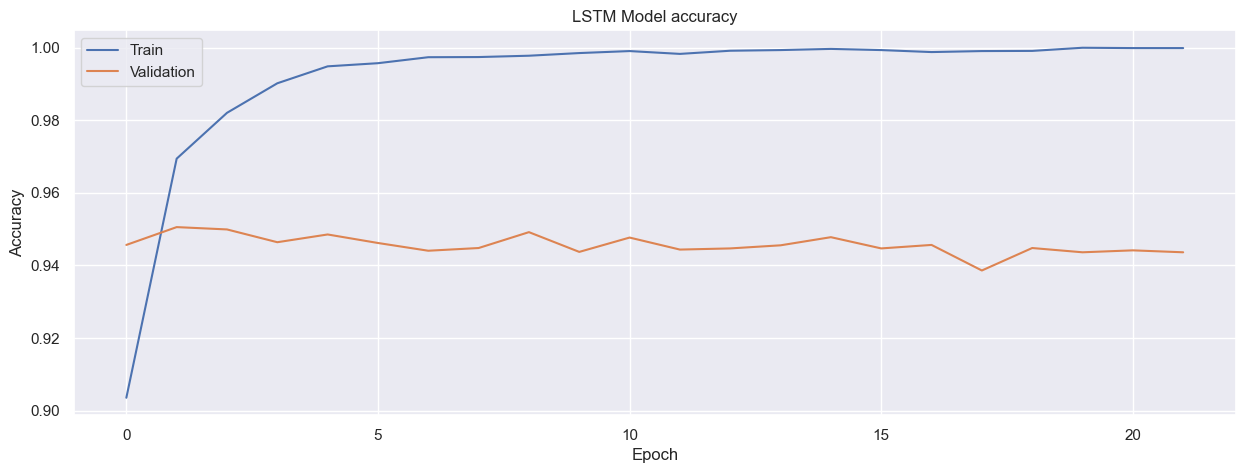

In [336]:
plt.plot(lstm_history.history["accuracy"]) 
plt.plot(lstm_history.history["val_accuracy"]) 
plt.title("LSTM Model accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("Epoch") 
plt.legend(["Train", "Validation"], loc="upper left") 
plt.show()

#### 8.1.7 Model Loss

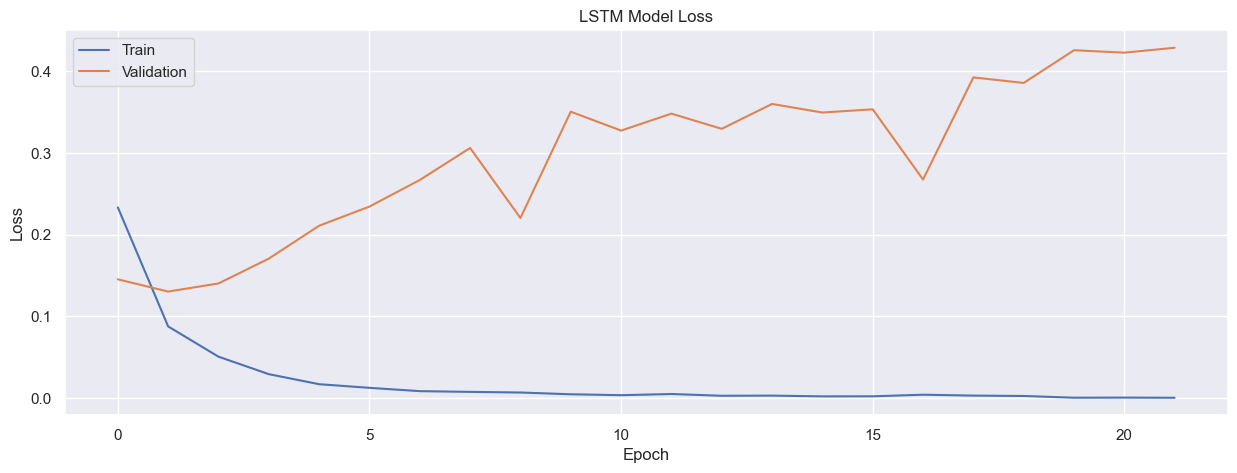

In [337]:
plt.plot(lstm_history.history["loss"])
plt.plot(lstm_history.history["val_loss"])
plt.title("LSTM Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

#### 8.1.8 Confusion Matrix

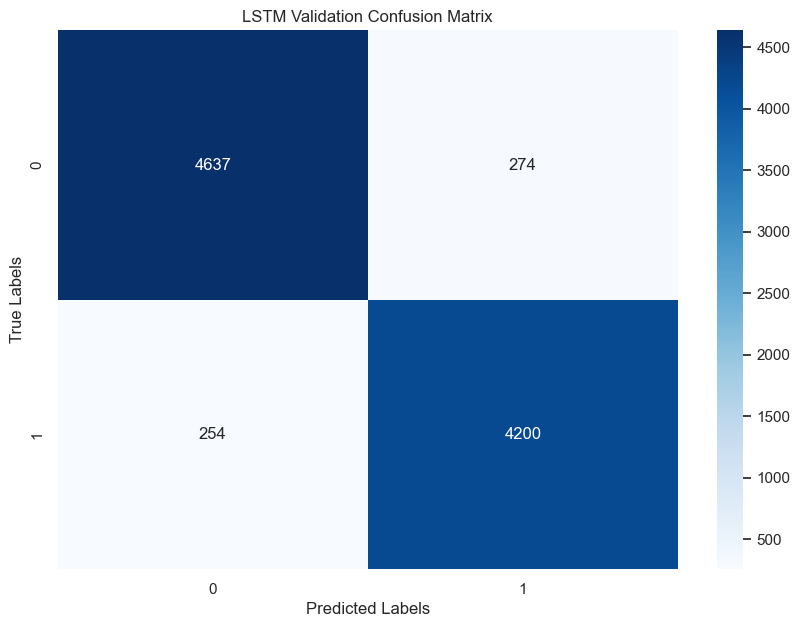

In [338]:
# confusion matrix for training data
train_conf_matrix = confusion_matrix(lstm_y_validation, lstm_train_prediction_classes)

plt.figure(figsize=(10, 7))
sb.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("LSTM Validation Confusion Matrix")
plt.show()


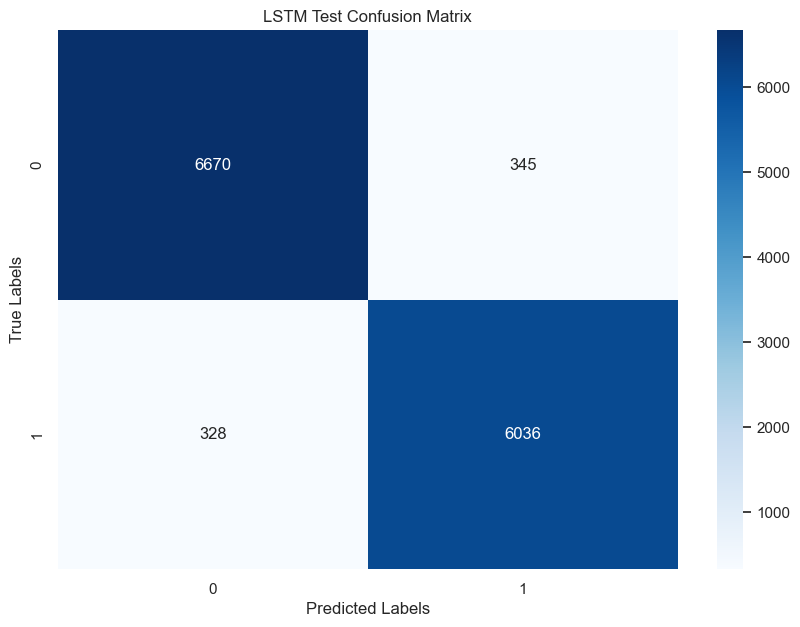

In [339]:
lstm_test_conf_matrix = confusion_matrix(lstm_y_test, lstm_test_prediction_classes) 

plt.figure(figsize=(10, 7)) 
sb.heatmap(lstm_test_conf_matrix, annot=True, fmt="d", cmap="Blues") 
plt.xlabel("Predicted Labels") 
plt.ylabel("True Labels") 
plt.title("LSTM Test Confusion Matrix") 
plt.show()

#### 8.1.9 Saving Tokanizer

In [383]:
with open('models/lstm_tokenizer.pkl', 'wb') as handle: 
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 8.1.10 Saving LSTM Model

In [384]:
lstm_model.save("models/lstm_model.h5")

### 8.2 Convolutional Neural Network (CNN)

#### 8.2.1 Model Building

In [340]:
tokenizer = Tokenizer(num_words=total_words_95) # creating tokens of words and creating sequences of tokenized words

tokenizer.fit_on_texts(train_data["combined_text"]) # fitting tokenizer on training data

train_sequences = tokenizer.texts_to_sequences(train_data["combined_text"])
validation_sequences = tokenizer.texts_to_sequences(validation_data["combined_text"])
test_sequences = tokenizer.texts_to_sequences(test_data["combined_text"])

# padding sequences to ensure uniform length 
max_sequence_length = 20
train_padding = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
validation_padding = pad_sequences(validation_sequences, maxlen=max_sequence_length, padding='post')
test_padding = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

vector_features = 50

# creating LSTM model
cnn_model = Sequential()
cnn_model.add(Embedding(19174, vector_features, input_length=max_sequence_length))
cnn_model.add(Conv1D(128, 5, activation="relu"))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation="sigmoid"))
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

cnn_model.summary()

cnn_y_train = np.asarray(train_data["label"])
cnn_y_validation = np.asarray(validation_data["label"])
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(cnn_y_train), y=cnn_y_train) # compute class weights 
class_weights_dict = dict(enumerate(class_weights))
early_stopping = EarlyStopping(monitor="val_loss", patience=20) # early stopping 
cnn_history = cnn_model.fit(train_padding, cnn_y_train, batch_size=64, validation_data=(validation_padding, cnn_y_validation), epochs=100, class_weight=class_weights_dict, callbacks=[early_stopping]) # fit the model and capture the history 

cnn_train_predictions = cnn_model.predict(validation_padding) 
cnn_train_prediction_classes = (cnn_train_predictions > 0.5).astype("int32") 
cnn_train_accuracy = accuracy_score(cnn_y_validation, cnn_train_prediction_classes) 
cnn_train_precision = precision_score(cnn_y_validation, cnn_train_prediction_classes) 
cnn_train_recall = recall_score(cnn_y_validation, cnn_train_prediction_classes) 
cnn_train_f1 = f1_score(cnn_y_validation, cnn_train_prediction_classes)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 50)            958700    
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 128)           32128     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                      

#### 8.2.2 Model Accuracy

In [341]:
print("CNN Training Validation Metrics:") 
print(f"Accuracy: {cnn_train_accuracy * 100}") 
print(f"Precision: {cnn_train_precision * 100}") 
print(f"Recall: {cnn_train_recall * 100}") 
print(f"F1: {cnn_train_f1 * 100}")

CNN Training Validation Metrics:
Accuracy: 93.96689802455953
Precision: 94.2434584755404
Recall: 92.99506061966771
F1: 93.61509775115833


#### 8.2.3 Testing Model

In [342]:
cnn_y_test = np.asarray(test_data["label"]) 
cnn_test_predictions = cnn_model.predict(test_padding) 
cnn_test_prediction_classes = (cnn_test_predictions > 0.5).astype("int32") 
cnn_test_accuracy = accuracy_score(cnn_y_test, cnn_test_prediction_classes) 
cnn_test_precision = precision_score(cnn_y_test, cnn_test_prediction_classes) 
cnn_test_recall = recall_score(cnn_y_test, cnn_test_prediction_classes) 
cnn_test_f1 = f1_score(cnn_y_test, cnn_test_prediction_classes)

419/419 [==============================] - 1s 3ms/step


#### 8.2.4 Test Model Accuracy

In [343]:
print(f"Test Accuracy: {cnn_test_accuracy * 100}") 
print(f"Test Precision: {cnn_test_precision * 100}") 
print(f"Test Recall: {cnn_test_recall * 100}") 
print(f"Test F1 Score: {cnn_test_f1 * 100}")

Test Accuracy: 94.46894386725465
Test Precision: 94.57831325301204
Test Recall: 93.7460716530484
Test F1 Score: 94.16035353535354


#### 8.2.5 Testing Custom Data

In [344]:
# Test - 1 -> True News
custom_title = "NASA's Perseverance Rover Successfully Lands on Mars"
custom_text = "NASA's Perseverance rover has successfully landed on Mars, marking a significant milestone in space exploration. The rover will search for signs of ancient life and collect rock and soil samples for future return to Earth. This achievement showcases the incredible advancements in technology and human ingenuity."

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# make predictions on the custom input
custom_prediction = cnn_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")

1/1 [==============================] - 0s 25ms/step
Prediction: 0
Probability: 14.769944548606873


In [345]:
# Test - 2 -> Fake News
custom_title = "Aliens Invade Earth, Demand Human Resources"
custom_text = "Reports are flooding in from around the world of an alien invasion. Witnesses claim that extraterrestrial beings have landed and are demanding human resources to repair their spaceship. Authorities are urging citizens to stay indoors and avoid contact with these mysterious visitors. Experts are baffled by the sudden appearance of these otherworldly creatures."

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cnn_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 33ms/step
Prediction: 1
Probability: 99.97416138648987


In [346]:
# Test - 3 -> True News
custom_title = """Michigan bill does not prohibit recounts based on allegations of election fraud"""
custom_text = """A bill signed by Michigan Gov. Gretchen Whitmer clarifies the rules around a recount but does not prohibit recounts based on election fraud allegations."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cnn_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 31ms/step
Prediction: 0
Probability: 0.11706672376021743


In [347]:
# Test - 4 -> False News
custom_title = """Thousands of fraudulent ballots for Clinton uncovered"""
custom_text = """A story claimed that tens of thousands of fraudulent ballots had been found in a warehouse in Ohio. The ballots had supposedly been cast for Hillary Clinton and were found inside sealed ballot boxes that would be counted alongside real election ballot boxes. This story was disproven."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cnn_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 33ms/step
Prediction: 0
Probability: 0.0003821309292106889


In [348]:
# Test - 5 -> True News
custom_title = """WHO Recommends New Vaccine for Malaria Prevention"""
custom_text = """The World Health Organization has approved a new malaria vaccine that shows promise in preventing the disease in children. It is expected to reduce mortality rates significantly in affected regions."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cnn_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 41ms/step
Prediction: 1
Probability: 99.99998211860657


In [349]:
# Test - 6 -> False News
custom_title = """Aliens Spotted Over the White House in Broad Daylight"""
custom_text = """A viral video circulating online shows what appears to be an alien spacecraft hovering above the White House. Eyewitnesses claim they saw strange lights and heard an eerie hum coming from the object."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cnn_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 27ms/step
Prediction: 0
Probability: 0.00014706314459544956


In [350]:
# News titles
titles = [
    # True News Titles
    "WHO Recommends New Vaccine for Malaria Prevention",
    "Global Stock Markets See Sharp Decline Amid Economic Uncertainty",
    "NASA Schedules Artemis Mission to Return Humans to the Moon",
    "Scientists Develop Bioengineered Skin That Heals Faster",
    "Amazon Expands Renewable Energy Projects Globally",
    "Michigan bill does not prohibit recounts based on allegations of election fraud",
    "Video of Florida voter registration drive used to mislead on proof of citizenship question",
    "Posts falsely blame Ukraine for a missile strike on Kyiv children’s hospital",
    "NASA's Perseverance Rover lands on Mars",
    "Brexit Referendum Results",

    # Fake News Titles
    "Aliens Spotted Over the White House in Broad Daylight",
    "Eating Chocolate Daily Proven to Increase Lifespan by 20 Years",
    "Secret Underwater Pyramid Found in the Pacific Ocean",
    "Time Traveler Arrested After Predicting Events of 2050",
    "Government Implants Nanochips in Vaccines for Surveillance",
    "Thousands of fraudulent ballots for Clinton uncovered",
    "Megyn Kelly was fired after she endorsed Clinton",
    "The NBA cancels 2017 All-Star Game in North Carolina",
    "Pope Francis endorses Donald Trump",
    "Hillary Clinton running a child sex ring"
]

# News texts
texts = [
    # True News Texts
    "The World Health Organization has approved a new malaria vaccine that shows promise in preventing the disease in children. It is expected to reduce mortality rates significantly in affected regions.",
    "Major stock markets around the world experienced a significant drop due to rising economic uncertainty. Experts attribute the decline to inflation and concerns about potential interest rate hikes.",
    "NASA announced that the Artemis program will send astronauts back to the lunar surface by 2025, marking the first manned moon landing since Apollo 17 in 1972.",
    "Researchers have created a bioengineered skin that can heal injuries more quickly than natural skin. This breakthrough could revolutionize treatments for burn victims and patients with chronic wounds.",
    "Amazon has committed to expanding its renewable energy projects, aiming to achieve 100% renewable energy across all operations by 2030. New solar and wind projects are planned in Europe, Asia, and North America.",
    "A bill signed by Michigan Gov. Gretchen Whitmer clarifies the rules around a recount but does not prohibit recounts based on election fraud allegations.",
    "Shortly before the U.S. House of Representatives passed a bill requiring proof of citizenship to register to vote, a video of a voter registration drive in Palm Beach, Florida, was shared to raise questions about noncitizens voting in U.S. elections.",
    "After Ukraine’s largest children’s hospital was struck as part of a daytime barrage, posts circulated social media falsely claiming that Ukraine was at fault for the hit.",
    "NASA's Perseverance rover successfully landed on Mars in February 2021. This event marked a significant milestone in space exploration and was widely covered by reputable news sources.",
    "The United Kingdom voted to leave the European Union in the 2016 Brexit referendum. This event was widely reported and verified by multiple news outlets.",

    # Fake News Texts
    "A viral video circulating online shows what appears to be an alien spacecraft hovering above the White House. Eyewitnesses claim they saw strange lights and heard an eerie hum coming from the object.",
    "A recent study allegedly shows that eating chocolate every day can extend life expectancy by up to 20 years. Researchers say cocoa contains special enzymes that prevent aging.",
    "An underwater pyramid, believed to be over 10,000 years old, has supposedly been discovered in the Pacific Ocean. The structure is said to contain treasures and artifacts of an ancient civilization.",
    "Police have reportedly detained a man claiming to be a time traveler from the year 2050. He was taken into custody after attempting to warn the public about 'a major catastrophe' scheduled to happen.",
    "Conspiracy theorists claim that the government has begun implanting nanochips in COVID-19 vaccines to monitor citizens' activities. The alleged chips are said to transmit data directly to a central database.",
    "A story claimed that tens of thousands of fraudulent ballots had been found in a warehouse in Ohio. The ballots had supposedly been cast for Hillary Clinton and were found inside sealed ballot boxes that would be counted alongside real election ballot boxes. This story was disproven.",
    "A story claimed that Megyn Kelly was fired by Fox News after endorsing Clinton. This story was proven to be false. In fact, Fox News had offered Kelly over $20 million a year to remain with the network.",
    "A story claimed that the NBA canceled the 2017 All-Star Game in North Carolina in protest of the state's anti-gay bathroom bill. This story was false.",
    "A widely circulated fake news story claimed that Pope Francis endorsed Donald Trump for the U.S. presidency. This story was completely false and had no basis in reality.",
    "Another infamous fake news story alleged that Hillary Clinton was running a child sex ring out of a pizza restaurant in Washington, D.C. This story was entirely fabricated and had no factual basis."
]

# Labels indicating true (1) or fake (0) news
labels = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = cnn_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 24ms/step
Test: 1 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99998211860657
1/1 [==============================] - 0s 29ms/step
Test: 2 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 27ms/step
Test: 3 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99833703041077
1/1 [==============================] - 0s 23ms/step
Test: 4 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 91.90849661827087
1/1 [==============================] - 0s 29ms/step
Test: 5 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.6174156665802
1/1 [==============================] - 0s 26ms/step
Test: 6 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 0.11706672376021743
1/1 [==============================] - 0s 41ms/step
Test: 7 -> The n

In [351]:
titles = [
    # True News Titles
    "'Don't drink the spirits': Laos backpackers avoid shots after suspected poisonings",
    "'Pregnant' for 15 months: Inside the 'miracle' fertility scam",
    "Why Indians are risking it all to chase the American Dream",
    "Huge deal struck but is it enough? 5 takeaways from a dramatic COP29",
    "Can RFK Jr make America's diet healthy again?",
    "Expelled the same day: Ireland hardens illegal immigration response",
    "In stifled sobs and fierce accusations, family falls apart at mass rape trial",
    "British man captured while fighting with Ukraine",
    "Wicked proves popular as opening set to be biggest for Broadway film",
    "Storm Bert floods 'absolutely devastating', says Welsh FM",

    # Fake News Titles
    "The Onion buys Alex Jones's Infowars at auction",
    "How US election fraud claims changed as Trump won",
    "Whirlwind of misinformation sows distrust ahead of US election day",
    "FBI issues warning over two fake election videos",
    "US officials say Russians faked 'Haitian voters' video",
    "War ‘tour’, football and graffiti: How Russia is trying to influence Africa",
    "A week of unrest - and a week of silence from big tech",
    "A Bugatti car, a first lady and the fake stories aimed at Americans",
    "TikTok users being fed misleading election news, BBC finds",
    "Government should counter misinformation on TikTok - MPs"
]

texts = [
    # True News Texts
    """As the sun slowly dips behind the jagged peaks of Mount Nam Xay, a group of brightly coloured hot air balloons drift across the Vang Vieng valley. In the river below, young tourists laugh and splash each other from their kayaks. It’s not hard to see what draws so many travellers here to this little town in central Laos. The scenery is stunning, the fun cheap and plentiful. But the town has found itself at the centre of an international scandal after six tourists died last week following suspected methanol poisoning. It is believed their alcoholic drinks may have contained methanol, an industrial chemical often used in bootleg alcohol. For the throngs of young western travellers on South East Asia’s backpacker trail, Vang Vieng has become famous for what is called “tubing.” One described it to me as a water borne pub crawl. Groups of friends in swimsuits and bikinis clamber aboard huge inner tubes that would normally be used on trucks and drift downstream, pulling in from time to time at river side bars where vodka shots are liberally administered, before plunging back into the water. By the time they reach Vang Vieng everyone is fairly merry.""",
    """Chioma is adamant that Hope, the baby boy she is holding in her arms, is her son.  After eight years of failed attempts to conceive, she sees him as her miracle baby. “I’m the owner of my baby,” she says defiantly. She’s sitting next to her husband, Ike, in the office of a Nigerian state official who spends the best part of an hour interrogating the couple. As the commissioner for women affairs and social welfare in Anambra state, Ify Obinabo has plenty of experience in resolving family disputes - but this is no ordinary disagreement. Five members of Ike’s family, who are also present in the room, do not believe Hope is the couple’s biological child, as Chioma and Ike claim. Chioma claims to have “carried” the child for about 15 months. The commissioner and Ike’s family are in disbelief at the absurdity of the claim. Chioma says she faced pressure from Ike’s family to conceive. They even asked him to marry another woman. In her desperation, she visited a “clinic” offering an unconventional “treatment” - an outlandish and disturbing scam preying on women desperate to become mothers that involves the trafficking of babies.""",
    """In October, US Immigration and Customs Enforcement (Ice) sent a chartered flight carrying Indian nationals back home, marking a growing trend in deportations to India. This was no ordinary flight - it was one of multiple large-scale “removal flights” carried out this year, each typically carrying more than 100 passengers. The flights were returning groups of Indian migrants who "did not establish a legal basis to remain in the US". According to US officials, the latest flight carrying adult men and women was routed to Punjab, close to many deportees' places of origin. No precise breakdown of hometowns was provided. In the US fiscal year 2024 which ended in September, more than 1,000 Indian nationals had been repatriated by charter and commercial flights, according to Royce Bernstein Murray, assistant secretary at the US Department of Homeland Security.""",
    """COP29 is over, with developing countries complaining that the $300bn (about £240bn) a year in climate finance they will receive by 2035 is a "paltry sum". Many of the rich country voices at the UN's climate conference were amazed that developing nations were unhappy with what on the surface seems a huge settlement. It is an improvement - on the current contribution of $100bn (£79.8bn) a year. However, the developing world, which had pushed for more, had many genuine issues with the final sum. A massive deal, but bitter divisions remain There were complaints it simply was not enough and that it was a mixture of grants and loans. And countries were deeply annoyed by the way the wealthy waited until the last minute to reveal their hand. “It's a paltry sum," India's delegate Chandni Raina told other delegates, after the deal had been gavelled through. "This document is little more than an optical illusion. This, in our opinion, will not address the enormity of the challenge we all face.""",
    """Robert F Kennedy Jr has set his sights on changing how Americans eat and drink. From the dyes in Fruit Loops cereal to seed oils in chicken nuggets, Kennedy - who is President-elect Trump's choice to lead the Department of Health and Human Services (DHHS) - has long spoken out against ingredients that he says hurt Americans' health. "We are betraying our children by letting [food] industries poison them,” Kennedy said at a rally in November, after he had ended his independent presidential bid and backed Donald Trump. But if Kennedy hopes to target junk food, he will first have to shake up the country's food regulations - and run up against Big Food. “What he's suggesting is taking on the food industry,” said former New York University nutrition professor Marion Nestle. “Will Trump back him up on that? I’ll believe it when I see it.”""",
    """The three Gardai - Irish police officers - walk down the rows of passengers on the bus, a few kilometres south of the border with Northern Ireland. Observing this is the head of the Garda National Immigration Bureau, Det Ch Supt Aidan Minnock. “If they don't have status to be in Ireland, we bring them to Dublin,” he explains. “They're removed on a ferry back to the UK on the same day.” Asylum applications in Ireland have risen by nearly 300% so far this year compared to the same period five years ago. A spike in arrivals from the UK has been driven by various factors, among these the UK’s tougher stance post-Brexit, including the fear of deportations to Rwanda, as well as Ireland’s relatively healthy economy. Most asylum seekers coming from the UK to the Republic of Ireland enter the country from Northern Ireland, as - unlike the airport or ferry routes - there is no passport control. The Garda checks along the 500km-long (310 miles) border are the only means of stopping illegal entry. Det Ch Supt Minnock told the BBC that 200 people had been returned to the UK this year as a result of these checkpoints, thought to be only a small fraction of those crossing the porous border illegally.""",
    """At the epicentre of this devastating family drama is Gisèle Pelicot, a diminutive 72-year-old woman, drugged by her former husband and abused for a decade by dozens of strangers he had recruited online. Watching her entering the court in Avignon and giving evidence, it was staggering to imagine the amount of abuse her body sustained. But as other members of her family have taken the stand, it has become painfully clear that no-one has emerged unscathed from the storm unleashed by the actions of the Pelicot patriarch. The damage to this family is clear. Individually, they have described the destructive force that engulfed them in November 2020 as a “tsunami” that left nothing but ruin in its wake.""",
    """A British man has been captured by Russian forces while fighting for Ukraine, according to reports. In a video circulating online, a man dressed in military clothing identifies himself as James Scott Rhys Anderson, 22, and says he formerly served in the British Army. Russian state news agency Tass quotes a military source saying that what they call a "UK mercenary" has been "taken prisoner in the Kursk area" of Russia, part of which Ukraine has held since launching a surprise offensive in August. The foreign secretary said: "We will do all we can to offer this UK national all the support we can." Asked about reports of Mr Anderson's capture, David Lammy said he had "been updated about that development in the last couple of days". Scott Anderson, Mr Anderson's father, said he had begged his son not to go to Ukraine. "He wanted to go out there because he thought he was doing what was right," Mr Anderson told the Daily Mail. "I’m hoping he’ll be used as a bargaining chip, but my son told me they torture their prisoners and I’m so frightened he’ll be tortured.""",
    """Wicked is projected to have the top-grossing opening weekend of any Broadway musical adaptation ever in the UK and Ireland, as well as North America. The adaptation of the hit musical is expected to rake in $114m (£90.6m) on its opening weekend in North America, according to data firm the Boxoffice Company. That overtakes the previous record holder, Les Miserables, which brought in $103m globally on its opening weekend in 2012. In the UK and Ireland, the film is forecast to earn $17.6m (£14m) this weekend, making it the top-grossing opening weekend of 2024. In North America, where Gladiator II also opened on Friday, this was the strongest weekend at the box office before the Thanksgiving holiday since 2013, the Boxoffice Company said. The musical Wicked, based on a book inventing the backstory of the Wicked Witch of the West, premiered on Broadway in 2003 and has been running on the West End for two decades. In North America, the film adaptation raked in $46.48m (£37m) on Friday (the data also includes Thursday premieres), and $36m on Saturday. The audience skewed heavily female - 72% - and 67% were over the age of 25, which is a "massive victory" for Universal, Boxoffice's Daniel Loria said.""",
    """Welsh First Minister Eluned Morgan has said the floods brought by Storm Bert have been "absolutely devastating", as heavy rain and strong winds continue to move across the UK. South Wales, where a major incident has been declared by one council, has seen over 100mm of rain in places, while two areas in the south east of the country are under severe flood warnings, detailing a "significant risk to life". Ms Morgan said authorities had been prepared for the storm, but added that "when you get the kind of enormity of rain we’ve had over the past few days", minimising the impact was always "going to be difficult". The worst of the rain is moving eastwards into England, where the midlands and south west have also seen flooding. Across the UK, more than 100 flood warnings are now in force. Yellow warnings for wind and rain have been in effect for western Scotland, southern England and Wales, as well as Northern Ireland but are due to expire late on Sunday. A sole yellow warning for wind comes into force on Monday covering part of Scotland. There are also hundreds of flood alerts in place in England, Wales and Scotland. Wind gusts have reached 75mph in coastal areas and up to 65mph inland.""",

    # Fake News Texts
    """Satirical news publication The Onion has bought Infowars, the media organisation headed by right-wing conspiracy theorist Alex Jones, for an undisclosed price at a court-ordered auction.""",
    """In the build-up to Tuesday’s US election, claims of voter fraud flooded social media - but as Donald Trump’s victory crystallised, the chatter largely subsided. The claims didn’t stop entirely, however. A number of right-wing influencers and organisations pushing stories about “cheating” and a “rigged” vote pointed to incomplete vote totals and continued to repeat discredited theories about the 2020 election. And disappointed Democratic Party supporters developed their own unsubstantiated voter fraud theories, some of which went viral on X, formerly Twitter, and other platforms. The reach of the posts is nowhere near the deluge of content that circulated after Trump lost the 2020 election. And with no support from losing candidate Kamala Harris or other Democratic Party officials, the chances seem slim of a large-scale movement developing along the lines of the “Stop the Steal” drive four years ago, which culminated in a riot at the US Capitol.""",
    """Rumours, misleading allegations and outright lies about voting and fraud are flooding online spaces in unprecedented numbers in advance of the US election. Hundreds of incidents involving purported voting irregularities are being collected and spread by individuals, as well as both independent and Republican-affiliated groups. A small number of posts are also coming from Democrats. The US government has also alleged that foreign actors, including Russia, are spreading fake videos to undermine confidence in the electoral process.""",
    """The Federal Bureau of Investigation (FBI) has warned of two fake videos circulating online that aim to cast doubt around the US presidential election - the latest in a series of alerts by top officials. BBC Verify found evidence linking the videos to a much larger, Russia-based operation that has produced hundreds of fakes directed at the election in recent months. In a post on X on Saturday, the FBI said the two videos were spreading rumours about ballot fraud and about Doug Emhoff, the husband of Democrat candidate Vice-President Kamala Harris. The fake videos, which purport to be from the FBI and include the bureau’s logo, did not receive a large amount of views from real people on X. “These videos are not authentic, are not from the FBI, and the content they depict is false,” the FBI statement said. “Attempts to deceive the public with false content about FBI operations undermines our democratic process and aims to erode trust in the electoral system.” Election polls - is Harris or Trump ahead?""",
    """US intelligence agencies say "Russian influence actors" are behind a suspected fake video of a Haitian man who claims to have voted “multiple times” in Georgia. The 20-second video, which has been viewed hundreds of thousands of times on X and other social networks, shows two men in a car claiming to be Haitian. One says they obtained US citizenship within six months of arriving and have voted for Kamala Harris in Gwinnett and Fulton counties in Georgia. They encourage other Haitians to come to the United States. The BBC has found clear indications, including false addresses and stock photos, which indicate the video is a fake.""",
    """Teenage footballers listen to the Russian national anthem before a match. Nearby, artists paint Russian President Vladimir Putin’s portrait on a wall during a graffiti festival. Welcome to Burkina Faso, one of the African nations where Russia is boosting its operations to gain influence. Evidence found by the BBC shows that Russia is using media and cultural initiatives to attract African journalists, influencers, and students while spreading misleading information.""",
    """For days, similar scenes have played out across England and parts of Northern Ireland - unrest, communities in fear, a huge police presence, with the flames being fanned by social media. For days, journalists at BBC News have been contacting big tech companies, trying to find out what they are doing about it. Whatever it is, they don't want to talk about it - the messaging app Telegram has been the only firm to issue an on-the-record statement. It is hoped the tide has started to turn on the streets. But if they hoped that by keeping quiet they would avoid further scrutiny, the tech firms may well be wrong. "I think it is horrendous they are not taking more ownership of what is happening", says Baroness Martha Lane Fox, one of the leading lights in the UK tech scene. She knows big tech from the inside, having sat on the board of Twitter, as it was then called.""",
    """A network of Russia-based websites masquerading as local American newspapers is pumping out fake stories as part of an AI-powered operation that is increasingly targeting the US election, a BBC investigation can reveal. A former Florida police officer who relocated to Moscow is one of the key figures behind it. The following would have been a bombshell report - if it were true. Olena Zelenska, the first lady of Ukraine, allegedly bought a rare Bugatti Tourbillon sports car for 4.5m euros ($4.8m; £3.8m) while visiting Paris for D-Day commemorations in June. The source of the funds was supposedly American military aid money. The story appeared on an obscure French website just days ago - and was swiftly debunked. Experts pointed out strange anomalies on the invoice posted online. A whistleblower cited in the story appeared only in an oddly edited video that may have been artificially created. Bugatti issued a sharp denial, calling it "fake news", and its Paris dealership threatened legal action against the people behind the false story. But before the truth could even get its shoes on, the lie had gone viral. Influencers had already picked up the false story and spread it widely.""",
    """Young voters in key election battlegrounds are being recommended fake AI-generated videos featuring party leaders, misinformation, and clips littered with abusive comments, the BBC has found. With TikTok emerging as a new social media battleground in this election, the political parties have begun a war of memes on the app in a bid to reach its audience of young voters. But a BBC project to investigate the content promoted by social media algorithms has found - alongside funny montages - young people on TikTok are being exposed to misleading and divisive content. It is being shared by everyone from students and political activists to comedians and anonymous bot-like accounts. Videos which have racked up hundreds of thousands of views have promoted unfounded rumours that a major scandal prompted Rishi Sunak to call an early election and the baseless claim that Sir Keir Starmer was responsible for the failure to prosecute serial paedophile Jimmy Savile.""",
    """The government should publish advice for its departments on engaging with young people, including on TikTok, a group of MPs has said. The culture, media and sport committee has been looking into countering disinformation online. Its call comes despite TikTok currently being banned on government devices due to data security concerns. Accurate information needs to be communicated in a "relatable" way, the MPs say. The committee says that countering misinformation is particularly important for young people, who are increasingly turning away from traditional media and towards social media for their information."""
]

labels = [1]*10 + [0]*10

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = cnn_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 30ms/step
Test: 1 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 39.90543484687805
1/1 [==============================] - 0s 25ms/step
Test: 2 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 0.27674485463649035
1/1 [==============================] - 0s 25ms/step
Test: 3 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 0.6861697416752577
1/1 [==============================] - 0s 24ms/step
Test: 4 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99986290931702
1/1 [==============================] - 0s 31ms/step
Test: 5 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 26ms/step
Test: 6 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.98524188995361
1/1 [==============================] - 0s 26ms/step
Test: 7 -> T

In [352]:
titles = []
texts = []
labels = []

for index, row in test_data.iloc[:20].iterrows():
    titles.append(row["title"])
    texts.append(row["text"])
    labels.append(row["label"])

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = cnn_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 25ms/step
Test: 1 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 24ms/step
Test: 2 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 25ms/step
Test: 3 -> The news was false and predicted as false
Label: 0
Prediction: 0
Probability: 9.44030660934847e-11
1/1 [==============================] - 0s 42ms/step
Test: 4 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 28ms/step
Test: 5 -> The news was false and predicted as false
Label: 0
Prediction: 0
Probability: 2.2134614141577913e-05
1/1 [==============================] - 0s 23ms/step
Test: 6 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 26ms/step
Test: 7 -> The news was false and predicte

#### 8.2.6 Model Accuracy

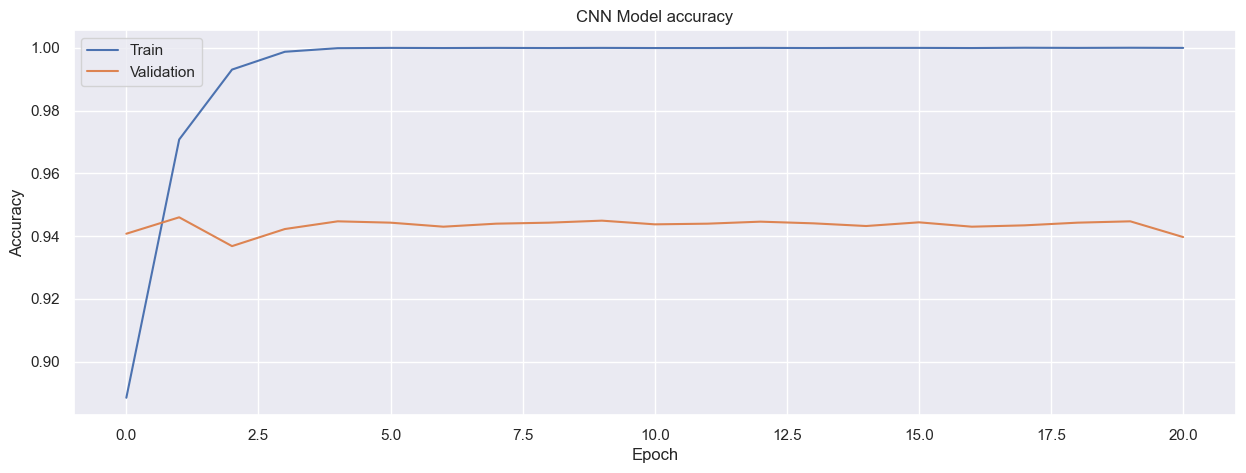

In [353]:
plt.plot(cnn_history.history["accuracy"]) 
plt.plot(cnn_history.history["val_accuracy"]) 
plt.title("CNN Model accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("Epoch") 
plt.legend(["Train", "Validation"], loc="upper left") 
plt.show()

#### 8.2.7 Model Loss

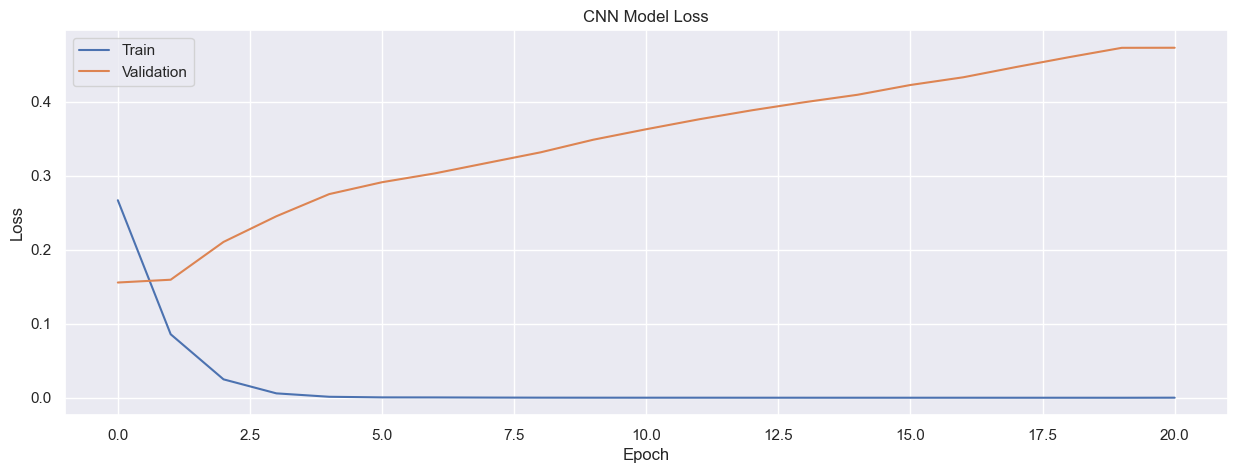

In [354]:
plt.plot(cnn_history.history["loss"])
plt.plot(cnn_history.history["val_loss"])
plt.title("CNN Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

#### 8.2.8 Confusion Matrix

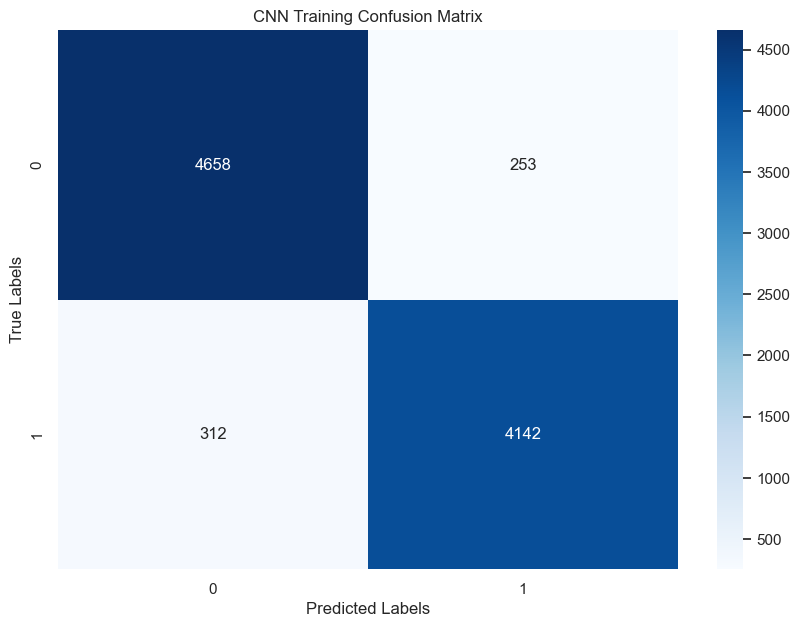

In [355]:
# confusion matrix for training data
train_conf_matrix = confusion_matrix(cnn_y_validation, cnn_train_prediction_classes)

plt.figure(figsize=(10, 7))
sb.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN Training Confusion Matrix")
plt.show()


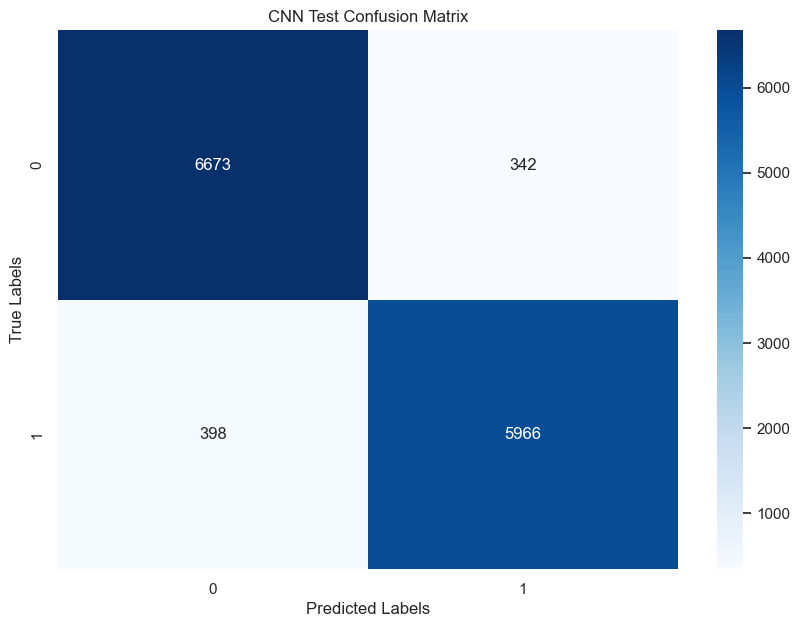

In [356]:
cnn_test_conf_matrix = confusion_matrix(cnn_y_test, cnn_test_prediction_classes) 

plt.figure(figsize=(10, 7)) 
sb.heatmap(cnn_test_conf_matrix, annot=True, fmt="d", cmap="Blues") 
plt.xlabel("Predicted Labels") 
plt.ylabel("True Labels") 
plt.title("CNN Test Confusion Matrix") 
plt.show()

#### 8.2.9 Saving Tokanizer

In [385]:
with open('models/cnn_tokenizer.pkl', 'wb') as handle: 
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 8.2.10 Saving CNN Model

In [386]:
cnn_model.save("models/cnn_model.h5")

### 8.3 Curious Object-Based seaRch Agent (COBRA)

#### 8.3.1 Model Building

In [357]:
# tokenization
tokenizer = Tokenizer(num_words=total_words_95)
tokenizer.fit_on_texts(train_data["combined_text"])

train_sequences = tokenizer.texts_to_sequences(train_data["combined_text"])
validation_sequences = tokenizer.texts_to_sequences(validation_data["combined_text"])
test_sequences = tokenizer.texts_to_sequences(test_data["combined_text"])

max_sequence_length = 20

# padding
train_padding = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
validation_padding = pad_sequences(validation_sequences, maxlen=max_sequence_length, padding='post')
test_padding = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

vector_features = 40

# creating COBRA model
inputs = Input(shape=(max_sequence_length,))
embedding = Embedding(input_dim=19174, output_dim=vector_fatures, input_length=max_sequence_length)(inputs)
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
attention = MultiHeadAttention(num_heads=4, key_dim=64)(bi_lstm, bi_lstm)
attentation_pooling = GlobalMaxPooling1D()(attention)
dropout = Dropout(0.1)(attentation_pooling)
output = Dense(1, activation="sigmoid")(dropout)
cobra_model = Model(inputs=inputs, outputs=output)

cobra_model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

cobra_model.summary()

# Training the COBRA model
cobra_y_train = np.asarray(train_data["label"])
cobra_y_validation = np.asarray(validation_data["label"])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(cobra_y_train), y=cobra_y_train) # compute class weights 
class_weights_dict = dict(enumerate(class_weights))
early_stopping = EarlyStopping(monitor='val_loss', patience=20) # early stopping 
cobra_history = cobra_model.fit(train_padding, cobra_y_train, batch_size=64, validation_data=(validation_padding, cobra_y_validation), epochs=100, class_weight=class_weights_dict, callbacks=[early_stopping])# fit the model and capture the history 

# Training evaluations
cobra_train_predictions = cobra_model.predict(validation_padding)
cobra_train_prediction_classes = (cobra_train_predictions > 0.5).astype("int32")
cobra_train_accuracy = accuracy_score(cobra_y_validation, cobra_train_prediction_classes)
cobra_train_precision = precision_score(cobra_y_validation, cobra_train_prediction_classes)
cobra_train_recall = recall_score(cobra_y_validation, cobra_train_prediction_classes)
cobra_train_f1 = f1_score(cobra_y_validation, cobra_train_prediction_classes)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 20, 50)               958700    ['input_3[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 20, 128)              58880     ['embedding_9[0][0]']         
 onal)                                                                                            
                                                                                                  
 multi_head_attention_2 (Mu  (None, 20, 128)              131968    ['bidirectional_2[0][0]'

#### 8.3.2 Model Accuracy

In [358]:
print("COBRA Training Validation Metrics:")
print(f"Accuracy: {cobra_train_accuracy * 100}")
print(f"Precision: {cobra_train_precision * 100}")
print(f"Recall: {cobra_train_recall * 100}")
print(f"F1: {cobra_train_f1 * 100}")

COBRA Training Validation Metrics:
Accuracy: 94.11639081687133
Precision: 93.58945722582087
Recall: 94.07274360125729
F1: 93.8304781099541


#### 8.3.3 Testing Model

In [359]:
cobra_y_test = np.asarray(test_data["label"])
cobra_test_predictions = cobra_model.predict(test_padding)
cobra_test_prediction_classes = (cobra_test_predictions > 0.5).astype("int32")
cobra_test_accuracy = accuracy_score(cobra_y_test, cobra_test_prediction_classes)
cobra_test_precision = precision_score(cobra_y_test, cobra_test_prediction_classes)
cobra_test_recall = recall_score(cobra_y_test, cobra_test_prediction_classes)
cobra_test_f1 = f1_score(cobra_y_test, cobra_test_prediction_classes)

419/419 [==============================] - 4s 9ms/step


#### 8.3.4 Test Model Accuracy

In [360]:
print(f"Test Accuracy: {cobra_test_accuracy * 100}")
print(f"Test Precision: {cobra_test_precision * 100}")
print(f"Test Recall: {cobra_test_recall * 100}")
print(f"Test F1 Score: {cobra_test_f1 * 100}")


Test Accuracy: 94.4988414679722
Test Precision: 93.88646288209607
Test Recall: 94.5945945945946
Test F1 Score: 94.23919849718222


#### 8.3.5 Testing Custom Data

In [361]:
# Test - 1 -> True News
custom_title = "NASA's Perseverance Rover Successfully Lands on Mars"
custom_text = "NASA's Perseverance rover has successfully landed on Mars, marking a significant milestone in space exploration. The rover will search for signs of ancient life and collect rock and soil samples for future return to Earth. This achievement showcases the incredible advancements in technology and human ingenuity."

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# make predictions on the custom input
custom_prediction = cobra_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")

1/1 [==============================] - 0s 29ms/step
Prediction: 1
Probability: 100.0


In [362]:
# Test - 2 -> Fake News
custom_title = "Aliens Invade Earth, Demand Human Resources"
custom_text = "Reports are flooding in from around the world of an alien invasion. Witnesses claim that extraterrestrial beings have landed and are demanding human resources to repair their spaceship. Authorities are urging citizens to stay indoors and avoid contact with these mysterious visitors. Experts are baffled by the sudden appearance of these otherworldly creatures."

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cobra_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 27ms/step
Prediction: 1
Probability: 92.50364899635315


In [363]:
# Test - 3 -> True News
custom_title = """Michigan bill does not prohibit recounts based on allegations of election fraud"""
custom_text = """A bill signed by Michigan Gov. Gretchen Whitmer clarifies the rules around a recount but does not prohibit recounts based on election fraud allegations."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cobra_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 26ms/step
Prediction: 0
Probability: 10.122204571962357


In [364]:
# Test - 4 -> False News
custom_title = """Thousands of fraudulent ballots for Clinton uncovered"""
custom_text = """A story claimed that tens of thousands of fraudulent ballots had been found in a warehouse in Ohio. The ballots had supposedly been cast for Hillary Clinton and were found inside sealed ballot boxes that would be counted alongside real election ballot boxes. This story was disproven."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cobra_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 27ms/step
Prediction: 0
Probability: 8.015055192624448e-13


In [365]:
# Test - 5 -> True News
custom_title = """WHO Recommends New Vaccine for Malaria Prevention"""
custom_text = """The World Health Organization has approved a new malaria vaccine that shows promise in preventing the disease in children. It is expected to reduce mortality rates significantly in affected regions."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cobra_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 33ms/step
Prediction: 1
Probability: 100.0


In [366]:
# Test - 6 -> False News
custom_title = """Aliens Spotted Over the White House in Broad Daylight"""
custom_text = """A viral video circulating online shows what appears to be an alien spacecraft hovering above the White House. Eyewitnesses claim they saw strange lights and heard an eerie hum coming from the object."""

custom_title = custom_title.lower()
custom_title = remove_punctuations(custom_title)
custom_title = remove_stop_words(custom_title)
custom_title = text_tokenizer(custom_title)
custom_title = stemming_text(custom_title)

custom_text = custom_text.lower()
custom_text = remove_punctuations(custom_text)
custom_text = remove_stop_words(custom_text)
custom_text = text_tokenizer(custom_text)
custom_text = stemming_text(custom_text)

# Combine the custom title and text
custom_combined_text = custom_title + " " + custom_text

# Tokenize and pad the custom input
custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')

# Make predictions on the custom input
custom_prediction = cobra_model.predict(custom_padded)
custom_prediction_class = (custom_prediction > 0.5).astype("int32")

# Print the prediction result
print(f"Prediction: {custom_prediction_class[0][0]}")
print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 27ms/step
Prediction: 0
Probability: 0.34131419379264116


In [367]:
# News titles
titles = [
    # True News Titles
    "WHO Recommends New Vaccine for Malaria Prevention",
    "Global Stock Markets See Sharp Decline Amid Economic Uncertainty",
    "NASA Schedules Artemis Mission to Return Humans to the Moon",
    "Scientists Develop Bioengineered Skin That Heals Faster",
    "Amazon Expands Renewable Energy Projects Globally",
    "Michigan bill does not prohibit recounts based on allegations of election fraud",
    "Video of Florida voter registration drive used to mislead on proof of citizenship question",
    "Posts falsely blame Ukraine for a missile strike on Kyiv children’s hospital",
    "NASA's Perseverance Rover lands on Mars",
    "Brexit Referendum Results",

    # Fake News Titles
    "Aliens Spotted Over the White House in Broad Daylight",
    "Eating Chocolate Daily Proven to Increase Lifespan by 20 Years",
    "Secret Underwater Pyramid Found in the Pacific Ocean",
    "Time Traveler Arrested After Predicting Events of 2050",
    "Government Implants Nanochips in Vaccines for Surveillance",
    "Thousands of fraudulent ballots for Clinton uncovered",
    "Megyn Kelly was fired after she endorsed Clinton",
    "The NBA cancels 2017 All-Star Game in North Carolina",
    "Pope Francis endorses Donald Trump",
    "Hillary Clinton running a child sex ring"
]

# News texts
texts = [
    # True News Texts
    "The World Health Organization has approved a new malaria vaccine that shows promise in preventing the disease in children. It is expected to reduce mortality rates significantly in affected regions.",
    "Major stock markets around the world experienced a significant drop due to rising economic uncertainty. Experts attribute the decline to inflation and concerns about potential interest rate hikes.",
    "NASA announced that the Artemis program will send astronauts back to the lunar surface by 2025, marking the first manned moon landing since Apollo 17 in 1972.",
    "Researchers have created a bioengineered skin that can heal injuries more quickly than natural skin. This breakthrough could revolutionize treatments for burn victims and patients with chronic wounds.",
    "Amazon has committed to expanding its renewable energy projects, aiming to achieve 100% renewable energy across all operations by 2030. New solar and wind projects are planned in Europe, Asia, and North America.",
    "A bill signed by Michigan Gov. Gretchen Whitmer clarifies the rules around a recount but does not prohibit recounts based on election fraud allegations.",
    "Shortly before the U.S. House of Representatives passed a bill requiring proof of citizenship to register to vote, a video of a voter registration drive in Palm Beach, Florida, was shared to raise questions about noncitizens voting in U.S. elections.",
    "After Ukraine’s largest children’s hospital was struck as part of a daytime barrage, posts circulated social media falsely claiming that Ukraine was at fault for the hit.",
    "NASA's Perseverance rover successfully landed on Mars in February 2021. This event marked a significant milestone in space exploration and was widely covered by reputable news sources.",
    "The United Kingdom voted to leave the European Union in the 2016 Brexit referendum. This event was widely reported and verified by multiple news outlets.",

    # Fake News Texts
    "A viral video circulating online shows what appears to be an alien spacecraft hovering above the White House. Eyewitnesses claim they saw strange lights and heard an eerie hum coming from the object.",
    "A recent study allegedly shows that eating chocolate every day can extend life expectancy by up to 20 years. Researchers say cocoa contains special enzymes that prevent aging.",
    "An underwater pyramid, believed to be over 10,000 years old, has supposedly been discovered in the Pacific Ocean. The structure is said to contain treasures and artifacts of an ancient civilization.",
    "Police have reportedly detained a man claiming to be a time traveler from the year 2050. He was taken into custody after attempting to warn the public about 'a major catastrophe' scheduled to happen.",
    "Conspiracy theorists claim that the government has begun implanting nanochips in COVID-19 vaccines to monitor citizens' activities. The alleged chips are said to transmit data directly to a central database.",
    "A story claimed that tens of thousands of fraudulent ballots had been found in a warehouse in Ohio. The ballots had supposedly been cast for Hillary Clinton and were found inside sealed ballot boxes that would be counted alongside real election ballot boxes. This story was disproven.",
    "A story claimed that Megyn Kelly was fired by Fox News after endorsing Clinton. This story was proven to be false. In fact, Fox News had offered Kelly over $20 million a year to remain with the network.",
    "A story claimed that the NBA canceled the 2017 All-Star Game in North Carolina in protest of the state's anti-gay bathroom bill. This story was false.",
    "A widely circulated fake news story claimed that Pope Francis endorsed Donald Trump for the U.S. presidency. This story was completely false and had no basis in reality.",
    "Another infamous fake news story alleged that Hillary Clinton was running a child sex ring out of a pizza restaurant in Washington, D.C. This story was entirely fabricated and had no factual basis."
]

# Labels indicating true (1) or fake (0) news
labels = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = cobra_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 30ms/step
Test: 1 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 28ms/step
Test: 2 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 26ms/step
Test: 3 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 28ms/step
Test: 4 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99918937683105
1/1 [==============================] - 0s 29ms/step
Test: 5 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 1.1702330215968004e-07
1/1 [==============================] - 0s 27ms/step
Test: 6 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 10.122204571962357
1/1 [==============================] - 0s 27ms/step
Test: 7 -> The news was true but p

In [368]:
titles = [
    # True News Titles
    "'Don't drink the spirits': Laos backpackers avoid shots after suspected poisonings",
    "'Pregnant' for 15 months: Inside the 'miracle' fertility scam",
    "Why Indians are risking it all to chase the American Dream",
    "Huge deal struck but is it enough? 5 takeaways from a dramatic COP29",
    "Can RFK Jr make America's diet healthy again?",
    "Expelled the same day: Ireland hardens illegal immigration response",
    "In stifled sobs and fierce accusations, family falls apart at mass rape trial",
    "British man captured while fighting with Ukraine",
    "Wicked proves popular as opening set to be biggest for Broadway film",
    "Storm Bert floods 'absolutely devastating', says Welsh FM",

    # Fake News Titles
    "The Onion buys Alex Jones's Infowars at auction",
    "How US election fraud claims changed as Trump won",
    "Whirlwind of misinformation sows distrust ahead of US election day",
    "FBI issues warning over two fake election videos",
    "US officials say Russians faked 'Haitian voters' video",
    "War ‘tour’, football and graffiti: How Russia is trying to influence Africa",
    "A week of unrest - and a week of silence from big tech",
    "A Bugatti car, a first lady and the fake stories aimed at Americans",
    "TikTok users being fed misleading election news, BBC finds",
    "Government should counter misinformation on TikTok - MPs"
]

texts = [
    # True News Texts
    """As the sun slowly dips behind the jagged peaks of Mount Nam Xay, a group of brightly coloured hot air balloons drift across the Vang Vieng valley. In the river below, young tourists laugh and splash each other from their kayaks. It’s not hard to see what draws so many travellers here to this little town in central Laos. The scenery is stunning, the fun cheap and plentiful. But the town has found itself at the centre of an international scandal after six tourists died last week following suspected methanol poisoning. It is believed their alcoholic drinks may have contained methanol, an industrial chemical often used in bootleg alcohol. For the throngs of young western travellers on South East Asia’s backpacker trail, Vang Vieng has become famous for what is called “tubing.” One described it to me as a water borne pub crawl. Groups of friends in swimsuits and bikinis clamber aboard huge inner tubes that would normally be used on trucks and drift downstream, pulling in from time to time at river side bars where vodka shots are liberally administered, before plunging back into the water. By the time they reach Vang Vieng everyone is fairly merry.""",
    """Chioma is adamant that Hope, the baby boy she is holding in her arms, is her son.  After eight years of failed attempts to conceive, she sees him as her miracle baby. “I’m the owner of my baby,” she says defiantly. She’s sitting next to her husband, Ike, in the office of a Nigerian state official who spends the best part of an hour interrogating the couple. As the commissioner for women affairs and social welfare in Anambra state, Ify Obinabo has plenty of experience in resolving family disputes - but this is no ordinary disagreement. Five members of Ike’s family, who are also present in the room, do not believe Hope is the couple’s biological child, as Chioma and Ike claim. Chioma claims to have “carried” the child for about 15 months. The commissioner and Ike’s family are in disbelief at the absurdity of the claim. Chioma says she faced pressure from Ike’s family to conceive. They even asked him to marry another woman. In her desperation, she visited a “clinic” offering an unconventional “treatment” - an outlandish and disturbing scam preying on women desperate to become mothers that involves the trafficking of babies.""",
    """In October, US Immigration and Customs Enforcement (Ice) sent a chartered flight carrying Indian nationals back home, marking a growing trend in deportations to India. This was no ordinary flight - it was one of multiple large-scale “removal flights” carried out this year, each typically carrying more than 100 passengers. The flights were returning groups of Indian migrants who "did not establish a legal basis to remain in the US". According to US officials, the latest flight carrying adult men and women was routed to Punjab, close to many deportees' places of origin. No precise breakdown of hometowns was provided. In the US fiscal year 2024 which ended in September, more than 1,000 Indian nationals had been repatriated by charter and commercial flights, according to Royce Bernstein Murray, assistant secretary at the US Department of Homeland Security.""",
    """COP29 is over, with developing countries complaining that the $300bn (about £240bn) a year in climate finance they will receive by 2035 is a "paltry sum". Many of the rich country voices at the UN's climate conference were amazed that developing nations were unhappy with what on the surface seems a huge settlement. It is an improvement - on the current contribution of $100bn (£79.8bn) a year. However, the developing world, which had pushed for more, had many genuine issues with the final sum. A massive deal, but bitter divisions remain There were complaints it simply was not enough and that it was a mixture of grants and loans. And countries were deeply annoyed by the way the wealthy waited until the last minute to reveal their hand. “It's a paltry sum," India's delegate Chandni Raina told other delegates, after the deal had been gavelled through. "This document is little more than an optical illusion. This, in our opinion, will not address the enormity of the challenge we all face.""",
    """Robert F Kennedy Jr has set his sights on changing how Americans eat and drink. From the dyes in Fruit Loops cereal to seed oils in chicken nuggets, Kennedy - who is President-elect Trump's choice to lead the Department of Health and Human Services (DHHS) - has long spoken out against ingredients that he says hurt Americans' health. "We are betraying our children by letting [food] industries poison them,” Kennedy said at a rally in November, after he had ended his independent presidential bid and backed Donald Trump. But if Kennedy hopes to target junk food, he will first have to shake up the country's food regulations - and run up against Big Food. “What he's suggesting is taking on the food industry,” said former New York University nutrition professor Marion Nestle. “Will Trump back him up on that? I’ll believe it when I see it.”""",
    """The three Gardai - Irish police officers - walk down the rows of passengers on the bus, a few kilometres south of the border with Northern Ireland. Observing this is the head of the Garda National Immigration Bureau, Det Ch Supt Aidan Minnock. “If they don't have status to be in Ireland, we bring them to Dublin,” he explains. “They're removed on a ferry back to the UK on the same day.” Asylum applications in Ireland have risen by nearly 300% so far this year compared to the same period five years ago. A spike in arrivals from the UK has been driven by various factors, among these the UK’s tougher stance post-Brexit, including the fear of deportations to Rwanda, as well as Ireland’s relatively healthy economy. Most asylum seekers coming from the UK to the Republic of Ireland enter the country from Northern Ireland, as - unlike the airport or ferry routes - there is no passport control. The Garda checks along the 500km-long (310 miles) border are the only means of stopping illegal entry. Det Ch Supt Minnock told the BBC that 200 people had been returned to the UK this year as a result of these checkpoints, thought to be only a small fraction of those crossing the porous border illegally.""",
    """At the epicentre of this devastating family drama is Gisèle Pelicot, a diminutive 72-year-old woman, drugged by her former husband and abused for a decade by dozens of strangers he had recruited online. Watching her entering the court in Avignon and giving evidence, it was staggering to imagine the amount of abuse her body sustained. But as other members of her family have taken the stand, it has become painfully clear that no-one has emerged unscathed from the storm unleashed by the actions of the Pelicot patriarch. The damage to this family is clear. Individually, they have described the destructive force that engulfed them in November 2020 as a “tsunami” that left nothing but ruin in its wake.""",
    """A British man has been captured by Russian forces while fighting for Ukraine, according to reports. In a video circulating online, a man dressed in military clothing identifies himself as James Scott Rhys Anderson, 22, and says he formerly served in the British Army. Russian state news agency Tass quotes a military source saying that what they call a "UK mercenary" has been "taken prisoner in the Kursk area" of Russia, part of which Ukraine has held since launching a surprise offensive in August. The foreign secretary said: "We will do all we can to offer this UK national all the support we can." Asked about reports of Mr Anderson's capture, David Lammy said he had "been updated about that development in the last couple of days". Scott Anderson, Mr Anderson's father, said he had begged his son not to go to Ukraine. "He wanted to go out there because he thought he was doing what was right," Mr Anderson told the Daily Mail. "I’m hoping he’ll be used as a bargaining chip, but my son told me they torture their prisoners and I’m so frightened he’ll be tortured.""",
    """Wicked is projected to have the top-grossing opening weekend of any Broadway musical adaptation ever in the UK and Ireland, as well as North America. The adaptation of the hit musical is expected to rake in $114m (£90.6m) on its opening weekend in North America, according to data firm the Boxoffice Company. That overtakes the previous record holder, Les Miserables, which brought in $103m globally on its opening weekend in 2012. In the UK and Ireland, the film is forecast to earn $17.6m (£14m) this weekend, making it the top-grossing opening weekend of 2024. In North America, where Gladiator II also opened on Friday, this was the strongest weekend at the box office before the Thanksgiving holiday since 2013, the Boxoffice Company said. The musical Wicked, based on a book inventing the backstory of the Wicked Witch of the West, premiered on Broadway in 2003 and has been running on the West End for two decades. In North America, the film adaptation raked in $46.48m (£37m) on Friday (the data also includes Thursday premieres), and $36m on Saturday. The audience skewed heavily female - 72% - and 67% were over the age of 25, which is a "massive victory" for Universal, Boxoffice's Daniel Loria said.""",
    """Welsh First Minister Eluned Morgan has said the floods brought by Storm Bert have been "absolutely devastating", as heavy rain and strong winds continue to move across the UK. South Wales, where a major incident has been declared by one council, has seen over 100mm of rain in places, while two areas in the south east of the country are under severe flood warnings, detailing a "significant risk to life". Ms Morgan said authorities had been prepared for the storm, but added that "when you get the kind of enormity of rain we’ve had over the past few days", minimising the impact was always "going to be difficult". The worst of the rain is moving eastwards into England, where the midlands and south west have also seen flooding. Across the UK, more than 100 flood warnings are now in force. Yellow warnings for wind and rain have been in effect for western Scotland, southern England and Wales, as well as Northern Ireland but are due to expire late on Sunday. A sole yellow warning for wind comes into force on Monday covering part of Scotland. There are also hundreds of flood alerts in place in England, Wales and Scotland. Wind gusts have reached 75mph in coastal areas and up to 65mph inland.""",

    # Fake News Texts
    """Satirical news publication The Onion has bought Infowars, the media organisation headed by right-wing conspiracy theorist Alex Jones, for an undisclosed price at a court-ordered auction.""",
    """In the build-up to Tuesday’s US election, claims of voter fraud flooded social media - but as Donald Trump’s victory crystallised, the chatter largely subsided. The claims didn’t stop entirely, however. A number of right-wing influencers and organisations pushing stories about “cheating” and a “rigged” vote pointed to incomplete vote totals and continued to repeat discredited theories about the 2020 election. And disappointed Democratic Party supporters developed their own unsubstantiated voter fraud theories, some of which went viral on X, formerly Twitter, and other platforms. The reach of the posts is nowhere near the deluge of content that circulated after Trump lost the 2020 election. And with no support from losing candidate Kamala Harris or other Democratic Party officials, the chances seem slim of a large-scale movement developing along the lines of the “Stop the Steal” drive four years ago, which culminated in a riot at the US Capitol.""",
    """Rumours, misleading allegations and outright lies about voting and fraud are flooding online spaces in unprecedented numbers in advance of the US election. Hundreds of incidents involving purported voting irregularities are being collected and spread by individuals, as well as both independent and Republican-affiliated groups. A small number of posts are also coming from Democrats. The US government has also alleged that foreign actors, including Russia, are spreading fake videos to undermine confidence in the electoral process.""",
    """The Federal Bureau of Investigation (FBI) has warned of two fake videos circulating online that aim to cast doubt around the US presidential election - the latest in a series of alerts by top officials. BBC Verify found evidence linking the videos to a much larger, Russia-based operation that has produced hundreds of fakes directed at the election in recent months. In a post on X on Saturday, the FBI said the two videos were spreading rumours about ballot fraud and about Doug Emhoff, the husband of Democrat candidate Vice-President Kamala Harris. The fake videos, which purport to be from the FBI and include the bureau’s logo, did not receive a large amount of views from real people on X. “These videos are not authentic, are not from the FBI, and the content they depict is false,” the FBI statement said. “Attempts to deceive the public with false content about FBI operations undermines our democratic process and aims to erode trust in the electoral system.” Election polls - is Harris or Trump ahead?""",
    """US intelligence agencies say "Russian influence actors" are behind a suspected fake video of a Haitian man who claims to have voted “multiple times” in Georgia. The 20-second video, which has been viewed hundreds of thousands of times on X and other social networks, shows two men in a car claiming to be Haitian. One says they obtained US citizenship within six months of arriving and have voted for Kamala Harris in Gwinnett and Fulton counties in Georgia. They encourage other Haitians to come to the United States. The BBC has found clear indications, including false addresses and stock photos, which indicate the video is a fake.""",
    """Teenage footballers listen to the Russian national anthem before a match. Nearby, artists paint Russian President Vladimir Putin’s portrait on a wall during a graffiti festival. Welcome to Burkina Faso, one of the African nations where Russia is boosting its operations to gain influence. Evidence found by the BBC shows that Russia is using media and cultural initiatives to attract African journalists, influencers, and students while spreading misleading information.""",
    """For days, similar scenes have played out across England and parts of Northern Ireland - unrest, communities in fear, a huge police presence, with the flames being fanned by social media. For days, journalists at BBC News have been contacting big tech companies, trying to find out what they are doing about it. Whatever it is, they don't want to talk about it - the messaging app Telegram has been the only firm to issue an on-the-record statement. It is hoped the tide has started to turn on the streets. But if they hoped that by keeping quiet they would avoid further scrutiny, the tech firms may well be wrong. "I think it is horrendous they are not taking more ownership of what is happening", says Baroness Martha Lane Fox, one of the leading lights in the UK tech scene. She knows big tech from the inside, having sat on the board of Twitter, as it was then called.""",
    """A network of Russia-based websites masquerading as local American newspapers is pumping out fake stories as part of an AI-powered operation that is increasingly targeting the US election, a BBC investigation can reveal. A former Florida police officer who relocated to Moscow is one of the key figures behind it. The following would have been a bombshell report - if it were true. Olena Zelenska, the first lady of Ukraine, allegedly bought a rare Bugatti Tourbillon sports car for 4.5m euros ($4.8m; £3.8m) while visiting Paris for D-Day commemorations in June. The source of the funds was supposedly American military aid money. The story appeared on an obscure French website just days ago - and was swiftly debunked. Experts pointed out strange anomalies on the invoice posted online. A whistleblower cited in the story appeared only in an oddly edited video that may have been artificially created. Bugatti issued a sharp denial, calling it "fake news", and its Paris dealership threatened legal action against the people behind the false story. But before the truth could even get its shoes on, the lie had gone viral. Influencers had already picked up the false story and spread it widely.""",
    """Young voters in key election battlegrounds are being recommended fake AI-generated videos featuring party leaders, misinformation, and clips littered with abusive comments, the BBC has found. With TikTok emerging as a new social media battleground in this election, the political parties have begun a war of memes on the app in a bid to reach its audience of young voters. But a BBC project to investigate the content promoted by social media algorithms has found - alongside funny montages - young people on TikTok are being exposed to misleading and divisive content. It is being shared by everyone from students and political activists to comedians and anonymous bot-like accounts. Videos which have racked up hundreds of thousands of views have promoted unfounded rumours that a major scandal prompted Rishi Sunak to call an early election and the baseless claim that Sir Keir Starmer was responsible for the failure to prosecute serial paedophile Jimmy Savile.""",
    """The government should publish advice for its departments on engaging with young people, including on TikTok, a group of MPs has said. The culture, media and sport committee has been looking into countering disinformation online. Its call comes despite TikTok currently being banned on government devices due to data security concerns. Accurate information needs to be communicated in a "relatable" way, the MPs say. The committee says that countering misinformation is particularly important for young people, who are increasingly turning away from traditional media and towards social media for their information."""
]

labels = [1]*10 + [0]*10

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = cobra_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 30ms/step
Test: 1 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 0.0011097653441538569
1/1 [==============================] - 0s 28ms/step
Test: 2 -> The news was true but predicted as false
Label: 1
Prediction: 0
Probability: 9.492018726575679e-07
1/1 [==============================] - 0s 29ms/step
Test: 3 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 27ms/step
Test: 4 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99879598617554
1/1 [==============================] - 0s 29ms/step
Test: 5 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 28ms/step
Test: 6 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 99.99990463256836
1/1 [==============================] - 0s 30ms/step
Test: 7 -> The news 

In [369]:
titles = []
texts = []
labels = []

for index, row in test_data.iloc[:20].iterrows():
    titles.append(row["title"])
    texts.append(row["text"])
    labels.append(row["label"])

for i in range(len(titles)):
    # Sample custom title and text
    custom_title = titles[i]
    custom_text = texts[i]
    
    custom_title = custom_title.lower()
    custom_title = remove_punctuations(custom_title)
    custom_title = remove_stop_words(custom_title)
    custom_title = text_tokenizer(custom_title)
    custom_title = stemming_text(custom_title)
    
    custom_text = custom_text.lower()
    custom_text = remove_punctuations(custom_text)
    custom_text = remove_stop_words(custom_text)
    custom_text = text_tokenizer(custom_text)
    custom_text = stemming_text(custom_text)
    
    # Combine the custom title and text
    custom_combined_text = custom_title + " " + custom_text
    
    # Tokenize and pad the custom input
    custom_sequence = tokenizer.texts_to_sequences([custom_combined_text])
    custom_padded = pad_sequences(custom_sequence, maxlen=max_sequence_length, padding='post')
    
    # Make predictions on the custom input
    custom_prediction = cobra_model.predict(custom_padded)
    custom_prediction_class = (custom_prediction > 0.5).astype("int32")

    print(f"Test: {i + 1} -> ", end="")

    if custom_prediction_class[0][0] == 1 and labels[i] == 1:
        print("The news was true and predicted as true")
    elif custom_prediction_class[0][0] == 1 and labels[i] == 0:
        print("The news was false but predicted as true")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 1:
        print("The news was true but predicted as false")
    elif custom_prediction_class[0][0] == 0 and labels[i] == 0:
        print("The news was false and predicted as false")
    
    # Print the prediction result
    print(f"Label: {labels[i]}")
    print(f"Prediction: {custom_prediction_class[0][0]}")
    print(f"Probability: {custom_prediction[0][0] * 100}")


1/1 [==============================] - 0s 27ms/step
Test: 1 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 29ms/step
Test: 2 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 28ms/step
Test: 3 -> The news was false and predicted as false
Label: 0
Prediction: 0
Probability: 6.379461303836209e-11
1/1 [==============================] - 0s 28ms/step
Test: 4 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 30ms/step
Test: 5 -> The news was false and predicted as false
Label: 0
Prediction: 0
Probability: 9.410579470977436e-17
1/1 [==============================] - 0s 27ms/step
Test: 6 -> The news was true and predicted as true
Label: 1
Prediction: 1
Probability: 100.0
1/1 [==============================] - 0s 37ms/step
Test: 7 -> The news was false and predicte

#### 8.3.6 Model Accuracy

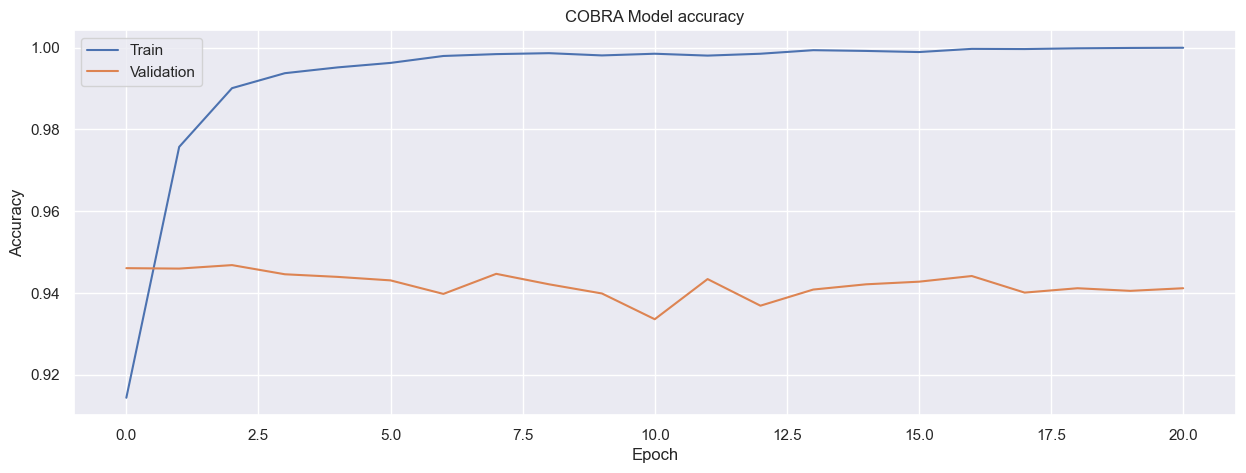

In [370]:
plt.plot(cobra_history.history["accuracy"]) 
plt.plot(cobra_history.history["val_accuracy"]) 
plt.title("COBRA Model accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("Epoch") 
plt.legend(["Train", "Validation"], loc="upper left") 
plt.show()

#### 8.3.7 Model Loss

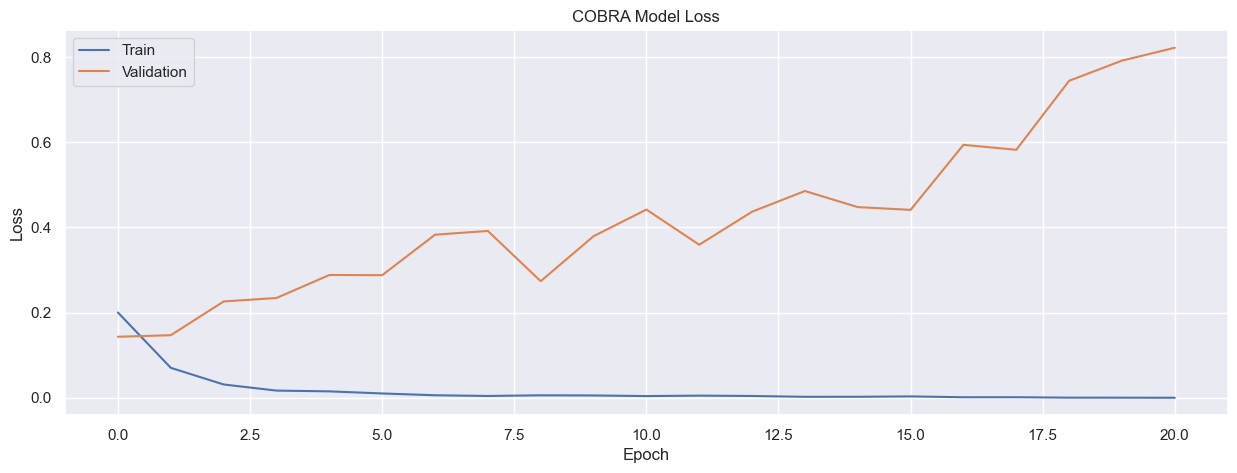

In [371]:
plt.plot(cobra_history.history["loss"])
plt.plot(cobra_history.history["val_loss"])
plt.title("COBRA Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

#### 8.3.8 Confusion Matrix

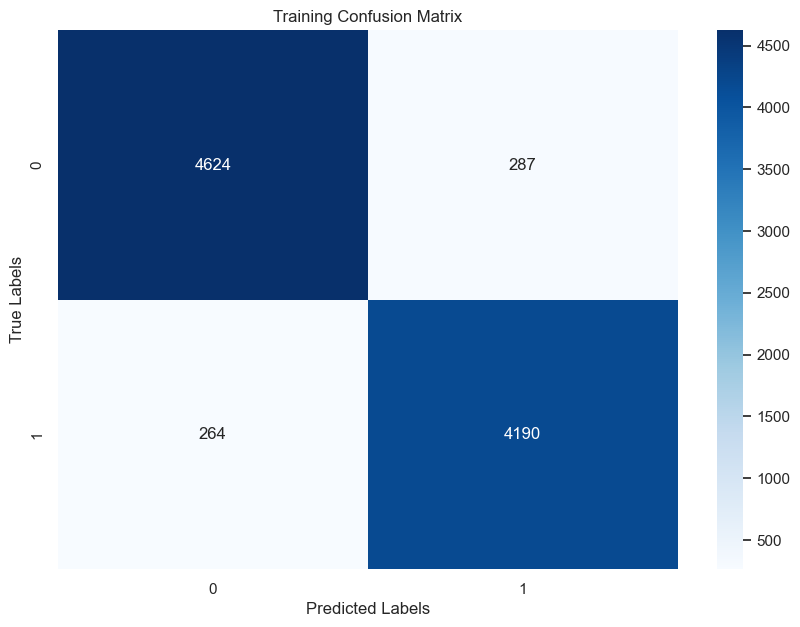

In [372]:
# confusion matrix for training data
train_conf_matrix = confusion_matrix(cobra_y_validation, cobra_train_prediction_classes)

plt.figure(figsize=(10, 7))
sb.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()

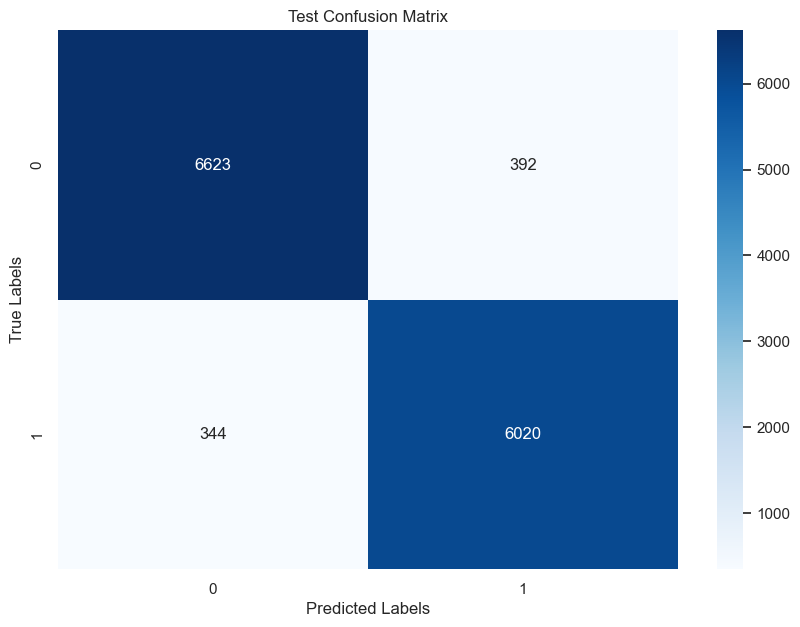

In [373]:
# confusion matrix for test data
test_conf_matrix = confusion_matrix(cobra_y_test, cobra_test_prediction_classes)

plt.figure(figsize=(10, 7))
sb.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')
plt.show()

#### 8.3.9 Saving Tokanizer

In [387]:
with open('models/cobra_tokenizer.pkl', 'wb') as handle: 
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 8.3.10 Saving COBRA Model

In [388]:
cobra_model.save("models/cobra_model.h5")

### 8.4 ROC-AUC Curve

293/293 [==============================] - 4s 13ms/step


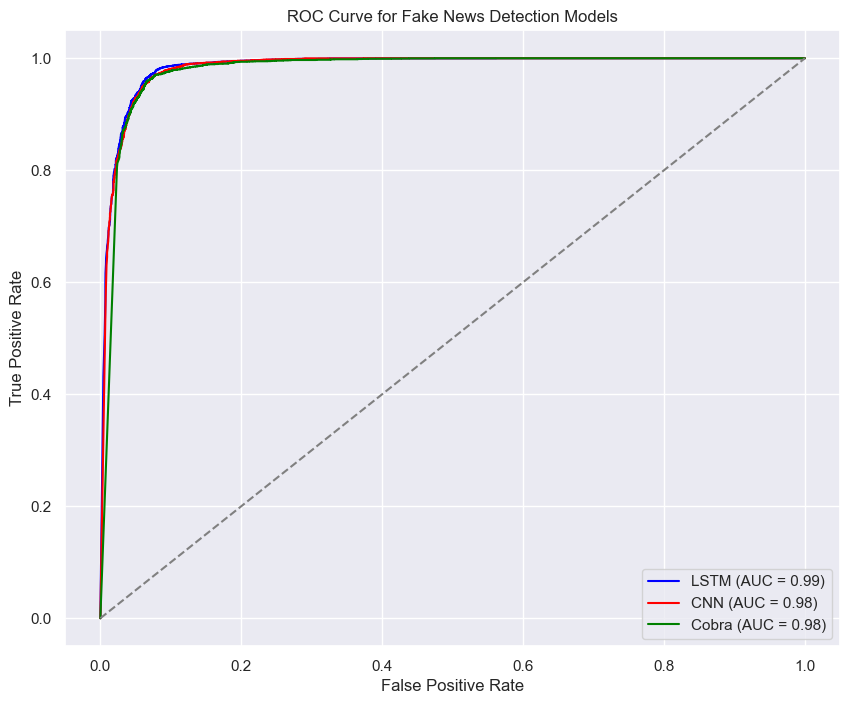

In [389]:
# getting predicted probabilities for each model
lstm_probs = lstm_model.predict(validation_padding)
cnn_probs = cnn_model.predict(validation_padding)
cobra_probs = cobra_model.predict(validation_padding)

# computing ROC curve and AUC for each model
lstm_fpr, lstm_tpr, _ = roc_curve(lstm_y_validation, lstm_train_predictions)
cnn_fpr, cnn_tpr, _ = roc_curve(cnn_y_validation, cnn_train_predictions)
cobra_fpr, cobra_tpr, _ = roc_curve(cobra_y_validation, cobra_train_predictions)

lstm_auc = auc(lstm_fpr, lstm_tpr)
cnn_auc = auc(cnn_fpr, cnn_tpr)
cobra_auc = auc(cobra_fpr, cobra_tpr)

plt.figure(figsize=(10, 8))
plt.plot(lstm_fpr, lstm_tpr, color='blue', label=f'LSTM (AUC = {lstm_auc:.2f})')
plt.plot(cnn_fpr, cnn_tpr, color='red', label=f'CNN (AUC = {cnn_auc:.2f})')
plt.plot(cobra_fpr, cobra_tpr, color='green', label=f'Cobra (AUC = {cobra_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Fake News Detection Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### 8.5 Precision-Recall Curve

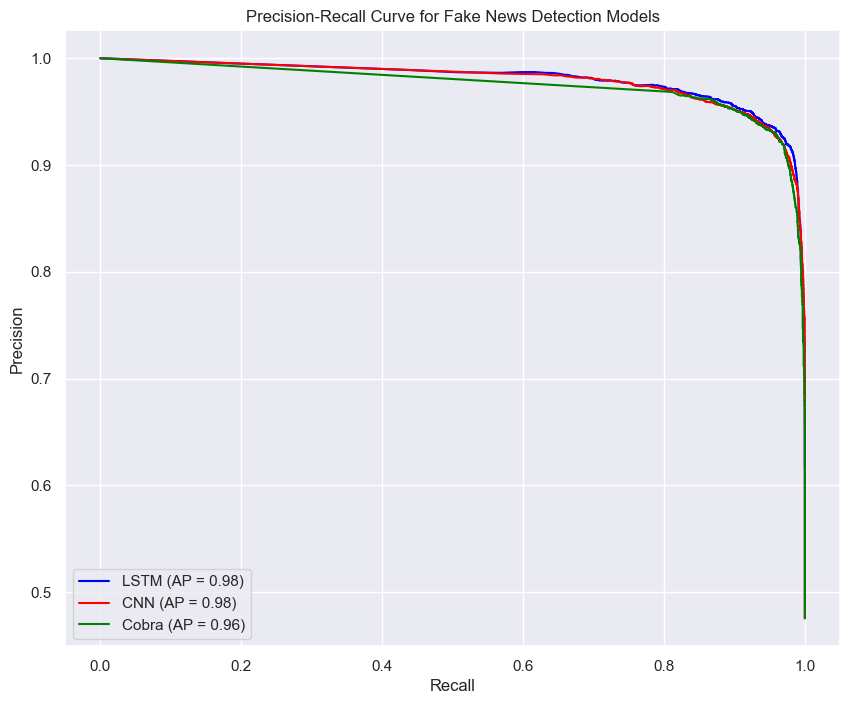

In [394]:
lstm_precision, lstm_recall, _ = precision_recall_curve(lstm_y_validation, lstm_probs)
cnn_precision, cnn_recall, _ = precision_recall_curve(cnn_y_validation, cnn_probs)
cobra_precision, cobra_recall, _ = precision_recall_curve(cobra_y_validation, cobra_probs)

plt.figure(figsize=(10, 8))
plt.plot(lstm_recall, lstm_precision, color='blue', label=f'LSTM (AP = {average_precision_score(lstm_y_validation, lstm_probs):.2f})')
plt.plot(cnn_recall, cnn_precision, color='red', label=f'CNN (AP = {average_precision_score(cnn_y_validation, cnn_probs):.2f})')
plt.plot(cobra_recall, cobra_precision, color='green', label=f'Cobra (AP = {average_precision_score(cobra_y_validation, cobra_probs):.2f})')
plt.title('Precision-Recall Curve for Fake News Detection Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

## 9. Saving Data

### 9.1. Saving Vocabulary

In [267]:
with open('models/total_words_95.txt', 'w') as file: 
    file.write(str(total_words_95))